In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy import optimize
import re
import copy
import logging
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter
sns.set()

# a little hacky, but works if you don't want to actually install the
# custom packages 
sys.path.append('../')
from uniswapv3_simulator.pool import Uniswapv3Pool
from uniswapv3_simulator.utils import *
from uniswapv3_simulator.math import tick_to_sqrt_price, sqrt_price_to_tick
from utils import amount_to_float

In [2]:
POOL = 'DAI-WETH-3000'
NUMERAIRE_TOKEN = 0
MAX_DATE = '2022-01-28'
SAVE_FREQ = 'D'
SAVED_POOLS = f'./saved-pools/{POOL}.pickle'
SAVED_DAILY_RETURNS = f'./saved-daily-returns/{POOL}.pickle'
SAVED_WEEKLY_RETURNS = f'./saved-weekly-returns/{POOL}.pickle'

timestamp = datetime.now().strftime('%y%m%d%H%M%S')
logging.basicConfig(level=logging.INFO,
                    filename=f'./logs/{POOL}_{timestamp}.log')
logging.getLogger('uniswap-v3').setLevel(logging.INFO)
logging.getLogger('uniswap-v3.utils').setLevel(logging.DEBUG)

In [3]:
data = pd.read_pickle('../data/pool_data_clean.pickle')
swaps = data[POOL]['swaps']
liquidity = data[POOL]['liquidity']

In [4]:
swaps.info()
swaps.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85084 entries, 0 to 85083
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   swap_time                       85084 non-null  datetime64[ns, UTC]
 1   tx_hash                         85084 non-null  string             
 2   token_0_amount                  85084 non-null  float64            
 3   token_1_amount                  85084 non-null  float64            
 4   pool_address                    85084 non-null  string             
 5   price_tick                      85084 non-null  int64              
 6   price_tick_adjusted             85084 non-null  float64            
 7   contract_address_token_0        85084 non-null  string             
 8   contract_name_token_0           85084 non-null  string             
 9   contract_ticker_symbol_token_0  85084 non-null  string             
 10  contract_d

,swap_time,tx_hash,token_0_amount,token_1_amount,pool_address,price_tick,price_tick_adjusted,contract_address_token_0,contract_name_token_0,contract_ticker_symbol_token_0,contract_decimals_token_0,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,pool_fee,pool_tick_spacing,pool_deploy_time
0,2022-01-29 19:40:04+00:00,0x1ad44b6363d4366ed280163f9bfc5db3144eb779e402...,49993.587664,-19.212778,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78625,0.000385,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
1,2022-01-29 19:38:25+00:00,0x89db0a6e6f070f4ac71cb9ee05f9d53685d656d0da5f...,6498.011618,-2.500000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78605,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
2,2022-01-29 19:35:24+00:00,0x8400651adba9ebf8fe080a2e459d8b6a5597b91b2ee1...,724.898482,-0.278932,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78603,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
3,2022-01-29 19:12:54+00:00,0xe9cbde726b3aa82b04516d2116417c5945d81eff9c2d...,6015.972726,-2.315181,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78602,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00
4,2022-01-29 19:03:47+00:00,0x6ae2345dd7f07c0901adab01a171cbf0edf8167d211e...,-8050.339052,3.116631,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,-78600,0.000386,0x6b175474e89094c44da98b954eedeac495271d0f,Dai Stablecoin,DAI,18,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,3000,60,2021-05-04 20:16:08+00:00


In [5]:
liquidity.info()
liquidity.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10955 entries, 0 to 10954
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   txn_time                        10955 non-null  datetime64[ns, UTC]
 1   tx_hash                         10955 non-null  string             
 2   token_0_amount                  10955 non-null  float64            
 3   token_1_amount                  10955 non-null  float64            
 4   pool_address                    10955 non-null  string             
 5   liquidity_event                 10955 non-null  string             
 6   price_tick_lower                10955 non-null  int64              
 7   price_tick_upper                10955 non-null  int64              
 8   price_tick_lower_adjusted       10955 non-null  float64            
 9   price_tick_upper_adjusted       10955 non-null  float64            
 10  contract_a

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2022-01-29 12:54:26+00:00,0xa2be14e74e960348d0bb66f8b83c16bddc63492fc718...,0.000000,0.000000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-103500,-59940,0.000032,0.002494,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x4f01339b3094365f857543721740c7e8fd2ace81,3000,60,2021-05-04 20:16:08+00:00,-0.000000
1,2022-01-29 12:49:59+00:00,0x171f4c3cc3f60d25816ea96c3a9927826ab99aab2080...,2465.286500,0.746695,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-88740,-64260,0.000140,0.001619,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xc532e8d1aba3ca8daea0f303b443d36b10bf47d4,3000,60,2021-05-04 20:16:08+00:00,95.047115
2,2022-01-29 12:46:27+00:00,0x5d5916f2d540c0a9294c70bc513e56cb9f0792edb475...,0.000000,0.000000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-88740,-64260,0.000140,0.001619,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0xc532e8d1aba3ca8daea0f303b443d36b10bf47d4,3000,60,2021-05-04 20:16:08+00:00,-0.000000
3,2022-01-29 11:08:31+00:00,0x14bd7b351ebd3d669447208c0f48163fe8cdb4121113...,1485.220949,1.481797,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-91080,-74340,0.000111,0.000591,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x2746049faca559dbb8619993eb7901d7b0a6df05,3000,60,2021-05-04 20:16:08+00:00,-159.426885
4,2022-01-29 11:08:31+00:00,0x14bd7b351ebd3d669447208c0f48163fe8cdb4121113...,0.000000,2.697595,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,REMOVE_LIQUIDITY,-91080,-79620,0.000111,0.000349,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Burn,0x2746049faca559dbb8619993eb7901d7b0a6df05,3000,60,2021-05-04 20:16:08+00:00,-331.267120


In [6]:
adds = liquidity.loc[liquidity['liquidity_event'] == 'ADD_LIQUIDITY', :].copy()
adds = adds.sort_values('txn_time').reset_index(drop=True)
adds.head()

,txn_time,tx_hash,token_0_amount,token_1_amount,pool_address,liquidity_event,price_tick_lower,price_tick_upper,price_tick_lower_adjusted,price_tick_upper_adjusted,...,contract_address_token_1,contract_name_token_1,contract_ticker_symbol_token_1,contract_decimals_token_1,event_name,account_address,pool_fee,pool_tick_spacing,pool_deploy_time,liquidity
0,2021-05-04 20:16:08+00:00,0x8c2161cdf81dacef87759fa8f1f8f94dc9de293b7579...,680.071584,0.175315,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-84120,-78240,0.000222,0.000400,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x3b8ccaa89fcd432f1334d35b10ff8547001ce3e5,3000,60,2021-05-04 20:16:08+00:00,80.059851
1,2021-05-04 20:46:44+00:00,0x963415802ca1d744d6d69ef10f1f5b7080db069a92ce...,335.885061,0.096306,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-84120,-78240,0.000222,0.000400,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xd83eeacb5b03129bc96c8e264063b3e4ad32a544,3000,60,2021-05-04 20:16:08+00:00,41.612787
2,2021-05-04 20:47:12+00:00,0x4916ff106f455203c14b875266c4c91f8f51253976d5...,339.657067,0.056960,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-81900,-80040,0.000278,0.000334,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0x0459b3fbf7c1840ee03a63ca4aa95de48322322e,3000,60,2021-05-04 20:16:08+00:00,100.961002
3,2021-05-04 20:50:31+00:00,0xb63423c77e18872cf1ce02fe4cdeee45c652c05ab462...,33.000000,0.009858,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-82920,-79560,0.000251,0.000351,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xc148480a8eff5e6885ab0ac7905291dd11fd6499,3000,60,2021-05-04 20:16:08+00:00,7.079623
4,2021-05-04 21:38:37+00:00,0xc6948b019bbb045db6ab5e4869e63a192686a636451a...,68.356153,0.008000,0xc2e9f25be6257c210d7adf0d4cd6e3e881ba25f8,ADD_LIQUIDITY,-85200,-69060,0.000200,0.001002,...,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,Wrapped Ether,WETH,18,Mint,0xdd0d6c26a03d6f6541471d44179f56d478f50f6b,3000,60,2021-05-04 20:16:08+00:00,2.582287


In [7]:
first_add_hash = adds.at[0, 'tx_hash']
print(f'First liquidity add hash: {first_add_hash}')

First liquidity add hash: 0x8c2161cdf81dacef87759fa8f1f8f94dc9de293b757939fcf0fdc866e80ed052


In [8]:
# from https://etherscan.io/tx/0xf803bec9942ee16a73f4f5fc861eb642f4f88a98e72b9dbcfc2a1613bbf282d9#eventlog
liquidity_delta = amount_to_float('80059851033970806503', 18)  # belive all liquidity amounts use 18 decimals
assert liquidity_delta == adds.at[0, 'liquidity']

token0 = adds.at[0, 'token_0_amount']
token1 = adds.at[0, 'token_1_amount']
tick_lower = adds.at[0, 'price_tick_lower']
tick_upper = adds.at[0, 'price_tick_upper']
token0_decimals = adds.at[0, 'contract_decimals_token_0']
token1_decimals = adds.at[0, 'contract_decimals_token_1']

init_price = pool_init_price(token0, token1, tick_upper, tick_lower, liquidity_delta,
                             token0_decimals, token1_decimals)

token0_symb = liquidity.at[0, 'contract_ticker_symbol_token_0']
token1_symb = liquidity.at[0, 'contract_ticker_symbol_token_1']
print(f'Pool initial price ({token1_symb}/{token0_symb}): {init_price:,.12e}')
print(f'Pool initial price ({token0_symb}/{token1_symb}): {1 / init_price:,.12e}')

Pool initial price (WETH/DAI): 2.923692113061e-04
Pool initial price (DAI/WETH): 3.420332789259e+03


In [9]:
sqrt_price_x96 = 1354707084081889255546596745
etherscan_price = sqrt_price_x96 ** 2 / 2 ** 192
print(f"Calculated initial price: {init_price:.12e}")
print(f"Price per Etherscan:      {etherscan_price:.12e}")

Calculated initial price: 2.923692113061e-04
Price per Etherscan:      2.923692113059e-04


In [10]:
all_txn = organize_txns(liquidity, swaps, max_date=MAX_DATE)
all_txn

,orig_idx,tx_hash,txn_time,event
0,10954,0x8c2161cdf81dacef87759fa8f1f8f94dc9de293b7579...,2021-05-04 20:16:08+00:00,ADD_LIQUIDITY
1,85083,0x2bdb4298b35adf058a38dfbe85470f67da1cb76e1694...,2021-05-04 20:21:15+00:00,SWAP
2,10953,0x963415802ca1d744d6d69ef10f1f5b7080db069a92ce...,2021-05-04 20:46:44+00:00,ADD_LIQUIDITY
3,10952,0x4916ff106f455203c14b875266c4c91f8f51253976d5...,2021-05-04 20:47:12+00:00,ADD_LIQUIDITY
4,10951,0xb63423c77e18872cf1ce02fe4cdeee45c652c05ab462...,2021-05-04 20:50:31+00:00,ADD_LIQUIDITY
...,...,...,...,...
95656,360,0xeaf0faccfaa24981e885849cda5e59abfb31148b5b6e...,2022-01-27 23:43:05+00:00,SWAP
95657,359,0x2ab192bdddbddadfad0799bc610795145c583ff579c8...,2022-01-27 23:44:12+00:00,SWAP
95658,358,0xf39c37bfbdb1904fc71752417de983d4d6b7fd35a242...,2022-01-27 23:52:44+00:00,SWAP
95659,357,0x8ff7c5ffbd38fb2485b5c81de031c4d3eeafee485232...,2022-01-27 23:52:48+00:00,SWAP


In [11]:
CHECKS_ON = False
# need to think about appropriate error tolerances
# TODO: maybe base these tolerances on the average transaction size?
TOKEN0_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
TOKEN1_TOLS = {'atol': 1e-12, 'rtol': 1e-8}
LIQUIDITY_TOLS = {'atol': 1e-8, 'rtol': 1e-5}

In [12]:
pool_snapshots, tx_results = run_historical_pool(
    init_price, 
    all_txn, 
    liquidity, 
    swaps,
    save_freq=SAVE_FREQ,
    position_id='generic_LP', 
    checks_on=CHECKS_ON, 
    verbose=True,
    token0_tols=TOKEN0_TOLS,
    token1_tols=TOKEN1_TOLS,
    liquidity_tols=LIQUIDITY_TOLS
)
pd.to_pickle(pool_snapshots, SAVED_POOLS)

Pool(price=0.0003, liquidity=0.00, fee=0.30%)
Completed transaction 0.
Completed transaction 1.
Completed transaction 2.
Completed transaction 3.
Completed transaction 4.
Completed transaction 5.
Completed transaction 6.
Completed transaction 7.
Completed transaction 8.
Completed transaction 9.
Completed transaction 10.
Completed transaction 11.
Completed transaction 12.
Completed transaction 13.
Completed transaction 14.
Completed transaction 15.
Completed transaction 16.
Completed transaction 17.
Completed transaction 18.
Completed transaction 19.
Completed transaction 20.
Completed transaction 21.
Completed transaction 22.
Completed transaction 23.
Completed transaction 24.
Completed transaction 25.
Completed transaction 26.
Completed transaction 27.
Completed transaction 28.
Completed transaction 29.
Completed transaction 30.
Completed transaction 31.
Completed transaction 32.
Completed transaction 33.
Completed transaction 34.
Completed transaction 35.
Completed transaction 36.
Co

Completed transaction 555.
Completed transaction 556.
Completed transaction 557.
Completed transaction 558.
Completed transaction 559.
Completed transaction 560.
Completed transaction 561.
Completed transaction 562.
Completed transaction 563.
Completed transaction 564.
Completed transaction 565.
Completed transaction 566.
Completed transaction 567.
Completed transaction 568.
Completed transaction 569.
Completed transaction 570.
Completed transaction 571.
Completed transaction 572.
Completed transaction 573.
Completed transaction 574.
Completed transaction 575.
Completed transaction 576.
Completed transaction 577.
Completed transaction 578.
Completed transaction 579.
Completed transaction 580.
Completed transaction 581.
Completed transaction 582.
Completed transaction 583.
Completed transaction 584.
Completed transaction 585.
Completed transaction 586.
Completed transaction 587.
Completed transaction 588.
Completed transaction 589.
Completed transaction 590.
Completed transaction 591.
C

Completed transaction 862.
Completed transaction 863.
Completed transaction 864.
Completed transaction 865.
Completed transaction 866.
Completed transaction 867.
Completed transaction 868.
Completed transaction 869.
Completed transaction 870.
Completed transaction 871.
Completed transaction 872.
Completed transaction 873.
Completed transaction 874.
Completed transaction 875.
Completed transaction 876.
Completed transaction 877.
Completed transaction 878.
Completed transaction 879.
Completed transaction 880.
Completed transaction 881.
Completed transaction 882.
Completed transaction 883.
Completed transaction 884.
Completed transaction 885.
Completed transaction 886.
Completed transaction 887.
Completed transaction 888.
Completed transaction 889.
Completed transaction 890.
Completed transaction 891.
Completed transaction 892.
Completed transaction 893.
Completed transaction 894.
Completed transaction 895.
Completed transaction 896.
Completed transaction 897.
Completed transaction 898.
C

Completed transaction 1416.
Completed transaction 1417.
Completed transaction 1418.
Completed transaction 1419.
Completed transaction 1420.
Completed transaction 1421.
Completed transaction 1422.
Completed transaction 1423.
Completed transaction 1424.
Completed transaction 1425.
Completed transaction 1426.
Completed transaction 1427.
Completed transaction 1428.
Completed transaction 1429.
Completed transaction 1430.
Completed transaction 1431.
Completed transaction 1432.
Completed transaction 1433.
Completed transaction 1434.
Completed transaction 1435.
Completed transaction 1436.
Completed transaction 1437.
Completed transaction 1438.
Completed transaction 1439.
Completed transaction 1440.
Completed transaction 1441.
Completed transaction 1442.
Completed transaction 1443.
Completed transaction 1444.
Completed transaction 1445.
Completed transaction 1446.
Completed transaction 1447.
Completed transaction 1448.
Completed transaction 1449.
Completed transaction 1450.
Completed transactio

Completed transaction 1871.
Completed transaction 1872.
Completed transaction 1873.
Completed transaction 1874.
Completed transaction 1875.
Completed transaction 1876.
Completed transaction 1877.
Completed transaction 1878.
Completed transaction 1879.
Completed transaction 1880.
Completed transaction 1881.
Completed transaction 1882.
Completed transaction 1883.
Completed transaction 1884.
Completed transaction 1885.
Completed transaction 1886.
Completed transaction 1887.
Completed transaction 1888.
Completed transaction 1889.
Completed transaction 1890.
Completed transaction 1891.
Completed transaction 1892.
Completed transaction 1893.
Completed transaction 1894.
Completed transaction 1895.
Completed transaction 1896.
Completed transaction 1897.
Completed transaction 1898.
Completed transaction 1899.
Completed transaction 1900.
Completed transaction 1901.
Completed transaction 1902.
Completed transaction 1903.
Completed transaction 1904.
Completed transaction 1905.
Completed transactio

Completed transaction 2169.
Completed transaction 2170.
Completed transaction 2171.
Completed transaction 2172.
Completed transaction 2173.
Completed transaction 2174.
Completed transaction 2175.
Completed transaction 2176.
Completed transaction 2177.
Completed transaction 2178.
Completed transaction 2179.
Completed transaction 2180.
Completed transaction 2181.
Completed transaction 2182.
Completed transaction 2183.
Completed transaction 2184.
Completed transaction 2185.
Completed transaction 2186.
Completed transaction 2187.
Completed transaction 2188.
Completed transaction 2189.
Completed transaction 2190.
Completed transaction 2191.
Completed transaction 2192.
Completed transaction 2193.
Completed transaction 2194.
Completed transaction 2195.
Completed transaction 2196.
Completed transaction 2197.
Completed transaction 2198.
Completed transaction 2199.
Completed transaction 2200.
Completed transaction 2201.
Completed transaction 2202.
Completed transaction 2203.
Completed transactio

Completed transaction 2467.
Completed transaction 2468.
Completed transaction 2469.
Completed transaction 2470.
Completed transaction 2471.
Completed transaction 2472.
Completed transaction 2473.
Completed transaction 2474.
Completed transaction 2475.
Completed transaction 2476.
Completed transaction 2477.
Completed transaction 2478.
Completed transaction 2479.
Completed transaction 2480.
Completed transaction 2481.
Completed transaction 2482.
Completed transaction 2483.
Completed transaction 2484.
Completed transaction 2485.
Completed transaction 2486.
Completed transaction 2487.
Completed transaction 2488.
Completed transaction 2489.
Completed transaction 2490.
Completed transaction 2491.
Completed transaction 2492.
Completed transaction 2493.
Completed transaction 2494.
Completed transaction 2495.
Completed transaction 2496.
Completed transaction 2497.
Completed transaction 2498.
Completed transaction 2499.
Completed transaction 2500.
Completed transaction 2501.
Completed transactio

Completed transaction 2762.
Completed transaction 2763.
Completed transaction 2764.
Completed transaction 2765.
Completed transaction 2766.
Completed transaction 2767.
Completed transaction 2768.
Completed transaction 2769.
Completed transaction 2770.
Completed transaction 2771.
Completed transaction 2772.
Completed transaction 2773.
Completed transaction 2774.
Completed transaction 2775.
Completed transaction 2776.
Completed transaction 2777.
Completed transaction 2778.
Completed transaction 2779.
Completed transaction 2780.
Completed transaction 2781.
Completed transaction 2782.
Completed transaction 2783.
Completed transaction 2784.
Completed transaction 2785.
Completed transaction 2786.
Completed transaction 2787.
Completed transaction 2788.
Completed transaction 2789.
Completed transaction 2790.
Completed transaction 2791.
Completed transaction 2792.
Completed transaction 2793.
Completed transaction 2794.
Completed transaction 2795.
Completed transaction 2796.
Completed transactio

Completed transaction 3344.
Completed transaction 3345.
Completed transaction 3346.
Completed transaction 3347.
Completed transaction 3348.
Completed transaction 3349.
Completed transaction 3350.
Completed transaction 3351.
Completed transaction 3352.
Completed transaction 3353.
Completed transaction 3354.
Completed transaction 3355.
Completed transaction 3356.
Completed transaction 3357.
Completed transaction 3358.
Completed transaction 3359.
Completed transaction 3360.
Completed transaction 3361.
Completed transaction 3362.
Completed transaction 3363.
Completed transaction 3364.
Completed transaction 3365.
Completed transaction 3366.
Completed transaction 3367.
Completed transaction 3368.
Completed transaction 3369.
Completed transaction 3370.
Completed transaction 3371.
Completed transaction 3372.
Completed transaction 3373.
Completed transaction 3374.
Completed transaction 3375.
Completed transaction 3376.
Completed transaction 3377.
Completed transaction 3378.
Completed transactio

Completed transaction 3872.
Completed transaction 3873.
Completed transaction 3874.
Completed transaction 3875.
Completed transaction 3876.
Completed transaction 3877.
Completed transaction 3878.
Completed transaction 3879.
Completed transaction 3880.
Completed transaction 3881.
Completed transaction 3882.
Completed transaction 3883.
Completed transaction 3884.
Completed transaction 3885.
Completed transaction 3886.
Completed transaction 3887.
Completed transaction 3888.
Completed transaction 3889.
Completed transaction 3890.
Completed transaction 3891.
Completed transaction 3892.
Completed transaction 3893.
Completed transaction 3894.
Completed transaction 3895.
Completed transaction 3896.
Completed transaction 3897.
Completed transaction 3898.
Completed transaction 3899.
Completed transaction 3900.
Completed transaction 3901.
Completed transaction 3902.
Completed transaction 3903.
Completed transaction 3904.
Completed transaction 3905.
Completed transaction 3906.
Completed transactio

Completed transaction 4171.
Completed transaction 4172.
Completed transaction 4173.
Completed transaction 4174.
Completed transaction 4175.
Completed transaction 4176.
Completed transaction 4177.
Completed transaction 4178.
Completed transaction 4179.
Completed transaction 4180.
Completed transaction 4181.
Completed transaction 4182.
Completed transaction 4183.
Completed transaction 4184.
Completed transaction 4185.
Completed transaction 4186.
Completed transaction 4187.
Completed transaction 4188.
Completed transaction 4189.
Completed transaction 4190.
Completed transaction 4191.
Completed transaction 4192.
Completed transaction 4193.
Completed transaction 4194.
Completed transaction 4195.
Completed transaction 4196.
Completed transaction 4197.
Completed transaction 4198.
Completed transaction 4199.
Completed transaction 4200.
Completed transaction 4201.
Completed transaction 4202.
Completed transaction 4203.
Completed transaction 4204.
Completed transaction 4205.
Completed transactio

Completed transaction 4476.
Completed transaction 4477.
Completed transaction 4478.
Completed transaction 4479.
Completed transaction 4480.
Completed transaction 4481.
Completed transaction 4482.
Completed transaction 4483.
Completed transaction 4484.
Completed transaction 4485.
Completed transaction 4486.
Completed transaction 4487.
Completed transaction 4488.
Completed transaction 4489.
Completed transaction 4490.
Completed transaction 4491.
Completed transaction 4492.
Completed transaction 4493.
Completed transaction 4494.
Completed transaction 4495.
Completed transaction 4496.
Completed transaction 4497.
Completed transaction 4498.
Completed transaction 4499.
Completed transaction 4500.
Completed transaction 4501.
Completed transaction 4502.
Completed transaction 4503.
Completed transaction 4504.
Completed transaction 4505.
Completed transaction 4506.
Completed transaction 4507.
Completed transaction 4508.
Completed transaction 4509.
Completed transaction 4510.
Completed transactio

Completed transaction 5049.
Completed transaction 5050.
Completed transaction 5051.
Completed transaction 5052.
Completed transaction 5053.
Completed transaction 5054.
Completed transaction 5055.
Completed transaction 5056.
Completed transaction 5057.
Completed transaction 5058.
Completed transaction 5059.
Completed transaction 5060.
Completed transaction 5061.
Completed transaction 5062.
Completed transaction 5063.
Completed transaction 5064.
Completed transaction 5065.
Completed transaction 5066.
Completed transaction 5067.
Completed transaction 5068.
Completed transaction 5069.
Completed transaction 5070.
Completed transaction 5071.
Completed transaction 5072.
Completed transaction 5073.
Completed transaction 5074.
Completed transaction 5075.
Completed transaction 5076.
Completed transaction 5077.
Completed transaction 5078.
Completed transaction 5079.
Completed transaction 5080.
Completed transaction 5081.
Completed transaction 5082.
Completed transaction 5083.
Completed transactio

Completed transaction 5599.
Completed transaction 5600.
Completed transaction 5601.
Completed transaction 5602.
Completed transaction 5603.
Completed transaction 5604.
Completed transaction 5605.
Completed transaction 5606.
Completed transaction 5607.
Completed transaction 5608.
Completed transaction 5609.
Completed transaction 5610.
Completed transaction 5611.
Completed transaction 5612.
Completed transaction 5613.
Completed transaction 5614.
Completed transaction 5615.
Completed transaction 5616.
Completed transaction 5617.
Completed transaction 5618.
Completed transaction 5619.
Completed transaction 5620.
Completed transaction 5621.
Completed transaction 5622.
Completed transaction 5623.
Completed transaction 5624.
Completed transaction 5625.
Completed transaction 5626.
Completed transaction 5627.
Completed transaction 5628.
Completed transaction 5629.
Completed transaction 5630.
Completed transaction 5631.
Completed transaction 5632.
Completed transaction 5633.
Completed transactio

Completed transaction 6173.
Completed transaction 6174.
Completed transaction 6175.
Completed transaction 6176.
Completed transaction 6177.
Completed transaction 6178.
Completed transaction 6179.
Completed transaction 6180.
Completed transaction 6181.
Completed transaction 6182.
Completed transaction 6183.
Completed transaction 6184.
Completed transaction 6185.
Completed transaction 6186.
Completed transaction 6187.
Completed transaction 6188.
Completed transaction 6189.
Completed transaction 6190.
Completed transaction 6191.
Completed transaction 6192.
Completed transaction 6193.
Completed transaction 6194.
Completed transaction 6195.
Completed transaction 6196.
Completed transaction 6197.
Completed transaction 6198.
Completed transaction 6199.
Completed transaction 6200.
Completed transaction 6201.
Completed transaction 6202.
Completed transaction 6203.
Completed transaction 6204.
Completed transaction 6205.
Completed transaction 6206.
Completed transaction 6207.
Completed transactio

Completed transaction 6487.
Completed transaction 6488.
Completed transaction 6489.
Completed transaction 6490.
Completed transaction 6491.
Completed transaction 6492.
Completed transaction 6493.
Completed transaction 6494.
Completed transaction 6495.
Completed transaction 6496.
Completed transaction 6497.
Completed transaction 6498.
Completed transaction 6499.
Completed transaction 6500.
Completed transaction 6501.
Completed transaction 6502.
Completed transaction 6503.
Completed transaction 6504.
Completed transaction 6505.
Completed transaction 6506.
Completed transaction 6507.
Completed transaction 6508.
Completed transaction 6509.
Completed transaction 6510.
Completed transaction 6511.
Completed transaction 6512.
Completed transaction 6513.
Completed transaction 6514.
Completed transaction 6515.
Completed transaction 6516.
Completed transaction 6517.
Completed transaction 6518.
Completed transaction 6519.
Completed transaction 6520.
Completed transaction 6521.
Completed transactio

Completed transaction 6816.
Completed transaction 6817.
Completed transaction 6818.
Completed transaction 6819.
Completed transaction 6820.
Completed transaction 6821.
Completed transaction 6822.
Completed transaction 6823.
Completed transaction 6824.
Completed transaction 6825.
Completed transaction 6826.
Completed transaction 6827.
Completed transaction 6828.
Completed transaction 6829.
Completed transaction 6830.
Completed transaction 6831.
Completed transaction 6832.
Completed transaction 6833.
Completed transaction 6834.
Completed transaction 6835.
Completed transaction 6836.
Completed transaction 6837.
Completed transaction 6838.
Completed transaction 6839.
Completed transaction 6840.
Completed transaction 6841.
Completed transaction 6842.
Completed transaction 6843.
Completed transaction 6844.
Completed transaction 6845.
Completed transaction 6846.
Completed transaction 6847.
Completed transaction 6848.
Completed transaction 6849.
Completed transaction 6850.
Completed transactio

Completed transaction 7110.
Completed transaction 7111.
Completed transaction 7112.
Completed transaction 7113.
Completed transaction 7114.
Completed transaction 7115.
Completed transaction 7116.
Completed transaction 7117.
Completed transaction 7118.
Completed transaction 7119.
Completed transaction 7120.
Completed transaction 7121.
Completed transaction 7122.
Completed transaction 7123.
Completed transaction 7124.
Completed transaction 7125.
Completed transaction 7126.
Completed transaction 7127.
Completed transaction 7128.
Completed transaction 7129.
Completed transaction 7130.
Completed transaction 7131.
Completed transaction 7132.
Completed transaction 7133.
Completed transaction 7134.
Completed transaction 7135.
Completed transaction 7136.
Completed transaction 7137.
Completed transaction 7138.
Completed transaction 7139.
Completed transaction 7140.
Completed transaction 7141.
Completed transaction 7142.
Completed transaction 7143.
Completed transaction 7144.
Completed transactio

Completed transaction 7688.
Completed transaction 7689.
Completed transaction 7690.
Completed transaction 7691.
Completed transaction 7692.
Completed transaction 7693.
Completed transaction 7694.
Completed transaction 7695.
Completed transaction 7696.
Completed transaction 7697.
Completed transaction 7698.
Completed transaction 7699.
Completed transaction 7700.
Completed transaction 7701.
Completed transaction 7702.
Completed transaction 7703.
Completed transaction 7704.
Completed transaction 7705.
Completed transaction 7706.
Completed transaction 7707.
Completed transaction 7708.
Completed transaction 7709.
Completed transaction 7710.
Completed transaction 7711.
Completed transaction 7712.
Completed transaction 7713.
Completed transaction 7714.
Completed transaction 7715.
Completed transaction 7716.
Completed transaction 7717.
Completed transaction 7718.
Completed transaction 7719.
Completed transaction 7720.
Completed transaction 7721.
Completed transaction 7722.
Completed transactio

Completed transaction 7984.
Completed transaction 7985.
Completed transaction 7986.
Completed transaction 7987.
Completed transaction 7988.
Completed transaction 7989.
Completed transaction 7990.
Completed transaction 7991.
Completed transaction 7992.
Completed transaction 7993.
Completed transaction 7994.
Completed transaction 7995.
Completed transaction 7996.
Completed transaction 7997.
Completed transaction 7998.
Completed transaction 7999.
Completed transaction 8000.
Completed transaction 8001.
Completed transaction 8002.
Completed transaction 8003.
Completed transaction 8004.
Completed transaction 8005.
Completed transaction 8006.
Completed transaction 8007.
Completed transaction 8008.
Completed transaction 8009.
Completed transaction 8010.
Completed transaction 8011.
Completed transaction 8012.
Completed transaction 8013.
Completed transaction 8014.
Completed transaction 8015.
Completed transaction 8016.
Completed transaction 8017.
Completed transaction 8018.
Completed transactio

Completed transaction 8410.
Completed transaction 8411.
Completed transaction 8412.
Completed transaction 8413.
Completed transaction 8414.
Completed transaction 8415.
Completed transaction 8416.
Completed transaction 8417.
Completed transaction 8418.
Completed transaction 8419.
Completed transaction 8420.
Completed transaction 8421.
Completed transaction 8422.
Completed transaction 8423.
Completed transaction 8424.
Completed transaction 8425.
Completed transaction 8426.
Completed transaction 8427.
Completed transaction 8428.
Completed transaction 8429.
Completed transaction 8430.
Completed transaction 8431.
Completed transaction 8432.
Completed transaction 8433.
Completed transaction 8434.
Completed transaction 8435.
Completed transaction 8436.
Completed transaction 8437.
Completed transaction 8438.
Completed transaction 8439.
Completed transaction 8440.
Completed transaction 8441.
Completed transaction 8442.
Completed transaction 8443.
Completed transaction 8444.
Completed transactio

Completed transaction 8950.
Completed transaction 8951.
Completed transaction 8952.
Completed transaction 8953.
Completed transaction 8954.
Completed transaction 8955.
Completed transaction 8956.
Completed transaction 8957.
Completed transaction 8958.
Completed transaction 8959.
Completed transaction 8960.
Completed transaction 8961.
Completed transaction 8962.
Completed transaction 8963.
Completed transaction 8964.
Completed transaction 8965.
Completed transaction 8966.
Completed transaction 8967.
Completed transaction 8968.
Completed transaction 8969.
Completed transaction 8970.
Completed transaction 8971.
Completed transaction 8972.
Completed transaction 8973.
Completed transaction 8974.
Completed transaction 8975.
Completed transaction 8976.
Completed transaction 8977.
Completed transaction 8978.
Completed transaction 8979.
Completed transaction 8980.
Completed transaction 8981.
Completed transaction 8982.
Completed transaction 8983.
Completed transaction 8984.
Completed transactio

Completed transaction 9243.
Completed transaction 9244.
Completed transaction 9245.
Completed transaction 9246.
Completed transaction 9247.
Completed transaction 9248.
Completed transaction 9249.
Completed transaction 9250.
Completed transaction 9251.
Completed transaction 9252.
Completed transaction 9253.
Completed transaction 9254.
Completed transaction 9255.
Completed transaction 9256.
Completed transaction 9257.
Completed transaction 9258.
Completed transaction 9259.
Completed transaction 9260.
Completed transaction 9261.
Completed transaction 9262.
Completed transaction 9263.
Completed transaction 9264.
Completed transaction 9265.
Completed transaction 9266.
Completed transaction 9267.
Completed transaction 9268.
Completed transaction 9269.
Completed transaction 9270.
Completed transaction 9271.
Completed transaction 9272.
Completed transaction 9273.
Completed transaction 9274.
Completed transaction 9275.
Completed transaction 9276.
Completed transaction 9277.
Completed transactio

Completed transaction 9539.
Completed transaction 9540.
Completed transaction 9541.
Completed transaction 9542.
Completed transaction 9543.
Completed transaction 9544.
Completed transaction 9545.
Completed transaction 9546.
Completed transaction 9547.
Completed transaction 9548.
Completed transaction 9549.
Completed transaction 9550.
Completed transaction 9551.
Completed transaction 9552.
Completed transaction 9553.
Completed transaction 9554.
Completed transaction 9555.
Completed transaction 9556.
Completed transaction 9557.
Completed transaction 9558.
Completed transaction 9559.
Completed transaction 9560.
Completed transaction 9561.
Completed transaction 9562.
Completed transaction 9563.
Completed transaction 9564.
Completed transaction 9565.
Completed transaction 9566.
Completed transaction 9567.
Completed transaction 9568.
Completed transaction 9569.
Completed transaction 9570.
Completed transaction 9571.
Completed transaction 9572.
Completed transaction 9573.
Completed transactio

Completed transaction 10092.
Completed transaction 10093.
Completed transaction 10094.
Completed transaction 10095.
Completed transaction 10096.
Completed transaction 10097.
Completed transaction 10098.
Completed transaction 10099.
Completed transaction 10100.
Completed transaction 10101.
Completed transaction 10102.
Completed transaction 10103.
Completed transaction 10104.
Completed transaction 10105.
Completed transaction 10106.
Completed transaction 10107.
Completed transaction 10108.
Completed transaction 10109.
Completed transaction 10110.
Completed transaction 10111.
Completed transaction 10112.
Completed transaction 10113.
Completed transaction 10114.
Completed transaction 10115.
Completed transaction 10116.
Completed transaction 10117.
Completed transaction 10118.
Completed transaction 10119.
Completed transaction 10120.
Completed transaction 10121.
Completed transaction 10122.
Completed transaction 10123.
Completed transaction 10124.
Completed transaction 10125.
Completed tran

Completed transaction 10401.
Completed transaction 10402.
Completed transaction 10403.
Completed transaction 10404.
Completed transaction 10405.
Completed transaction 10406.
Completed transaction 10407.
Completed transaction 10408.
Completed transaction 10409.
Completed transaction 10410.
Completed transaction 10411.
Completed transaction 10412.
Completed transaction 10413.
Completed transaction 10414.
Completed transaction 10415.
Completed transaction 10416.
Completed transaction 10417.
Completed transaction 10418.
Completed transaction 10419.
Completed transaction 10420.
Completed transaction 10421.
Completed transaction 10422.
Completed transaction 10423.
Completed transaction 10424.
Completed transaction 10425.
Completed transaction 10426.
Completed transaction 10427.
Completed transaction 10428.
Completed transaction 10429.
Completed transaction 10430.
Completed transaction 10431.
Completed transaction 10432.
Completed transaction 10433.
Completed transaction 10434.
Completed tran

Completed transaction 10714.
Completed transaction 10715.
Completed transaction 10716.
Completed transaction 10717.
Completed transaction 10718.
Completed transaction 10719.
Completed transaction 10720.
Completed transaction 10721.
Completed transaction 10722.
Completed transaction 10723.
Completed transaction 10724.
Completed transaction 10725.
Completed transaction 10726.
Completed transaction 10727.
Completed transaction 10728.
Completed transaction 10729.
Completed transaction 10730.
Completed transaction 10731.
Completed transaction 10732.
Completed transaction 10733.
Completed transaction 10734.
Completed transaction 10735.
Completed transaction 10736.
Completed transaction 10737.
Completed transaction 10738.
Completed transaction 10739.
Completed transaction 10740.
Completed transaction 10741.
Completed transaction 10742.
Completed transaction 10743.
Completed transaction 10744.
Completed transaction 10745.
Completed transaction 10746.
Completed transaction 10747.
Completed tran

Completed transaction 11000.
Completed transaction 11001.
Completed transaction 11002.
Completed transaction 11003.
Completed transaction 11004.
Completed transaction 11005.
Completed transaction 11006.
Completed transaction 11007.
Completed transaction 11008.
Completed transaction 11009.
Completed transaction 11010.
Completed transaction 11011.
Completed transaction 11012.
Completed transaction 11013.
Completed transaction 11014.
Completed transaction 11015.
Completed transaction 11016.
Completed transaction 11017.
Completed transaction 11018.
Completed transaction 11019.
Completed transaction 11020.
Completed transaction 11021.
Completed transaction 11022.
Completed transaction 11023.
Completed transaction 11024.
Completed transaction 11025.
Completed transaction 11026.
Completed transaction 11027.
Completed transaction 11028.
Completed transaction 11029.
Completed transaction 11030.
Completed transaction 11031.
Completed transaction 11032.
Completed transaction 11033.
Completed tran

Completed transaction 11309.
Completed transaction 11310.
Completed transaction 11311.
Completed transaction 11312.
Completed transaction 11313.
Completed transaction 11314.
Completed transaction 11315.
Completed transaction 11316.
Completed transaction 11317.
Completed transaction 11318.
Completed transaction 11319.
Completed transaction 11320.
Completed transaction 11321.
Completed transaction 11322.
Completed transaction 11323.
Completed transaction 11324.
Completed transaction 11325.
Completed transaction 11326.
Completed transaction 11327.
Completed transaction 11328.
Completed transaction 11329.
Completed transaction 11330.
Completed transaction 11331.
Completed transaction 11332.
Completed transaction 11333.
Completed transaction 11334.
Completed transaction 11335.
Completed transaction 11336.
Completed transaction 11337.
Completed transaction 11338.
Completed transaction 11339.
Completed transaction 11340.
Completed transaction 11341.
Completed transaction 11342.
Completed tran

Completed transaction 11592.
Completed transaction 11593.
Completed transaction 11594.
Completed transaction 11595.
Completed transaction 11596.
Completed transaction 11597.
Completed transaction 11598.
Completed transaction 11599.
Completed transaction 11600.
Completed transaction 11601.
Completed transaction 11602.
Completed transaction 11603.
Completed transaction 11604.
Completed transaction 11605.
Completed transaction 11606.
Completed transaction 11607.
Completed transaction 11608.
Completed transaction 11609.
Completed transaction 11610.
Completed transaction 11611.
Completed transaction 11612.
Completed transaction 11613.
Completed transaction 11614.
Completed transaction 11615.
Completed transaction 11616.
Completed transaction 11617.
Completed transaction 11618.
Completed transaction 11619.
Completed transaction 11620.
Completed transaction 11621.
Completed transaction 11622.
Completed transaction 11623.
Completed transaction 11624.
Completed transaction 11625.
Completed tran

Completed transaction 11895.
Completed transaction 11896.
Completed transaction 11897.
Completed transaction 11898.
Completed transaction 11899.
Completed transaction 11900.
Completed transaction 11901.
Completed transaction 11902.
Completed transaction 11903.
Completed transaction 11904.
Completed transaction 11905.
Completed transaction 11906.
Completed transaction 11907.
Completed transaction 11908.
Completed transaction 11909.
Completed transaction 11910.
Completed transaction 11911.
Completed transaction 11912.
Completed transaction 11913.
Completed transaction 11914.
Completed transaction 11915.
Completed transaction 11916.
Completed transaction 11917.
Completed transaction 11918.
Completed transaction 11919.
Completed transaction 11920.
Completed transaction 11921.
Completed transaction 11922.
Completed transaction 11923.
Completed transaction 11924.
Completed transaction 11925.
Completed transaction 11926.
Completed transaction 11927.
Completed transaction 11928.
Completed tran

Completed transaction 12183.
Completed transaction 12184.
Completed transaction 12185.
Completed transaction 12186.
Completed transaction 12187.
Completed transaction 12188.
Completed transaction 12189.
Completed transaction 12190.
Completed transaction 12191.
Completed transaction 12192.
Completed transaction 12193.
Completed transaction 12194.
Completed transaction 12195.
Completed transaction 12196.
Completed transaction 12197.
Completed transaction 12198.
Completed transaction 12199.
Completed transaction 12200.
Completed transaction 12201.
Completed transaction 12202.
Completed transaction 12203.
Completed transaction 12204.
Completed transaction 12205.
Completed transaction 12206.
Completed transaction 12207.
Completed transaction 12208.
Completed transaction 12209.
Completed transaction 12210.
Completed transaction 12211.
Completed transaction 12212.
Completed transaction 12213.
Completed transaction 12214.
Completed transaction 12215.
Completed transaction 12216.
Completed tran

Completed transaction 12472.
Completed transaction 12473.
Completed transaction 12474.
Completed transaction 12475.
Completed transaction 12476.
Completed transaction 12477.
Completed transaction 12478.
Completed transaction 12479.
Completed transaction 12480.
Completed transaction 12481.
Completed transaction 12482.
Completed transaction 12483.
Completed transaction 12484.
Completed transaction 12485.
Completed transaction 12486.
Completed transaction 12487.
Completed transaction 12488.
Completed transaction 12489.
Completed transaction 12490.
Completed transaction 12491.
Completed transaction 12492.
Completed transaction 12493.
Completed transaction 12494.
Completed transaction 12495.
Completed transaction 12496.
Completed transaction 12497.
Completed transaction 12498.
Completed transaction 12499.
Completed transaction 12500.
Completed transaction 12501.
Completed transaction 12502.
Completed transaction 12503.
Completed transaction 12504.
Completed transaction 12505.
Completed tran

Completed transaction 12811.
Completed transaction 12812.
Completed transaction 12813.
Completed transaction 12814.
Completed transaction 12815.
Completed transaction 12816.
Completed transaction 12817.
Completed transaction 12818.
Completed transaction 12819.
Completed transaction 12820.
Completed transaction 12821.
Completed transaction 12822.
Completed transaction 12823.
Completed transaction 12824.
Completed transaction 12825.
Completed transaction 12826.
Completed transaction 12827.
Completed transaction 12828.
Completed transaction 12829.
Completed transaction 12830.
Completed transaction 12831.
Completed transaction 12832.
Completed transaction 12833.
Completed transaction 12834.
Completed transaction 12835.
Completed transaction 12836.
Completed transaction 12837.
Completed transaction 12838.
Completed transaction 12839.
Completed transaction 12840.
Completed transaction 12841.
Completed transaction 12842.
Completed transaction 12843.
Completed transaction 12844.
Completed tran

Completed transaction 13109.
Completed transaction 13110.
Completed transaction 13111.
Completed transaction 13112.
Completed transaction 13113.
Completed transaction 13114.
Completed transaction 13115.
Completed transaction 13116.
Completed transaction 13117.
Completed transaction 13118.
Completed transaction 13119.
Completed transaction 13120.
Completed transaction 13121.
Completed transaction 13122.
Completed transaction 13123.
Completed transaction 13124.
Completed transaction 13125.
Completed transaction 13126.
Completed transaction 13127.
Completed transaction 13128.
Completed transaction 13129.
Completed transaction 13130.
Completed transaction 13131.
Completed transaction 13132.
Completed transaction 13133.
Completed transaction 13134.
Completed transaction 13135.
Completed transaction 13136.
Completed transaction 13137.
Completed transaction 13138.
Completed transaction 13139.
Completed transaction 13140.
Completed transaction 13141.
Completed transaction 13142.
Completed tran

Completed transaction 13435.
Completed transaction 13436.
Completed transaction 13437.
Completed transaction 13438.
Completed transaction 13439.
Completed transaction 13440.
Completed transaction 13441.
Completed transaction 13442.
Completed transaction 13443.
Completed transaction 13444.
Completed transaction 13445.
Completed transaction 13446.
Completed transaction 13447.
Completed transaction 13448.
Completed transaction 13449.
Completed transaction 13450.
Completed transaction 13451.
Completed transaction 13452.
Completed transaction 13453.
Completed transaction 13454.
Completed transaction 13455.
Completed transaction 13456.
Completed transaction 13457.
Completed transaction 13458.
Completed transaction 13459.
Completed transaction 13460.
Completed transaction 13461.
Completed transaction 13462.
Completed transaction 13463.
Completed transaction 13464.
Completed transaction 13465.
Completed transaction 13466.
Completed transaction 13467.
Completed transaction 13468.
Completed tran

Completed transaction 13724.
Completed transaction 13725.
Completed transaction 13726.
Completed transaction 13727.
Completed transaction 13728.
Completed transaction 13729.
Completed transaction 13730.
Completed transaction 13731.
Completed transaction 13732.
Completed transaction 13733.
Completed transaction 13734.
Completed transaction 13735.
Completed transaction 13736.
Completed transaction 13737.
Completed transaction 13738.
Completed transaction 13739.
Completed transaction 13740.
Completed transaction 13741.
Completed transaction 13742.
Completed transaction 13743.
Completed transaction 13744.
Completed transaction 13745.
Completed transaction 13746.
Completed transaction 13747.
Completed transaction 13748.
Completed transaction 13749.
Completed transaction 13750.
Completed transaction 13751.
Completed transaction 13752.
Completed transaction 13753.
Completed transaction 13754.
Completed transaction 13755.
Completed transaction 13756.
Completed transaction 13757.
Completed tran

Completed transaction 14032.
Completed transaction 14033.
Completed transaction 14034.
Completed transaction 14035.
Completed transaction 14036.
Completed transaction 14037.
Completed transaction 14038.
Completed transaction 14039.
Completed transaction 14040.
Completed transaction 14041.
Completed transaction 14042.
Completed transaction 14043.
Completed transaction 14044.
Completed transaction 14045.
Completed transaction 14046.
Completed transaction 14047.
Completed transaction 14048.
Completed transaction 14049.
Completed transaction 14050.
Completed transaction 14051.
Completed transaction 14052.
Completed transaction 14053.
Completed transaction 14054.
Completed transaction 14055.
Completed transaction 14056.
Completed transaction 14057.
Completed transaction 14058.
Completed transaction 14059.
Completed transaction 14060.
Completed transaction 14061.
Completed transaction 14062.
Completed transaction 14063.
Completed transaction 14064.
Completed transaction 14065.
Completed tran

Completed transaction 14337.
Completed transaction 14338.
Completed transaction 14339.
Completed transaction 14340.
Completed transaction 14341.
Completed transaction 14342.
Completed transaction 14343.
Completed transaction 14344.
Completed transaction 14345.
Completed transaction 14346.
Completed transaction 14347.
Completed transaction 14348.
Completed transaction 14349.
Completed transaction 14350.
Completed transaction 14351.
Completed transaction 14352.
Completed transaction 14353.
Completed transaction 14354.
Completed transaction 14355.
Completed transaction 14356.
Completed transaction 14357.
Completed transaction 14358.
Completed transaction 14359.
Completed transaction 14360.
Completed transaction 14361.
Completed transaction 14362.
Completed transaction 14363.
Completed transaction 14364.
Completed transaction 14365.
Completed transaction 14366.
Completed transaction 14367.
Completed transaction 14368.
Completed transaction 14369.
Completed transaction 14370.
Completed tran

Completed transaction 14795.
Completed transaction 14796.
Completed transaction 14797.
Completed transaction 14798.
Completed transaction 14799.
Completed transaction 14800.
Completed transaction 14801.
Completed transaction 14802.
Completed transaction 14803.
Completed transaction 14804.
Completed transaction 14805.
Completed transaction 14806.
Completed transaction 14807.
Completed transaction 14808.
Completed transaction 14809.
Completed transaction 14810.
Completed transaction 14811.
Completed transaction 14812.
Completed transaction 14813.
Completed transaction 14814.
Completed transaction 14815.
Completed transaction 14816.
Completed transaction 14817.
Completed transaction 14818.
Completed transaction 14819.
Completed transaction 14820.
Completed transaction 14821.
Completed transaction 14822.
Completed transaction 14823.
Completed transaction 14824.
Completed transaction 14825.
Completed transaction 14826.
Completed transaction 14827.
Completed transaction 14828.
Completed tran

Completed transaction 15084.
Completed transaction 15085.
Completed transaction 15086.
Completed transaction 15087.
Completed transaction 15088.
Completed transaction 15089.
Completed transaction 15090.
Completed transaction 15091.
Completed transaction 15092.
Completed transaction 15093.
Completed transaction 15094.
Completed transaction 15095.
Completed transaction 15096.
Completed transaction 15097.
Completed transaction 15098.
Completed transaction 15099.
Completed transaction 15100.
Completed transaction 15101.
Completed transaction 15102.
Completed transaction 15103.
Completed transaction 15104.
Completed transaction 15105.
Completed transaction 15106.
Completed transaction 15107.
Completed transaction 15108.
Completed transaction 15109.
Completed transaction 15110.
Completed transaction 15111.
Completed transaction 15112.
Completed transaction 15113.
Completed transaction 15114.
Completed transaction 15115.
Completed transaction 15116.
Completed transaction 15117.
Completed tran

Completed transaction 15529.
Completed transaction 15530.
Completed transaction 15531.
Completed transaction 15532.
Completed transaction 15533.
Completed transaction 15534.
Completed transaction 15535.
Completed transaction 15536.
Completed transaction 15537.
Completed transaction 15538.
Completed transaction 15539.
Completed transaction 15540.
Completed transaction 15541.
Completed transaction 15542.
Completed transaction 15543.
Completed transaction 15544.
Completed transaction 15545.
Completed transaction 15546.
Completed transaction 15547.
Completed transaction 15548.
Completed transaction 15549.
Completed transaction 15550.
Completed transaction 15551.
Completed transaction 15552.
Completed transaction 15553.
Completed transaction 15554.
Completed transaction 15555.
Completed transaction 15556.
Completed transaction 15557.
Completed transaction 15558.
Completed transaction 15559.
Completed transaction 15560.
Completed transaction 15561.
Completed transaction 15562.
Completed tran

Completed transaction 15819.
Completed transaction 15820.
Completed transaction 15821.
Completed transaction 15822.
Completed transaction 15823.
Completed transaction 15824.
Completed transaction 15825.
Completed transaction 15826.
Completed transaction 15827.
Completed transaction 15828.
Completed transaction 15829.
Completed transaction 15830.
Completed transaction 15831.
Completed transaction 15832.
Completed transaction 15833.
Completed transaction 15834.
Completed transaction 15835.
Completed transaction 15836.
Completed transaction 15837.
Completed transaction 15838.
Completed transaction 15839.
Completed transaction 15840.
Completed transaction 15841.
Completed transaction 15842.
Completed transaction 15843.
Completed transaction 15844.
Completed transaction 15845.
Completed transaction 15846.
Completed transaction 15847.
Completed transaction 15848.
Completed transaction 15849.
Completed transaction 15850.
Completed transaction 15851.
Completed transaction 15852.
Completed tran

Completed transaction 16112.
Completed transaction 16113.
Completed transaction 16114.
Completed transaction 16115.
Completed transaction 16116.
Completed transaction 16117.
Completed transaction 16118.
Completed transaction 16119.
Completed transaction 16120.
Completed transaction 16121.
Completed transaction 16122.
Completed transaction 16123.
Completed transaction 16124.
Completed transaction 16125.
Completed transaction 16126.
Completed transaction 16127.
Completed transaction 16128.
Completed transaction 16129.
Completed transaction 16130.
Completed transaction 16131.
Completed transaction 16132.
Completed transaction 16133.
Completed transaction 16134.
Completed transaction 16135.
Completed transaction 16136.
Completed transaction 16137.
Completed transaction 16138.
Completed transaction 16139.
Completed transaction 16140.
Completed transaction 16141.
Completed transaction 16142.
Completed transaction 16143.
Completed transaction 16144.
Completed transaction 16145.
Completed tran

Completed transaction 16448.
Completed transaction 16449.
Completed transaction 16450.
Completed transaction 16451.
Completed transaction 16452.
Completed transaction 16453.
Completed transaction 16454.
Completed transaction 16455.
Completed transaction 16456.
Completed transaction 16457.
Completed transaction 16458.
Completed transaction 16459.
Completed transaction 16460.
Completed transaction 16461.
Completed transaction 16462.
Completed transaction 16463.
Completed transaction 16464.
Completed transaction 16465.
Completed transaction 16466.
Completed transaction 16467.
Completed transaction 16468.
Completed transaction 16469.
Completed transaction 16470.
Completed transaction 16471.
Completed transaction 16472.
Completed transaction 16473.
Completed transaction 16474.
Completed transaction 16475.
Completed transaction 16476.
Completed transaction 16477.
Completed transaction 16478.
Completed transaction 16479.
Completed transaction 16480.
Completed transaction 16481.
Completed tran

Completed transaction 16890.
Completed transaction 16891.
Completed transaction 16892.
Completed transaction 16893.
Completed transaction 16894.
Completed transaction 16895.
Completed transaction 16896.
Completed transaction 16897.
Completed transaction 16898.
Completed transaction 16899.
Completed transaction 16900.
Completed transaction 16901.
Completed transaction 16902.
Completed transaction 16903.
Completed transaction 16904.
Completed transaction 16905.
Completed transaction 16906.
Completed transaction 16907.
Completed transaction 16908.
Completed transaction 16909.
Completed transaction 16910.
Completed transaction 16911.
Completed transaction 16912.
Completed transaction 16913.
Completed transaction 16914.
Completed transaction 16915.
Completed transaction 16916.
Completed transaction 16917.
Completed transaction 16918.
Completed transaction 16919.
Completed transaction 16920.
Completed transaction 16921.
Completed transaction 16922.
Completed transaction 16923.
Completed tran

Completed transaction 17185.
Completed transaction 17186.
Completed transaction 17187.
Completed transaction 17188.
Completed transaction 17189.
Completed transaction 17190.
Completed transaction 17191.
Completed transaction 17192.
Completed transaction 17193.
Completed transaction 17194.
Completed transaction 17195.
Completed transaction 17196.
Completed transaction 17197.
Completed transaction 17198.
Completed transaction 17199.
Completed transaction 17200.
Completed transaction 17201.
Completed transaction 17202.
Completed transaction 17203.
Completed transaction 17204.
Completed transaction 17205.
Completed transaction 17206.
Completed transaction 17207.
Completed transaction 17208.
Completed transaction 17209.
Completed transaction 17210.
Completed transaction 17211.
Completed transaction 17212.
Completed transaction 17213.
Completed transaction 17214.
Completed transaction 17215.
Completed transaction 17216.
Completed transaction 17217.
Completed transaction 17218.
Completed tran

Completed transaction 17506.
Completed transaction 17507.
Completed transaction 17508.
Completed transaction 17509.
Completed transaction 17510.
Completed transaction 17511.
Completed transaction 17512.
Completed transaction 17513.
Completed transaction 17514.
Completed transaction 17515.
Completed transaction 17516.
Completed transaction 17517.
Completed transaction 17518.
Completed transaction 17519.
Completed transaction 17520.
Completed transaction 17521.
Completed transaction 17522.
Completed transaction 17523.
Completed transaction 17524.
Completed transaction 17525.
Completed transaction 17526.
Completed transaction 17527.
Completed transaction 17528.
Completed transaction 17529.
Completed transaction 17530.
Completed transaction 17531.
Completed transaction 17532.
Completed transaction 17533.
Completed transaction 17534.
Completed transaction 17535.
Completed transaction 17536.
Completed transaction 17537.
Completed transaction 17538.
Completed transaction 17539.
Completed tran

Completed transaction 17816.
Completed transaction 17817.
Completed transaction 17818.
Completed transaction 17819.
Completed transaction 17820.
Completed transaction 17821.
Completed transaction 17822.
Completed transaction 17823.
Completed transaction 17824.
Completed transaction 17825.
Completed transaction 17826.
Completed transaction 17827.
Completed transaction 17828.
Completed transaction 17829.
Completed transaction 17830.
Completed transaction 17831.
Completed transaction 17832.
Completed transaction 17833.
Completed transaction 17834.
Completed transaction 17835.
Completed transaction 17836.
Completed transaction 17837.
Completed transaction 17838.
Completed transaction 17839.
Completed transaction 17840.
Completed transaction 17841.
Completed transaction 17842.
Completed transaction 17843.
Completed transaction 17844.
Completed transaction 17845.
Completed transaction 17846.
Completed transaction 17847.
Completed transaction 17848.
Completed transaction 17849.
Completed tran

Completed transaction 18124.
Completed transaction 18125.
Completed transaction 18126.
Completed transaction 18127.
Completed transaction 18128.
Completed transaction 18129.
Completed transaction 18130.
Completed transaction 18131.
Completed transaction 18132.
Completed transaction 18133.
Completed transaction 18134.
Completed transaction 18135.
Completed transaction 18136.
Completed transaction 18137.
Completed transaction 18138.
Completed transaction 18139.
Completed transaction 18140.
Completed transaction 18141.
Completed transaction 18142.
Completed transaction 18143.
Completed transaction 18144.
Completed transaction 18145.
Completed transaction 18146.
Completed transaction 18147.
Completed transaction 18148.
Completed transaction 18149.
Completed transaction 18150.
Completed transaction 18151.
Completed transaction 18152.
Completed transaction 18153.
Completed transaction 18154.
Completed transaction 18155.
Completed transaction 18156.
Completed transaction 18157.
Completed tran

Completed transaction 18448.
Completed transaction 18449.
Completed transaction 18450.
Completed transaction 18451.
Completed transaction 18452.
Completed transaction 18453.
Completed transaction 18454.
Completed transaction 18455.
Completed transaction 18456.
Completed transaction 18457.
Completed transaction 18458.
Completed transaction 18459.
Completed transaction 18460.
Completed transaction 18461.
Completed transaction 18462.
Completed transaction 18463.
Completed transaction 18464.
Completed transaction 18465.
Completed transaction 18466.
Completed transaction 18467.
Completed transaction 18468.
Completed transaction 18469.
Completed transaction 18470.
Completed transaction 18471.
Completed transaction 18472.
Completed transaction 18473.
Completed transaction 18474.
Completed transaction 18475.
Completed transaction 18476.
Completed transaction 18477.
Completed transaction 18478.
Completed transaction 18479.
Completed transaction 18480.
Completed transaction 18481.
Completed tran

Completed transaction 18904.
Completed transaction 18905.
Completed transaction 18906.
Completed transaction 18907.
Completed transaction 18908.
Completed transaction 18909.
Completed transaction 18910.
Completed transaction 18911.
Completed transaction 18912.
Completed transaction 18913.
Completed transaction 18914.
Completed transaction 18915.
Completed transaction 18916.
Completed transaction 18917.
Completed transaction 18918.
Completed transaction 18919.
Completed transaction 18920.
Completed transaction 18921.
Completed transaction 18922.
Completed transaction 18923.
Completed transaction 18924.
Completed transaction 18925.
Completed transaction 18926.
Completed transaction 18927.
Completed transaction 18928.
Completed transaction 18929.
Completed transaction 18930.
Completed transaction 18931.
Completed transaction 18932.
Completed transaction 18933.
Completed transaction 18934.
Completed transaction 18935.
Completed transaction 18936.
Completed transaction 18937.
Completed tran

Completed transaction 19209.
Completed transaction 19210.
Completed transaction 19211.
Completed transaction 19212.
Completed transaction 19213.
Completed transaction 19214.
Completed transaction 19215.
Completed transaction 19216.
Completed transaction 19217.
Completed transaction 19218.
Completed transaction 19219.
Completed transaction 19220.
Completed transaction 19221.
Completed transaction 19222.
Completed transaction 19223.
Completed transaction 19224.
Completed transaction 19225.
Completed transaction 19226.
Completed transaction 19227.
Completed transaction 19228.
Completed transaction 19229.
Completed transaction 19230.
Completed transaction 19231.
Completed transaction 19232.
Completed transaction 19233.
Completed transaction 19234.
Completed transaction 19235.
Completed transaction 19236.
Completed transaction 19237.
Completed transaction 19238.
Completed transaction 19239.
Completed transaction 19240.
Completed transaction 19241.
Completed transaction 19242.
Completed tran

Completed transaction 19497.
Completed transaction 19498.
Completed transaction 19499.
Completed transaction 19500.
Completed transaction 19501.
Completed transaction 19502.
Completed transaction 19503.
Completed transaction 19504.
Completed transaction 19505.
Completed transaction 19506.
Completed transaction 19507.
Completed transaction 19508.
Completed transaction 19509.
Completed transaction 19510.
Completed transaction 19511.
Completed transaction 19512.
Completed transaction 19513.
Completed transaction 19514.
Completed transaction 19515.
Completed transaction 19516.
Completed transaction 19517.
Completed transaction 19518.
Completed transaction 19519.
Completed transaction 19520.
Completed transaction 19521.
Completed transaction 19522.
Completed transaction 19523.
Completed transaction 19524.
Completed transaction 19525.
Completed transaction 19526.
Completed transaction 19527.
Completed transaction 19528.
Completed transaction 19529.
Completed transaction 19530.
Completed tran

Completed transaction 19801.
Completed transaction 19802.
Completed transaction 19803.
Completed transaction 19804.
Completed transaction 19805.
Completed transaction 19806.
Completed transaction 19807.
Completed transaction 19808.
Completed transaction 19809.
Completed transaction 19810.
Completed transaction 19811.
Completed transaction 19812.
Completed transaction 19813.
Completed transaction 19814.
Completed transaction 19815.
Completed transaction 19816.
Completed transaction 19817.
Completed transaction 19818.
Completed transaction 19819.
Completed transaction 19820.
Completed transaction 19821.
Completed transaction 19822.
Completed transaction 19823.
Completed transaction 19824.
Completed transaction 19825.
Completed transaction 19826.
Completed transaction 19827.
Completed transaction 19828.
Completed transaction 19829.
Completed transaction 19830.
Completed transaction 19831.
Completed transaction 19832.
Completed transaction 19833.
Completed transaction 19834.
Completed tran

Completed transaction 20229.
Completed transaction 20230.
Completed transaction 20231.
Completed transaction 20232.
Completed transaction 20233.
Completed transaction 20234.
Completed transaction 20235.
Completed transaction 20236.
Completed transaction 20237.
Completed transaction 20238.
Completed transaction 20239.
Completed transaction 20240.
Completed transaction 20241.
Completed transaction 20242.
Completed transaction 20243.
Completed transaction 20244.
Completed transaction 20245.
Completed transaction 20246.
Completed transaction 20247.
Completed transaction 20248.
Completed transaction 20249.
Completed transaction 20250.
Completed transaction 20251.
Completed transaction 20252.
Completed transaction 20253.
Completed transaction 20254.
Completed transaction 20255.
Completed transaction 20256.
Completed transaction 20257.
Completed transaction 20258.
Completed transaction 20259.
Completed transaction 20260.
Completed transaction 20261.
Completed transaction 20262.
Completed tran

Completed transaction 20593.
Completed transaction 20594.
Completed transaction 20595.
Completed transaction 20596.
Completed transaction 20597.
Completed transaction 20598.
Completed transaction 20599.
Completed transaction 20600.
Completed transaction 20601.
Completed transaction 20602.
Completed transaction 20603.
Completed transaction 20604.
Completed transaction 20605.
Completed transaction 20606.
Completed transaction 20607.
Completed transaction 20608.
Completed transaction 20609.
Completed transaction 20610.
Completed transaction 20611.
Completed transaction 20612.
Completed transaction 20613.
Completed transaction 20614.
Completed transaction 20615.
Completed transaction 20616.
Completed transaction 20617.
Completed transaction 20618.
Completed transaction 20619.
Completed transaction 20620.
Completed transaction 20621.
Completed transaction 20622.
Completed transaction 20623.
Completed transaction 20624.
Completed transaction 20625.
Completed transaction 20626.
Completed tran

Completed transaction 21059.
Completed transaction 21060.
Completed transaction 21061.
Completed transaction 21062.
Completed transaction 21063.
Completed transaction 21064.
Completed transaction 21065.
Completed transaction 21066.
Completed transaction 21067.
Completed transaction 21068.
Completed transaction 21069.
Completed transaction 21070.
Completed transaction 21071.
Completed transaction 21072.
Completed transaction 21073.
Completed transaction 21074.
Completed transaction 21075.
Completed transaction 21076.
Completed transaction 21077.
Completed transaction 21078.
Completed transaction 21079.
Completed transaction 21080.
Completed transaction 21081.
Completed transaction 21082.
Completed transaction 21083.
Completed transaction 21084.
Completed transaction 21085.
Completed transaction 21086.
Completed transaction 21087.
Completed transaction 21088.
Completed transaction 21089.
Completed transaction 21090.
Completed transaction 21091.
Completed transaction 21092.
Completed tran

Completed transaction 21417.
Completed transaction 21418.
Completed transaction 21419.
Completed transaction 21420.
Completed transaction 21421.
Completed transaction 21422.
Completed transaction 21423.
Completed transaction 21424.
Completed transaction 21425.
Completed transaction 21426.
Completed transaction 21427.
Completed transaction 21428.
Completed transaction 21429.
Completed transaction 21430.
Completed transaction 21431.
Completed transaction 21432.
Completed transaction 21433.
Completed transaction 21434.
Completed transaction 21435.
Completed transaction 21436.
Completed transaction 21437.
Completed transaction 21438.
Completed transaction 21439.
Completed transaction 21440.
Completed transaction 21441.
Completed transaction 21442.
Completed transaction 21443.
Completed transaction 21444.
Completed transaction 21445.
Completed transaction 21446.
Completed transaction 21447.
Completed transaction 21448.
Completed transaction 21449.
Completed transaction 21450.
Completed tran

Completed transaction 21879.
Completed transaction 21880.
Completed transaction 21881.
Completed transaction 21882.
Completed transaction 21883.
Completed transaction 21884.
Completed transaction 21885.
Completed transaction 21886.
Completed transaction 21887.
Completed transaction 21888.
Completed transaction 21889.
Completed transaction 21890.
Completed transaction 21891.
Completed transaction 21892.
Completed transaction 21893.
Completed transaction 21894.
Completed transaction 21895.
Completed transaction 21896.
Completed transaction 21897.
Completed transaction 21898.
Completed transaction 21899.
Completed transaction 21900.
Completed transaction 21901.
Completed transaction 21902.
Completed transaction 21903.
Completed transaction 21904.
Completed transaction 21905.
Completed transaction 21906.
Completed transaction 21907.
Completed transaction 21908.
Completed transaction 21909.
Completed transaction 21910.
Completed transaction 21911.
Completed transaction 21912.
Completed tran

Completed transaction 22197.
Completed transaction 22198.
Completed transaction 22199.
Completed transaction 22200.
Completed transaction 22201.
Completed transaction 22202.
Completed transaction 22203.
Completed transaction 22204.
Completed transaction 22205.
Completed transaction 22206.
Completed transaction 22207.
Completed transaction 22208.
Completed transaction 22209.
Completed transaction 22210.
Completed transaction 22211.
Completed transaction 22212.
Completed transaction 22213.
Completed transaction 22214.
Completed transaction 22215.
Completed transaction 22216.
Completed transaction 22217.
Completed transaction 22218.
Completed transaction 22219.
Completed transaction 22220.
Completed transaction 22221.
Completed transaction 22222.
Completed transaction 22223.
Completed transaction 22224.
Completed transaction 22225.
Completed transaction 22226.
Completed transaction 22227.
Completed transaction 22228.
Completed transaction 22229.
Completed transaction 22230.
Completed tran

Completed transaction 22670.
Completed transaction 22671.
Completed transaction 22672.
Completed transaction 22673.
Completed transaction 22674.
Completed transaction 22675.
Completed transaction 22676.
Completed transaction 22677.
Completed transaction 22678.
Completed transaction 22679.
Completed transaction 22680.
Completed transaction 22681.
Completed transaction 22682.
Completed transaction 22683.
Completed transaction 22684.
Completed transaction 22685.
Completed transaction 22686.
Completed transaction 22687.
Completed transaction 22688.
Completed transaction 22689.
Completed transaction 22690.
Completed transaction 22691.
Completed transaction 22692.
Completed transaction 22693.
Completed transaction 22694.
Completed transaction 22695.
Completed transaction 22696.
Completed transaction 22697.
Completed transaction 22698.
Completed transaction 22699.
Completed transaction 22700.
Completed transaction 22701.
Completed transaction 22702.
Completed transaction 22703.
Completed tran

Completed transaction 23160.
Completed transaction 23161.
Completed transaction 23162.
Completed transaction 23163.
Completed transaction 23164.
Completed transaction 23165.
Completed transaction 23166.
Completed transaction 23167.
Completed transaction 23168.
Completed transaction 23169.
Completed transaction 23170.
Completed transaction 23171.
Completed transaction 23172.
Completed transaction 23173.
Completed transaction 23174.
Completed transaction 23175.
Completed transaction 23176.
Completed transaction 23177.
Completed transaction 23178.
Completed transaction 23179.
Completed transaction 23180.
Completed transaction 23181.
Completed transaction 23182.
Completed transaction 23183.
Completed transaction 23184.
Completed transaction 23185.
Completed transaction 23186.
Completed transaction 23187.
Completed transaction 23188.
Completed transaction 23189.
Completed transaction 23190.
Completed transaction 23191.
Completed transaction 23192.
Completed transaction 23193.
Completed tran

Completed transaction 23666.
Completed transaction 23667.
Completed transaction 23668.
Completed transaction 23669.
Completed transaction 23670.
Completed transaction 23671.
Completed transaction 23672.
Completed transaction 23673.
Completed transaction 23674.
Completed transaction 23675.
Completed transaction 23676.
Completed transaction 23677.
Completed transaction 23678.
Completed transaction 23679.
Completed transaction 23680.
Completed transaction 23681.
Completed transaction 23682.
Completed transaction 23683.
Completed transaction 23684.
Completed transaction 23685.
Completed transaction 23686.
Completed transaction 23687.
Completed transaction 23688.
Completed transaction 23689.
Completed transaction 23690.
Completed transaction 23691.
Completed transaction 23692.
Completed transaction 23693.
Completed transaction 23694.
Completed transaction 23695.
Completed transaction 23696.
Completed transaction 23697.
Completed transaction 23698.
Completed transaction 23699.
Completed tran

Completed transaction 23988.
Completed transaction 23989.
Completed transaction 23990.
Completed transaction 23991.
Completed transaction 23992.
Completed transaction 23993.
Completed transaction 23994.
Completed transaction 23995.
Completed transaction 23996.
Completed transaction 23997.
Completed transaction 23998.
Completed transaction 23999.
Completed transaction 24000.
Completed transaction 24001.
Completed transaction 24002.
Completed transaction 24003.
Completed transaction 24004.
Completed transaction 24005.
Completed transaction 24006.
Completed transaction 24007.
Completed transaction 24008.
Completed transaction 24009.
Completed transaction 24010.
Completed transaction 24011.
Completed transaction 24012.
Completed transaction 24013.
Completed transaction 24014.
Completed transaction 24015.
Completed transaction 24016.
Completed transaction 24017.
Completed transaction 24018.
Completed transaction 24019.
Completed transaction 24020.
Completed transaction 24021.
Completed tran

Completed transaction 24279.
Completed transaction 24280.
Completed transaction 24281.
Completed transaction 24282.
Completed transaction 24283.
Completed transaction 24284.
Completed transaction 24285.
Completed transaction 24286.
Completed transaction 24287.
Completed transaction 24288.
Completed transaction 24289.
Completed transaction 24290.
Completed transaction 24291.
Completed transaction 24292.
Completed transaction 24293.
Completed transaction 24294.
Completed transaction 24295.
Completed transaction 24296.
Completed transaction 24297.
Completed transaction 24298.
Completed transaction 24299.
Completed transaction 24300.
Completed transaction 24301.
Completed transaction 24302.
Completed transaction 24303.
Completed transaction 24304.
Completed transaction 24305.
Completed transaction 24306.
Completed transaction 24307.
Completed transaction 24308.
Completed transaction 24309.
Completed transaction 24310.
Completed transaction 24311.
Completed transaction 24312.
Completed tran

Completed transaction 24596.
Completed transaction 24597.
Completed transaction 24598.
Completed transaction 24599.
Completed transaction 24600.
Completed transaction 24601.
Completed transaction 24602.
Completed transaction 24603.
Completed transaction 24604.
Completed transaction 24605.
Completed transaction 24606.
Completed transaction 24607.
Completed transaction 24608.
Completed transaction 24609.
Completed transaction 24610.
Completed transaction 24611.
Completed transaction 24612.
Completed transaction 24613.
Completed transaction 24614.
Completed transaction 24615.
Completed transaction 24616.
Completed transaction 24617.
Completed transaction 24618.
Completed transaction 24619.
Completed transaction 24620.
Completed transaction 24621.
Completed transaction 24622.
Completed transaction 24623.
Completed transaction 24624.
Completed transaction 24625.
Completed transaction 24626.
Completed transaction 24627.
Completed transaction 24628.
Completed transaction 24629.
Completed tran

Completed transaction 24958.
Completed transaction 24959.
Completed transaction 24960.
Completed transaction 24961.
Completed transaction 24962.
Completed transaction 24963.
Completed transaction 24964.
Completed transaction 24965.
Completed transaction 24966.
Completed transaction 24967.
Completed transaction 24968.
Completed transaction 24969.
Completed transaction 24970.
Completed transaction 24971.
Completed transaction 24972.
Completed transaction 24973.
Completed transaction 24974.
Completed transaction 24975.
Completed transaction 24976.
Completed transaction 24977.
Completed transaction 24978.
Completed transaction 24979.
Completed transaction 24980.
Completed transaction 24981.
Completed transaction 24982.
Completed transaction 24983.
Completed transaction 24984.
Completed transaction 24985.
Completed transaction 24986.
Completed transaction 24987.
Completed transaction 24988.
Completed transaction 24989.
Completed transaction 24990.
Completed transaction 24991.
Completed tran

Completed transaction 25511.
Completed transaction 25512.
Completed transaction 25513.
Completed transaction 25514.
Completed transaction 25515.
Completed transaction 25516.
Completed transaction 25517.
Completed transaction 25518.
Completed transaction 25519.
Completed transaction 25520.
Completed transaction 25521.
Completed transaction 25522.
Completed transaction 25523.
Completed transaction 25524.
Completed transaction 25525.
Completed transaction 25526.
Completed transaction 25527.
Completed transaction 25528.
Completed transaction 25529.
Completed transaction 25530.
Completed transaction 25531.
Completed transaction 25532.
Completed transaction 25533.
Completed transaction 25534.
Completed transaction 25535.
Completed transaction 25536.
Completed transaction 25537.
Completed transaction 25538.
Completed transaction 25539.
Completed transaction 25540.
Completed transaction 25541.
Completed transaction 25542.
Completed transaction 25543.
Completed transaction 25544.
Completed tran

Completed transaction 25800.
Completed transaction 25801.
Completed transaction 25802.
Completed transaction 25803.
Completed transaction 25804.
Completed transaction 25805.
Completed transaction 25806.
Completed transaction 25807.
Completed transaction 25808.
Completed transaction 25809.
Completed transaction 25810.
Completed transaction 25811.
Completed transaction 25812.
Completed transaction 25813.
Completed transaction 25814.
Completed transaction 25815.
Completed transaction 25816.
Completed transaction 25817.
Completed transaction 25818.
Completed transaction 25819.
Completed transaction 25820.
Completed transaction 25821.
Completed transaction 25822.
Completed transaction 25823.
Completed transaction 25824.
Completed transaction 25825.
Completed transaction 25826.
Completed transaction 25827.
Completed transaction 25828.
Completed transaction 25829.
Completed transaction 25830.
Completed transaction 25831.
Completed transaction 25832.
Completed transaction 25833.
Completed tran

Completed transaction 26373.
Completed transaction 26374.
Completed transaction 26375.
Completed transaction 26376.
Completed transaction 26377.
Completed transaction 26378.
Completed transaction 26379.
Completed transaction 26380.
Completed transaction 26381.
Completed transaction 26382.
Completed transaction 26383.
Completed transaction 26384.
Completed transaction 26385.
Completed transaction 26386.
Completed transaction 26387.
Completed transaction 26388.
Completed transaction 26389.
Completed transaction 26390.
Completed transaction 26391.
Completed transaction 26392.
Completed transaction 26393.
Completed transaction 26394.
Completed transaction 26395.
Completed transaction 26396.
Completed transaction 26397.
Completed transaction 26398.
Completed transaction 26399.
Completed transaction 26400.
Completed transaction 26401.
Completed transaction 26402.
Completed transaction 26403.
Completed transaction 26404.
Completed transaction 26405.
Completed transaction 26406.
Completed tran

Completed transaction 26705.
Completed transaction 26706.
Completed transaction 26707.
Completed transaction 26708.
Completed transaction 26709.
Completed transaction 26710.
Completed transaction 26711.
Completed transaction 26712.
Completed transaction 26713.
Completed transaction 26714.
Completed transaction 26715.
Completed transaction 26716.
Completed transaction 26717.
Completed transaction 26718.
Completed transaction 26719.
Completed transaction 26720.
Completed transaction 26721.
Completed transaction 26722.
Completed transaction 26723.
Completed transaction 26724.
Completed transaction 26725.
Completed transaction 26726.
Completed transaction 26727.
Completed transaction 26728.
Completed transaction 26729.
Completed transaction 26730.
Completed transaction 26731.
Completed transaction 26732.
Completed transaction 26733.
Completed transaction 26734.
Completed transaction 26735.
Completed transaction 26736.
Completed transaction 26737.
Completed transaction 26738.
Completed tran

Completed transaction 27016.
Completed transaction 27017.
Completed transaction 27018.
Completed transaction 27019.
Completed transaction 27020.
Completed transaction 27021.
Completed transaction 27022.
Completed transaction 27023.
Completed transaction 27024.
Completed transaction 27025.
Completed transaction 27026.
Completed transaction 27027.
Completed transaction 27028.
Completed transaction 27029.
Completed transaction 27030.
Completed transaction 27031.
Completed transaction 27032.
Completed transaction 27033.
Completed transaction 27034.
Completed transaction 27035.
Completed transaction 27036.
Completed transaction 27037.
Completed transaction 27038.
Completed transaction 27039.
Completed transaction 27040.
Completed transaction 27041.
Completed transaction 27042.
Completed transaction 27043.
Completed transaction 27044.
Completed transaction 27045.
Completed transaction 27046.
Completed transaction 27047.
Completed transaction 27048.
Completed transaction 27049.
Completed tran

Completed transaction 27357.
Completed transaction 27358.
Completed transaction 27359.
Completed transaction 27360.
Completed transaction 27361.
Completed transaction 27362.
Completed transaction 27363.
Completed transaction 27364.
Completed transaction 27365.
Completed transaction 27366.
Completed transaction 27367.
Completed transaction 27368.
Completed transaction 27369.
Completed transaction 27370.
Completed transaction 27371.
Completed transaction 27372.
Completed transaction 27373.
Completed transaction 27374.
Completed transaction 27375.
Completed transaction 27376.
Completed transaction 27377.
Completed transaction 27378.
Completed transaction 27379.
Completed transaction 27380.
Completed transaction 27381.
Completed transaction 27382.
Completed transaction 27383.
Completed transaction 27384.
Completed transaction 27385.
Completed transaction 27386.
Completed transaction 27387.
Completed transaction 27388.
Completed transaction 27389.
Completed transaction 27390.
Completed tran

Completed transaction 27647.
Completed transaction 27648.
Completed transaction 27649.
Completed transaction 27650.
Completed transaction 27651.
Completed transaction 27652.
Completed transaction 27653.
Completed transaction 27654.
Completed transaction 27655.
Completed transaction 27656.
Completed transaction 27657.
Completed transaction 27658.
Completed transaction 27659.
Completed transaction 27660.
Completed transaction 27661.
Completed transaction 27662.
Completed transaction 27663.
Completed transaction 27664.
Completed transaction 27665.
Completed transaction 27666.
Completed transaction 27667.
Completed transaction 27668.
Completed transaction 27669.
Completed transaction 27670.
Completed transaction 27671.
Completed transaction 27672.
Completed transaction 27673.
Completed transaction 27674.
Completed transaction 27675.
Completed transaction 27676.
Completed transaction 27677.
Completed transaction 27678.
Completed transaction 27679.
Completed transaction 27680.
Completed tran

Completed transaction 27967.
Completed transaction 27968.
Completed transaction 27969.
Completed transaction 27970.
Completed transaction 27971.
Completed transaction 27972.
Completed transaction 27973.
Completed transaction 27974.
Completed transaction 27975.
Completed transaction 27976.
Completed transaction 27977.
Completed transaction 27978.
Completed transaction 27979.
Completed transaction 27980.
Completed transaction 27981.
Completed transaction 27982.
Completed transaction 27983.
Completed transaction 27984.
Completed transaction 27985.
Completed transaction 27986.
Completed transaction 27987.
Completed transaction 27988.
Completed transaction 27989.
Completed transaction 27990.
Completed transaction 27991.
Completed transaction 27992.
Completed transaction 27993.
Completed transaction 27994.
Completed transaction 27995.
Completed transaction 27996.
Completed transaction 27997.
Completed transaction 27998.
Completed transaction 27999.
Completed transaction 28000.
Completed tran

Completed transaction 28374.
Completed transaction 28375.
Completed transaction 28376.
Completed transaction 28377.
Completed transaction 28378.
Completed transaction 28379.
Completed transaction 28380.
Completed transaction 28381.
Completed transaction 28382.
Completed transaction 28383.
Completed transaction 28384.
Completed transaction 28385.
Completed transaction 28386.
Completed transaction 28387.
Completed transaction 28388.
Completed transaction 28389.
Completed transaction 28390.
Completed transaction 28391.
Completed transaction 28392.
Completed transaction 28393.
Completed transaction 28394.
Completed transaction 28395.
Completed transaction 28396.
Completed transaction 28397.
Completed transaction 28398.
Completed transaction 28399.
Completed transaction 28400.
Completed transaction 28401.
Completed transaction 28402.
Completed transaction 28403.
Completed transaction 28404.
Completed transaction 28405.
Completed transaction 28406.
Completed transaction 28407.
Completed tran

Completed transaction 28686.
Completed transaction 28687.
Completed transaction 28688.
Completed transaction 28689.
Completed transaction 28690.
Completed transaction 28691.
Completed transaction 28692.
Completed transaction 28693.
Completed transaction 28694.
Completed transaction 28695.
Completed transaction 28696.
Completed transaction 28697.
Completed transaction 28698.
Completed transaction 28699.
Completed transaction 28700.
Completed transaction 28701.
Completed transaction 28702.
Completed transaction 28703.
Completed transaction 28704.
Completed transaction 28705.
Completed transaction 28706.
Completed transaction 28707.
Completed transaction 28708.
Completed transaction 28709.
Completed transaction 28710.
Completed transaction 28711.
Completed transaction 28712.
Completed transaction 28713.
Completed transaction 28714.
Completed transaction 28715.
Completed transaction 28716.
Completed transaction 28717.
Completed transaction 28718.
Completed transaction 28719.
Completed tran

Completed transaction 28976.
Completed transaction 28977.
Completed transaction 28978.
Completed transaction 28979.
Completed transaction 28980.
Completed transaction 28981.
Completed transaction 28982.
Completed transaction 28983.
Completed transaction 28984.
Completed transaction 28985.
Completed transaction 28986.
Completed transaction 28987.
Completed transaction 28988.
Completed transaction 28989.
Completed transaction 28990.
Completed transaction 28991.
Completed transaction 28992.
Completed transaction 28993.
Completed transaction 28994.
Completed transaction 28995.
Completed transaction 28996.
Completed transaction 28997.
Completed transaction 28998.
Completed transaction 28999.
Completed transaction 29000.
Completed transaction 29001.
Completed transaction 29002.
Completed transaction 29003.
Completed transaction 29004.
Completed transaction 29005.
Completed transaction 29006.
Completed transaction 29007.
Completed transaction 29008.
Completed transaction 29009.
Completed tran

Completed transaction 29272.
Completed transaction 29273.
Completed transaction 29274.
Completed transaction 29275.
Completed transaction 29276.
Completed transaction 29277.
Completed transaction 29278.
Completed transaction 29279.
Completed transaction 29280.
Completed transaction 29281.
Completed transaction 29282.
Completed transaction 29283.
Completed transaction 29284.
Completed transaction 29285.
Completed transaction 29286.
Completed transaction 29287.
Completed transaction 29288.
Completed transaction 29289.
Completed transaction 29290.
Completed transaction 29291.
Completed transaction 29292.
Completed transaction 29293.
Completed transaction 29294.
Completed transaction 29295.
Completed transaction 29296.
Completed transaction 29297.
Completed transaction 29298.
Completed transaction 29299.
Completed transaction 29300.
Completed transaction 29301.
Completed transaction 29302.
Completed transaction 29303.
Completed transaction 29304.
Completed transaction 29305.
Completed tran

Completed transaction 29581.
Completed transaction 29582.
Completed transaction 29583.
Completed transaction 29584.
Completed transaction 29585.
Completed transaction 29586.
Completed transaction 29587.
Completed transaction 29588.
Completed transaction 29589.
Completed transaction 29590.
Completed transaction 29591.
Completed transaction 29592.
Completed transaction 29593.
Completed transaction 29594.
Completed transaction 29595.
Completed transaction 29596.
Completed transaction 29597.
Completed transaction 29598.
Completed transaction 29599.
Completed transaction 29600.
Completed transaction 29601.
Completed transaction 29602.
Completed transaction 29603.
Completed transaction 29604.
Completed transaction 29605.
Completed transaction 29606.
Completed transaction 29607.
Completed transaction 29608.
Completed transaction 29609.
Completed transaction 29610.
Completed transaction 29611.
Completed transaction 29612.
Completed transaction 29613.
Completed transaction 29614.
Completed tran

Completed transaction 30033.
Completed transaction 30034.
Completed transaction 30035.
Completed transaction 30036.
Completed transaction 30037.
Completed transaction 30038.
Completed transaction 30039.
Completed transaction 30040.
Completed transaction 30041.
Completed transaction 30042.
Completed transaction 30043.
Completed transaction 30044.
Completed transaction 30045.
Completed transaction 30046.
Completed transaction 30047.
Completed transaction 30048.
Completed transaction 30049.
Completed transaction 30050.
Completed transaction 30051.
Completed transaction 30052.
Completed transaction 30053.
Completed transaction 30054.
Completed transaction 30055.
Completed transaction 30056.
Completed transaction 30057.
Completed transaction 30058.
Completed transaction 30059.
Completed transaction 30060.
Completed transaction 30061.
Completed transaction 30062.
Completed transaction 30063.
Completed transaction 30064.
Completed transaction 30065.
Completed transaction 30066.
Completed tran

Completed transaction 30367.
Completed transaction 30368.
Completed transaction 30369.
Completed transaction 30370.
Completed transaction 30371.
Completed transaction 30372.
Completed transaction 30373.
Completed transaction 30374.
Completed transaction 30375.
Completed transaction 30376.
Completed transaction 30377.
Completed transaction 30378.
Completed transaction 30379.
Completed transaction 30380.
Completed transaction 30381.
Completed transaction 30382.
Completed transaction 30383.
Completed transaction 30384.
Completed transaction 30385.
Completed transaction 30386.
Completed transaction 30387.
Completed transaction 30388.
Completed transaction 30389.
Completed transaction 30390.
Completed transaction 30391.
Completed transaction 30392.
Completed transaction 30393.
Completed transaction 30394.
Completed transaction 30395.
Completed transaction 30396.
Completed transaction 30397.
Completed transaction 30398.
Completed transaction 30399.
Completed transaction 30400.
Completed tran

Completed transaction 30655.
Completed transaction 30656.
Completed transaction 30657.
Completed transaction 30658.
Completed transaction 30659.
Completed transaction 30660.
Completed transaction 30661.
Completed transaction 30662.
Completed transaction 30663.
Completed transaction 30664.
Completed transaction 30665.
Completed transaction 30666.
Completed transaction 30667.
Completed transaction 30668.
Completed transaction 30669.
Completed transaction 30670.
Completed transaction 30671.
Completed transaction 30672.
Completed transaction 30673.
Completed transaction 30674.
Completed transaction 30675.
Completed transaction 30676.
Completed transaction 30677.
Completed transaction 30678.
Completed transaction 30679.
Completed transaction 30680.
Completed transaction 30681.
Completed transaction 30682.
Completed transaction 30683.
Completed transaction 30684.
Completed transaction 30685.
Completed transaction 30686.
Completed transaction 30687.
Completed transaction 30688.
Completed tran

Completed transaction 30950.
Completed transaction 30951.
Completed transaction 30952.
Completed transaction 30953.
Completed transaction 30954.
Completed transaction 30955.
Completed transaction 30956.
Completed transaction 30957.
Completed transaction 30958.
Completed transaction 30959.
Completed transaction 30960.
Completed transaction 30961.
Completed transaction 30962.
Completed transaction 30963.
Completed transaction 30964.
Completed transaction 30965.
Completed transaction 30966.
Completed transaction 30967.
Completed transaction 30968.
Completed transaction 30969.
Completed transaction 30970.
Completed transaction 30971.
Completed transaction 30972.
Completed transaction 30973.
Completed transaction 30974.
Completed transaction 30975.
Completed transaction 30976.
Completed transaction 30977.
Completed transaction 30978.
Completed transaction 30979.
Completed transaction 30980.
Completed transaction 30981.
Completed transaction 30982.
Completed transaction 30983.
Completed tran

Completed transaction 31529.
Completed transaction 31530.
Completed transaction 31531.
Completed transaction 31532.
Completed transaction 31533.
Completed transaction 31534.
Completed transaction 31535.
Completed transaction 31536.
Completed transaction 31537.
Completed transaction 31538.
Completed transaction 31539.
Completed transaction 31540.
Completed transaction 31541.
Completed transaction 31542.
Completed transaction 31543.
Completed transaction 31544.
Completed transaction 31545.
Completed transaction 31546.
Completed transaction 31547.
Completed transaction 31548.
Completed transaction 31549.
Completed transaction 31550.
Completed transaction 31551.
Completed transaction 31552.
Completed transaction 31553.
Completed transaction 31554.
Completed transaction 31555.
Completed transaction 31556.
Completed transaction 31557.
Completed transaction 31558.
Completed transaction 31559.
Completed transaction 31560.
Completed transaction 31561.
Completed transaction 31562.
Completed tran

Completed transaction 32086.
Completed transaction 32087.
Completed transaction 32088.
Completed transaction 32089.
Completed transaction 32090.
Completed transaction 32091.
Completed transaction 32092.
Completed transaction 32093.
Completed transaction 32094.
Completed transaction 32095.
Completed transaction 32096.
Completed transaction 32097.
Completed transaction 32098.
Completed transaction 32099.
Completed transaction 32100.
Completed transaction 32101.
Completed transaction 32102.
Completed transaction 32103.
Completed transaction 32104.
Completed transaction 32105.
Completed transaction 32106.
Completed transaction 32107.
Completed transaction 32108.
Completed transaction 32109.
Completed transaction 32110.
Completed transaction 32111.
Completed transaction 32112.
Completed transaction 32113.
Completed transaction 32114.
Completed transaction 32115.
Completed transaction 32116.
Completed transaction 32117.
Completed transaction 32118.
Completed transaction 32119.
Completed tran

Completed transaction 32584.
Completed transaction 32585.
Completed transaction 32586.
Completed transaction 32587.
Completed transaction 32588.
Completed transaction 32589.
Completed transaction 32590.
Completed transaction 32591.
Completed transaction 32592.
Completed transaction 32593.
Completed transaction 32594.
Completed transaction 32595.
Completed transaction 32596.
Completed transaction 32597.
Completed transaction 32598.
Completed transaction 32599.
Completed transaction 32600.
Completed transaction 32601.
Completed transaction 32602.
Completed transaction 32603.
Completed transaction 32604.
Completed transaction 32605.
Completed transaction 32606.
Completed transaction 32607.
Completed transaction 32608.
Completed transaction 32609.
Completed transaction 32610.
Completed transaction 32611.
Completed transaction 32612.
Completed transaction 32613.
Completed transaction 32614.
Completed transaction 32615.
Completed transaction 32616.
Completed transaction 32617.
Completed tran

Completed transaction 33134.
Completed transaction 33135.
Completed transaction 33136.
Completed transaction 33137.
Completed transaction 33138.
Completed transaction 33139.
Completed transaction 33140.
Completed transaction 33141.
Completed transaction 33142.
Completed transaction 33143.
Completed transaction 33144.
Completed transaction 33145.
Completed transaction 33146.
Completed transaction 33147.
Completed transaction 33148.
Completed transaction 33149.
Completed transaction 33150.
Completed transaction 33151.
Completed transaction 33152.
Completed transaction 33153.
Completed transaction 33154.
Completed transaction 33155.
Completed transaction 33156.
Completed transaction 33157.
Completed transaction 33158.
Completed transaction 33159.
Completed transaction 33160.
Completed transaction 33161.
Completed transaction 33162.
Completed transaction 33163.
Completed transaction 33164.
Completed transaction 33165.
Completed transaction 33166.
Completed transaction 33167.
Completed tran

Completed transaction 33654.
Completed transaction 33655.
Completed transaction 33656.
Completed transaction 33657.
Completed transaction 33658.
Completed transaction 33659.
Completed transaction 33660.
Completed transaction 33661.
Completed transaction 33662.
Completed transaction 33663.
Completed transaction 33664.
Completed transaction 33665.
Completed transaction 33666.
Completed transaction 33667.
Completed transaction 33668.
Completed transaction 33669.
Completed transaction 33670.
Completed transaction 33671.
Completed transaction 33672.
Completed transaction 33673.
Completed transaction 33674.
Completed transaction 33675.
Completed transaction 33676.
Completed transaction 33677.
Completed transaction 33678.
Completed transaction 33679.
Completed transaction 33680.
Completed transaction 33681.
Completed transaction 33682.
Completed transaction 33683.
Completed transaction 33684.
Completed transaction 33685.
Completed transaction 33686.
Completed transaction 33687.
Completed tran

Completed transaction 34187.
Completed transaction 34188.
Completed transaction 34189.
Completed transaction 34190.
Completed transaction 34191.
Completed transaction 34192.
Completed transaction 34193.
Completed transaction 34194.
Completed transaction 34195.
Completed transaction 34196.
Completed transaction 34197.
Completed transaction 34198.
Completed transaction 34199.
Completed transaction 34200.
Completed transaction 34201.
Completed transaction 34202.
Completed transaction 34203.
Completed transaction 34204.
Completed transaction 34205.
Completed transaction 34206.
Completed transaction 34207.
Completed transaction 34208.
Completed transaction 34209.
Completed transaction 34210.
Completed transaction 34211.
Completed transaction 34212.
Completed transaction 34213.
Completed transaction 34214.
Completed transaction 34215.
Completed transaction 34216.
Completed transaction 34217.
Completed transaction 34218.
Completed transaction 34219.
Completed transaction 34220.
Completed tran

Completed transaction 34471.
Completed transaction 34472.
Completed transaction 34473.
Completed transaction 34474.
Completed transaction 34475.
Completed transaction 34476.
Completed transaction 34477.
Completed transaction 34478.
Completed transaction 34479.
Completed transaction 34480.
Completed transaction 34481.
Completed transaction 34482.
Completed transaction 34483.
Completed transaction 34484.
Completed transaction 34485.
Completed transaction 34486.
Completed transaction 34487.
Completed transaction 34488.
Completed transaction 34489.
Completed transaction 34490.
Completed transaction 34491.
Completed transaction 34492.
Completed transaction 34493.
Completed transaction 34494.
Completed transaction 34495.
Completed transaction 34496.
Completed transaction 34497.
Completed transaction 34498.
Completed transaction 34499.
Completed transaction 34500.
Completed transaction 34501.
Completed transaction 34502.
Completed transaction 34503.
Completed transaction 34504.
Completed tran

Completed transaction 34961.
Completed transaction 34962.
Completed transaction 34963.
Completed transaction 34964.
Completed transaction 34965.
Completed transaction 34966.
Completed transaction 34967.
Completed transaction 34968.
Completed transaction 34969.
Completed transaction 34970.
Completed transaction 34971.
Completed transaction 34972.
Completed transaction 34973.
Completed transaction 34974.
Completed transaction 34975.
Completed transaction 34976.
Completed transaction 34977.
Completed transaction 34978.
Completed transaction 34979.
Completed transaction 34980.
Completed transaction 34981.
Completed transaction 34982.
Completed transaction 34983.
Completed transaction 34984.
Completed transaction 34985.
Completed transaction 34986.
Completed transaction 34987.
Completed transaction 34988.
Completed transaction 34989.
Completed transaction 34990.
Completed transaction 34991.
Completed transaction 34992.
Completed transaction 34993.
Completed transaction 34994.
Completed tran

Completed transaction 35454.
Completed transaction 35455.
Completed transaction 35456.
Completed transaction 35457.
Completed transaction 35458.
Completed transaction 35459.
Completed transaction 35460.
Completed transaction 35461.
Completed transaction 35462.
Completed transaction 35463.
Completed transaction 35464.
Completed transaction 35465.
Completed transaction 35466.
Completed transaction 35467.
Completed transaction 35468.
Completed transaction 35469.
Completed transaction 35470.
Completed transaction 35471.
Completed transaction 35472.
Completed transaction 35473.
Completed transaction 35474.
Completed transaction 35475.
Completed transaction 35476.
Completed transaction 35477.
Completed transaction 35478.
Completed transaction 35479.
Completed transaction 35480.
Completed transaction 35481.
Completed transaction 35482.
Completed transaction 35483.
Completed transaction 35484.
Completed transaction 35485.
Completed transaction 35486.
Completed transaction 35487.
Completed tran

Completed transaction 35987.
Completed transaction 35988.
Completed transaction 35989.
Completed transaction 35990.
Completed transaction 35991.
Completed transaction 35992.
Completed transaction 35993.
Completed transaction 35994.
Completed transaction 35995.
Completed transaction 35996.
Completed transaction 35997.
Completed transaction 35998.
Completed transaction 35999.
Completed transaction 36000.
Completed transaction 36001.
Completed transaction 36002.
Completed transaction 36003.
Completed transaction 36004.
Completed transaction 36005.
Completed transaction 36006.
Completed transaction 36007.
Completed transaction 36008.
Completed transaction 36009.
Completed transaction 36010.
Completed transaction 36011.
Completed transaction 36012.
Completed transaction 36013.
Completed transaction 36014.
Completed transaction 36015.
Completed transaction 36016.
Completed transaction 36017.
Completed transaction 36018.
Completed transaction 36019.
Completed transaction 36020.
Completed tran

Completed transaction 36313.
Completed transaction 36314.
Completed transaction 36315.
Completed transaction 36316.
Completed transaction 36317.
Completed transaction 36318.
Completed transaction 36319.
Completed transaction 36320.
Completed transaction 36321.
Completed transaction 36322.
Completed transaction 36323.
Completed transaction 36324.
Completed transaction 36325.
Completed transaction 36326.
Completed transaction 36327.
Completed transaction 36328.
Completed transaction 36329.
Completed transaction 36330.
Completed transaction 36331.
Completed transaction 36332.
Completed transaction 36333.
Completed transaction 36334.
Completed transaction 36335.
Completed transaction 36336.
Completed transaction 36337.
Completed transaction 36338.
Completed transaction 36339.
Completed transaction 36340.
Completed transaction 36341.
Completed transaction 36342.
Completed transaction 36343.
Completed transaction 36344.
Completed transaction 36345.
Completed transaction 36346.
Completed tran

Completed transaction 36800.
Completed transaction 36801.
Completed transaction 36802.
Completed transaction 36803.
Completed transaction 36804.
Completed transaction 36805.
Completed transaction 36806.
Completed transaction 36807.
Completed transaction 36808.
Completed transaction 36809.
Completed transaction 36810.
Completed transaction 36811.
Completed transaction 36812.
Completed transaction 36813.
Completed transaction 36814.
Completed transaction 36815.
Completed transaction 36816.
Completed transaction 36817.
Completed transaction 36818.
Completed transaction 36819.
Completed transaction 36820.
Completed transaction 36821.
Completed transaction 36822.
Completed transaction 36823.
Completed transaction 36824.
Completed transaction 36825.
Completed transaction 36826.
Completed transaction 36827.
Completed transaction 36828.
Completed transaction 36829.
Completed transaction 36830.
Completed transaction 36831.
Completed transaction 36832.
Completed transaction 36833.
Completed tran

Completed transaction 37130.
Completed transaction 37131.
Completed transaction 37132.
Completed transaction 37133.
Completed transaction 37134.
Completed transaction 37135.
Completed transaction 37136.
Completed transaction 37137.
Completed transaction 37138.
Completed transaction 37139.
Completed transaction 37140.
Completed transaction 37141.
Completed transaction 37142.
Completed transaction 37143.
Completed transaction 37144.
Completed transaction 37145.
Completed transaction 37146.
Completed transaction 37147.
Completed transaction 37148.
Completed transaction 37149.
Completed transaction 37150.
Completed transaction 37151.
Completed transaction 37152.
Completed transaction 37153.
Completed transaction 37154.
Completed transaction 37155.
Completed transaction 37156.
Completed transaction 37157.
Completed transaction 37158.
Completed transaction 37159.
Completed transaction 37160.
Completed transaction 37161.
Completed transaction 37162.
Completed transaction 37163.
Completed tran

Completed transaction 37594.
Completed transaction 37595.
Completed transaction 37596.
Completed transaction 37597.
Completed transaction 37598.
Completed transaction 37599.
Completed transaction 37600.
Completed transaction 37601.
Completed transaction 37602.
Completed transaction 37603.
Completed transaction 37604.
Completed transaction 37605.
Completed transaction 37606.
Completed transaction 37607.
Completed transaction 37608.
Completed transaction 37609.
Completed transaction 37610.
Completed transaction 37611.
Completed transaction 37612.
Completed transaction 37613.
Completed transaction 37614.
Completed transaction 37615.
Completed transaction 37616.
Completed transaction 37617.
Completed transaction 37618.
Completed transaction 37619.
Completed transaction 37620.
Completed transaction 37621.
Completed transaction 37622.
Completed transaction 37623.
Completed transaction 37624.
Completed transaction 37625.
Completed transaction 37626.
Completed transaction 37627.
Completed tran

Completed transaction 38110.
Completed transaction 38111.
Completed transaction 38112.
Completed transaction 38113.
Completed transaction 38114.
Completed transaction 38115.
Completed transaction 38116.
Completed transaction 38117.
Completed transaction 38118.
Completed transaction 38119.
Completed transaction 38120.
Completed transaction 38121.
Completed transaction 38122.
Completed transaction 38123.
Completed transaction 38124.
Completed transaction 38125.
Completed transaction 38126.
Completed transaction 38127.
Completed transaction 38128.
Completed transaction 38129.
Completed transaction 38130.
Completed transaction 38131.
Completed transaction 38132.
Completed transaction 38133.
Completed transaction 38134.
Completed transaction 38135.
Completed transaction 38136.
Completed transaction 38137.
Completed transaction 38138.
Completed transaction 38139.
Completed transaction 38140.
Completed transaction 38141.
Completed transaction 38142.
Completed transaction 38143.
Completed tran

Completed transaction 38408.
Completed transaction 38409.
Completed transaction 38410.
Completed transaction 38411.
Completed transaction 38412.
Completed transaction 38413.
Completed transaction 38414.
Completed transaction 38415.
Completed transaction 38416.
Completed transaction 38417.
Completed transaction 38418.
Completed transaction 38419.
Completed transaction 38420.
Completed transaction 38421.
Completed transaction 38422.
Completed transaction 38423.
Completed transaction 38424.
Completed transaction 38425.
Completed transaction 38426.
Completed transaction 38427.
Completed transaction 38428.
Completed transaction 38429.
Completed transaction 38430.
Completed transaction 38431.
Completed transaction 38432.
Completed transaction 38433.
Completed transaction 38434.
Completed transaction 38435.
Completed transaction 38436.
Completed transaction 38437.
Completed transaction 38438.
Completed transaction 38439.
Completed transaction 38440.
Completed transaction 38441.
Completed tran

Completed transaction 38732.
Completed transaction 38733.
Completed transaction 38734.
Completed transaction 38735.
Completed transaction 38736.
Completed transaction 38737.
Completed transaction 38738.
Completed transaction 38739.
Completed transaction 38740.
Completed transaction 38741.
Completed transaction 38742.
Completed transaction 38743.
Completed transaction 38744.
Completed transaction 38745.
Completed transaction 38746.
Completed transaction 38747.
Completed transaction 38748.
Completed transaction 38749.
Completed transaction 38750.
Completed transaction 38751.
Completed transaction 38752.
Completed transaction 38753.
Completed transaction 38754.
Completed transaction 38755.
Completed transaction 38756.
Completed transaction 38757.
Completed transaction 38758.
Completed transaction 38759.
Completed transaction 38760.
Completed transaction 38761.
Completed transaction 38762.
Completed transaction 38763.
Completed transaction 38764.
Completed transaction 38765.
Completed tran

Completed transaction 39041.
Completed transaction 39042.
Completed transaction 39043.
Completed transaction 39044.
Completed transaction 39045.
Completed transaction 39046.
Completed transaction 39047.
Completed transaction 39048.
Completed transaction 39049.
Completed transaction 39050.
Completed transaction 39051.
Completed transaction 39052.
Completed transaction 39053.
Completed transaction 39054.
Completed transaction 39055.
Completed transaction 39056.
Completed transaction 39057.
Completed transaction 39058.
Completed transaction 39059.
Completed transaction 39060.
Completed transaction 39061.
Completed transaction 39062.
Completed transaction 39063.
Completed transaction 39064.
Completed transaction 39065.
Completed transaction 39066.
Completed transaction 39067.
Completed transaction 39068.
Completed transaction 39069.
Completed transaction 39070.
Completed transaction 39071.
Completed transaction 39072.
Completed transaction 39073.
Completed transaction 39074.
Completed tran

Completed transaction 39464.
Completed transaction 39465.
Completed transaction 39466.
Completed transaction 39467.
Completed transaction 39468.
Completed transaction 39469.
Completed transaction 39470.
Completed transaction 39471.
Completed transaction 39472.
Completed transaction 39473.
Completed transaction 39474.
Completed transaction 39475.
Completed transaction 39476.
Completed transaction 39477.
Completed transaction 39478.
Completed transaction 39479.
Completed transaction 39480.
Completed transaction 39481.
Completed transaction 39482.
Completed transaction 39483.
Completed transaction 39484.
Completed transaction 39485.
Completed transaction 39486.
Completed transaction 39487.
Completed transaction 39488.
Completed transaction 39489.
Completed transaction 39490.
Completed transaction 39491.
Completed transaction 39492.
Completed transaction 39493.
Completed transaction 39494.
Completed transaction 39495.
Completed transaction 39496.
Completed transaction 39497.
Completed tran

Completed transaction 39817.
Completed transaction 39818.
Completed transaction 39819.
Completed transaction 39820.
Completed transaction 39821.
Completed transaction 39822.
Completed transaction 39823.
Completed transaction 39824.
Completed transaction 39825.
Completed transaction 39826.
Completed transaction 39827.
Completed transaction 39828.
Completed transaction 39829.
Completed transaction 39830.
Completed transaction 39831.
Completed transaction 39832.
Completed transaction 39833.
Completed transaction 39834.
Completed transaction 39835.
Completed transaction 39836.
Completed transaction 39837.
Completed transaction 39838.
Completed transaction 39839.
Completed transaction 39840.
Completed transaction 39841.
Completed transaction 39842.
Completed transaction 39843.
Completed transaction 39844.
Completed transaction 39845.
Completed transaction 39846.
Completed transaction 39847.
Completed transaction 39848.
Completed transaction 39849.
Completed transaction 39850.
Completed tran

Completed transaction 40242.
Completed transaction 40243.
Completed transaction 40244.
Completed transaction 40245.
Completed transaction 40246.
Completed transaction 40247.
Completed transaction 40248.
Completed transaction 40249.
Completed transaction 40250.
Completed transaction 40251.
Completed transaction 40252.
Completed transaction 40253.
Completed transaction 40254.
Completed transaction 40255.
Completed transaction 40256.
Completed transaction 40257.
Completed transaction 40258.
Completed transaction 40259.
Completed transaction 40260.
Completed transaction 40261.
Completed transaction 40262.
Completed transaction 40263.
Completed transaction 40264.
Completed transaction 40265.
Completed transaction 40266.
Completed transaction 40267.
Completed transaction 40268.
Completed transaction 40269.
Completed transaction 40270.
Completed transaction 40271.
Completed transaction 40272.
Completed transaction 40273.
Completed transaction 40274.
Completed transaction 40275.
Completed tran

Completed transaction 40558.
Completed transaction 40559.
Completed transaction 40560.
Completed transaction 40561.
Completed transaction 40562.
Completed transaction 40563.
Completed transaction 40564.
Completed transaction 40565.
Completed transaction 40566.
Completed transaction 40567.
Completed transaction 40568.
Completed transaction 40569.
Completed transaction 40570.
Completed transaction 40571.
Completed transaction 40572.
Completed transaction 40573.
Completed transaction 40574.
Completed transaction 40575.
Completed transaction 40576.
Completed transaction 40577.
Completed transaction 40578.
Completed transaction 40579.
Completed transaction 40580.
Completed transaction 40581.
Completed transaction 40582.
Completed transaction 40583.
Completed transaction 40584.
Completed transaction 40585.
Completed transaction 40586.
Completed transaction 40587.
Completed transaction 40588.
Completed transaction 40589.
Completed transaction 40590.
Completed transaction 40591.
Completed tran

Completed transaction 40882.
Completed transaction 40883.
Completed transaction 40884.
Completed transaction 40885.
Completed transaction 40886.
Completed transaction 40887.
Completed transaction 40888.
Completed transaction 40889.
Completed transaction 40890.
Completed transaction 40891.
Completed transaction 40892.
Completed transaction 40893.
Completed transaction 40894.
Completed transaction 40895.
Completed transaction 40896.
Completed transaction 40897.
Completed transaction 40898.
Completed transaction 40899.
Completed transaction 40900.
Completed transaction 40901.
Completed transaction 40902.
Completed transaction 40903.
Completed transaction 40904.
Completed transaction 40905.
Completed transaction 40906.
Completed transaction 40907.
Completed transaction 40908.
Completed transaction 40909.
Completed transaction 40910.
Completed transaction 40911.
Completed transaction 40912.
Completed transaction 40913.
Completed transaction 40914.
Completed transaction 40915.
Completed tran

Completed transaction 41267.
Completed transaction 41268.
Completed transaction 41269.
Completed transaction 41270.
Completed transaction 41271.
Completed transaction 41272.
Completed transaction 41273.
Completed transaction 41274.
Completed transaction 41275.
Completed transaction 41276.
Completed transaction 41277.
Completed transaction 41278.
Completed transaction 41279.
Completed transaction 41280.
Completed transaction 41281.
Completed transaction 41282.
Completed transaction 41283.
Completed transaction 41284.
Completed transaction 41285.
Completed transaction 41286.
Completed transaction 41287.
Completed transaction 41288.
Completed transaction 41289.
Completed transaction 41290.
Completed transaction 41291.
Completed transaction 41292.
Completed transaction 41293.
Completed transaction 41294.
Completed transaction 41295.
Completed transaction 41296.
Completed transaction 41297.
Completed transaction 41298.
Completed transaction 41299.
Completed transaction 41300.
Completed tran

Completed transaction 41570.
Completed transaction 41571.
Completed transaction 41572.
Completed transaction 41573.
Completed transaction 41574.
Completed transaction 41575.
Completed transaction 41576.
Completed transaction 41577.
Completed transaction 41578.
Completed transaction 41579.
Completed transaction 41580.
Completed transaction 41581.
Completed transaction 41582.
Completed transaction 41583.
Completed transaction 41584.
Completed transaction 41585.
Completed transaction 41586.
Completed transaction 41587.
Completed transaction 41588.
Completed transaction 41589.
Completed transaction 41590.
Completed transaction 41591.
Completed transaction 41592.
Completed transaction 41593.
Completed transaction 41594.
Completed transaction 41595.
Completed transaction 41596.
Completed transaction 41597.
Completed transaction 41598.
Completed transaction 41599.
Completed transaction 41600.
Completed transaction 41601.
Completed transaction 41602.
Completed transaction 41603.
Completed tran

Completed transaction 41955.
Completed transaction 41956.
Completed transaction 41957.
Completed transaction 41958.
Completed transaction 41959.
Completed transaction 41960.
Completed transaction 41961.
Completed transaction 41962.
Completed transaction 41963.
Completed transaction 41964.
Completed transaction 41965.
Completed transaction 41966.
Completed transaction 41967.
Completed transaction 41968.
Completed transaction 41969.
Completed transaction 41970.
Completed transaction 41971.
Completed transaction 41972.
Completed transaction 41973.
Completed transaction 41974.
Completed transaction 41975.
Completed transaction 41976.
Completed transaction 41977.
Completed transaction 41978.
Completed transaction 41979.
Completed transaction 41980.
Completed transaction 41981.
Completed transaction 41982.
Completed transaction 41983.
Completed transaction 41984.
Completed transaction 41985.
Completed transaction 41986.
Completed transaction 41987.
Completed transaction 41988.
Completed tran

Completed transaction 42439.
Completed transaction 42440.
Completed transaction 42441.
Completed transaction 42442.
Completed transaction 42443.
Completed transaction 42444.
Completed transaction 42445.
Completed transaction 42446.
Completed transaction 42447.
Completed transaction 42448.
Completed transaction 42449.
Completed transaction 42450.
Completed transaction 42451.
Completed transaction 42452.
Completed transaction 42453.
Completed transaction 42454.
Completed transaction 42455.
Completed transaction 42456.
Completed transaction 42457.
Completed transaction 42458.
Completed transaction 42459.
Completed transaction 42460.
Completed transaction 42461.
Completed transaction 42462.
Completed transaction 42463.
Completed transaction 42464.
Completed transaction 42465.
Completed transaction 42466.
Completed transaction 42467.
Completed transaction 42468.
Completed transaction 42469.
Completed transaction 42470.
Completed transaction 42471.
Completed transaction 42472.
Completed tran

Completed transaction 42732.
Completed transaction 42733.
Completed transaction 42734.
Completed transaction 42735.
Completed transaction 42736.
Completed transaction 42737.
Completed transaction 42738.
Completed transaction 42739.
Completed transaction 42740.
Completed transaction 42741.
Completed transaction 42742.
Completed transaction 42743.
Completed transaction 42744.
Completed transaction 42745.
Completed transaction 42746.
Completed transaction 42747.
Completed transaction 42748.
Completed transaction 42749.
Completed transaction 42750.
Completed transaction 42751.
Completed transaction 42752.
Completed transaction 42753.
Completed transaction 42754.
Completed transaction 42755.
Completed transaction 42756.
Completed transaction 42757.
Completed transaction 42758.
Completed transaction 42759.
Completed transaction 42760.
Completed transaction 42761.
Completed transaction 42762.
Completed transaction 42763.
Completed transaction 42764.
Completed transaction 42765.
Completed tran

Completed transaction 43140.
Completed transaction 43141.
Completed transaction 43142.
Completed transaction 43143.
Completed transaction 43144.
Completed transaction 43145.
Completed transaction 43146.
Completed transaction 43147.
Completed transaction 43148.
Completed transaction 43149.
Completed transaction 43150.
Completed transaction 43151.
Completed transaction 43152.
Completed transaction 43153.
Completed transaction 43154.
Completed transaction 43155.
Completed transaction 43156.
Completed transaction 43157.
Completed transaction 43158.
Completed transaction 43159.
Completed transaction 43160.
Completed transaction 43161.
Completed transaction 43162.
Completed transaction 43163.
Completed transaction 43164.
Completed transaction 43165.
Completed transaction 43166.
Completed transaction 43167.
Completed transaction 43168.
Completed transaction 43169.
Completed transaction 43170.
Completed transaction 43171.
Completed transaction 43172.
Completed transaction 43173.
Completed tran

Completed transaction 43553.
Completed transaction 43554.
Completed transaction 43555.
Completed transaction 43556.
Completed transaction 43557.
Completed transaction 43558.
Completed transaction 43559.
Completed transaction 43560.
Completed transaction 43561.
Completed transaction 43562.
Completed transaction 43563.
Completed transaction 43564.
Completed transaction 43565.
Completed transaction 43566.
Completed transaction 43567.
Completed transaction 43568.
Completed transaction 43569.
Completed transaction 43570.
Completed transaction 43571.
Completed transaction 43572.
Completed transaction 43573.
Completed transaction 43574.
Completed transaction 43575.
Completed transaction 43576.
Completed transaction 43577.
Completed transaction 43578.
Completed transaction 43579.
Completed transaction 43580.
Completed transaction 43581.
Completed transaction 43582.
Completed transaction 43583.
Completed transaction 43584.
Completed transaction 43585.
Completed transaction 43586.
Completed tran

Completed transaction 43963.
Completed transaction 43964.
Completed transaction 43965.
Completed transaction 43966.
Completed transaction 43967.
Completed transaction 43968.
Completed transaction 43969.
Completed transaction 43970.
Completed transaction 43971.
Completed transaction 43972.
Completed transaction 43973.
Completed transaction 43974.
Completed transaction 43975.
Completed transaction 43976.
Completed transaction 43977.
Completed transaction 43978.
Completed transaction 43979.
Completed transaction 43980.
Completed transaction 43981.
Completed transaction 43982.
Completed transaction 43983.
Completed transaction 43984.
Completed transaction 43985.
Completed transaction 43986.
Completed transaction 43987.
Completed transaction 43988.
Completed transaction 43989.
Completed transaction 43990.
Completed transaction 43991.
Completed transaction 43992.
Completed transaction 43993.
Completed transaction 43994.
Completed transaction 43995.
Completed transaction 43996.
Completed tran

Completed transaction 44247.
Completed transaction 44248.
Completed transaction 44249.
Completed transaction 44250.
Completed transaction 44251.
Completed transaction 44252.
Completed transaction 44253.
Completed transaction 44254.
Completed transaction 44255.
Completed transaction 44256.
Completed transaction 44257.
Completed transaction 44258.
Completed transaction 44259.
Completed transaction 44260.
Completed transaction 44261.
Completed transaction 44262.
Completed transaction 44263.
Completed transaction 44264.
Completed transaction 44265.
Completed transaction 44266.
Completed transaction 44267.
Completed transaction 44268.
Completed transaction 44269.
Completed transaction 44270.
Completed transaction 44271.
Completed transaction 44272.
Completed transaction 44273.
Completed transaction 44274.
Completed transaction 44275.
Completed transaction 44276.
Completed transaction 44277.
Completed transaction 44278.
Completed transaction 44279.
Completed transaction 44280.
Completed tran

Completed transaction 44633.
Completed transaction 44634.
Completed transaction 44635.
Completed transaction 44636.
Completed transaction 44637.
Completed transaction 44638.
Completed transaction 44639.
Completed transaction 44640.
Completed transaction 44641.
Completed transaction 44642.
Completed transaction 44643.
Completed transaction 44644.
Completed transaction 44645.
Completed transaction 44646.
Completed transaction 44647.
Completed transaction 44648.
Completed transaction 44649.
Completed transaction 44650.
Completed transaction 44651.
Completed transaction 44652.
Completed transaction 44653.
Completed transaction 44654.
Completed transaction 44655.
Completed transaction 44656.
Completed transaction 44657.
Completed transaction 44658.
Completed transaction 44659.
Completed transaction 44660.
Completed transaction 44661.
Completed transaction 44662.
Completed transaction 44663.
Completed transaction 44664.
Completed transaction 44665.
Completed transaction 44666.
Completed tran

Completed transaction 45157.
Completed transaction 45158.
Completed transaction 45159.
Completed transaction 45160.
Completed transaction 45161.
Completed transaction 45162.
Completed transaction 45163.
Completed transaction 45164.
Completed transaction 45165.
Completed transaction 45166.
Completed transaction 45167.
Completed transaction 45168.
Completed transaction 45169.
Completed transaction 45170.
Completed transaction 45171.
Completed transaction 45172.
Completed transaction 45173.
Completed transaction 45174.
Completed transaction 45175.
Completed transaction 45176.
Completed transaction 45177.
Completed transaction 45178.
Completed transaction 45179.
Completed transaction 45180.
Completed transaction 45181.
Completed transaction 45182.
Completed transaction 45183.
Completed transaction 45184.
Completed transaction 45185.
Completed transaction 45186.
Completed transaction 45187.
Completed transaction 45188.
Completed transaction 45189.
Completed transaction 45190.
Completed tran

Completed transaction 45538.
Completed transaction 45539.
Completed transaction 45540.
Completed transaction 45541.
Completed transaction 45542.
Completed transaction 45543.
Completed transaction 45544.
Completed transaction 45545.
Completed transaction 45546.
Completed transaction 45547.
Completed transaction 45548.
Completed transaction 45549.
Completed transaction 45550.
Completed transaction 45551.
Completed transaction 45552.
Completed transaction 45553.
Completed transaction 45554.
Completed transaction 45555.
Completed transaction 45556.
Completed transaction 45557.
Completed transaction 45558.
Completed transaction 45559.
Completed transaction 45560.
Completed transaction 45561.
Completed transaction 45562.
Completed transaction 45563.
Completed transaction 45564.
Completed transaction 45565.
Completed transaction 45566.
Completed transaction 45567.
Completed transaction 45568.
Completed transaction 45569.
Completed transaction 45570.
Completed transaction 45571.
Completed tran

Completed transaction 45999.
Completed transaction 46000.
Completed transaction 46001.
Completed transaction 46002.
Completed transaction 46003.
Completed transaction 46004.
Completed transaction 46005.
Completed transaction 46006.
Completed transaction 46007.
Completed transaction 46008.
Completed transaction 46009.
Completed transaction 46010.
Completed transaction 46011.
Completed transaction 46012.
Completed transaction 46013.
Completed transaction 46014.
Completed transaction 46015.
Completed transaction 46016.
Completed transaction 46017.
Completed transaction 46018.
Completed transaction 46019.
Completed transaction 46020.
Completed transaction 46021.
Completed transaction 46022.
Completed transaction 46023.
Completed transaction 46024.
Completed transaction 46025.
Completed transaction 46026.
Completed transaction 46027.
Completed transaction 46028.
Completed transaction 46029.
Completed transaction 46030.
Completed transaction 46031.
Completed transaction 46032.
Completed tran

Completed transaction 46387.
Completed transaction 46388.
Completed transaction 46389.
Completed transaction 46390.
Completed transaction 46391.
Completed transaction 46392.
Completed transaction 46393.
Completed transaction 46394.
Completed transaction 46395.
Completed transaction 46396.
Completed transaction 46397.
Completed transaction 46398.
Completed transaction 46399.
Completed transaction 46400.
Completed transaction 46401.
Completed transaction 46402.
Completed transaction 46403.
Completed transaction 46404.
Completed transaction 46405.
Completed transaction 46406.
Completed transaction 46407.
Completed transaction 46408.
Completed transaction 46409.
Completed transaction 46410.
Completed transaction 46411.
Completed transaction 46412.
Completed transaction 46413.
Completed transaction 46414.
Completed transaction 46415.
Completed transaction 46416.
Completed transaction 46417.
Completed transaction 46418.
Completed transaction 46419.
Completed transaction 46420.
Completed tran

Completed transaction 46893.
Completed transaction 46894.
Completed transaction 46895.
Completed transaction 46896.
Completed transaction 46897.
Completed transaction 46898.
Completed transaction 46899.
Completed transaction 46900.
Completed transaction 46901.
Completed transaction 46902.
Completed transaction 46903.
Completed transaction 46904.
Completed transaction 46905.
Completed transaction 46906.
Completed transaction 46907.
Completed transaction 46908.
Completed transaction 46909.
Completed transaction 46910.
Completed transaction 46911.
Completed transaction 46912.
Completed transaction 46913.
Completed transaction 46914.
Completed transaction 46915.
Completed transaction 46916.
Completed transaction 46917.
Completed transaction 46918.
Completed transaction 46919.
Completed transaction 46920.
Completed transaction 46921.
Completed transaction 46922.
Completed transaction 46923.
Completed transaction 46924.
Completed transaction 46925.
Completed transaction 46926.
Completed tran

Completed transaction 47286.
Completed transaction 47287.
Completed transaction 47288.
Completed transaction 47289.
Completed transaction 47290.
Completed transaction 47291.
Completed transaction 47292.
Completed transaction 47293.
Completed transaction 47294.
Completed transaction 47295.
Completed transaction 47296.
Completed transaction 47297.
Completed transaction 47298.
Completed transaction 47299.
Completed transaction 47300.
Completed transaction 47301.
Completed transaction 47302.
Completed transaction 47303.
Completed transaction 47304.
Completed transaction 47305.
Completed transaction 47306.
Completed transaction 47307.
Completed transaction 47308.
Completed transaction 47309.
Completed transaction 47310.
Completed transaction 47311.
Completed transaction 47312.
Completed transaction 47313.
Completed transaction 47314.
Completed transaction 47315.
Completed transaction 47316.
Completed transaction 47317.
Completed transaction 47318.
Completed transaction 47319.
Completed tran

Completed transaction 47854.
Completed transaction 47855.
Completed transaction 47856.
Completed transaction 47857.
Completed transaction 47858.
Completed transaction 47859.
Completed transaction 47860.
Completed transaction 47861.
Completed transaction 47862.
Completed transaction 47863.
Completed transaction 47864.
Completed transaction 47865.
Completed transaction 47866.
Completed transaction 47867.
Completed transaction 47868.
Completed transaction 47869.
Completed transaction 47870.
Completed transaction 47871.
Completed transaction 47872.
Completed transaction 47873.
Completed transaction 47874.
Completed transaction 47875.
Completed transaction 47876.
Completed transaction 47877.
Completed transaction 47878.
Completed transaction 47879.
Completed transaction 47880.
Completed transaction 47881.
Completed transaction 47882.
Completed transaction 47883.
Completed transaction 47884.
Completed transaction 47885.
Completed transaction 47886.
Completed transaction 47887.
Completed tran

Completed transaction 48300.
Completed transaction 48301.
Completed transaction 48302.
Completed transaction 48303.
Completed transaction 48304.
Completed transaction 48305.
Completed transaction 48306.
Completed transaction 48307.
Completed transaction 48308.
Completed transaction 48309.
Completed transaction 48310.
Completed transaction 48311.
Completed transaction 48312.
Completed transaction 48313.
Completed transaction 48314.
Completed transaction 48315.
Completed transaction 48316.
Completed transaction 48317.
Completed transaction 48318.
Completed transaction 48319.
Completed transaction 48320.
Completed transaction 48321.
Completed transaction 48322.
Completed transaction 48323.
Completed transaction 48324.
Completed transaction 48325.
Completed transaction 48326.
Completed transaction 48327.
Completed transaction 48328.
Completed transaction 48329.
Completed transaction 48330.
Completed transaction 48331.
Completed transaction 48332.
Completed transaction 48333.
Completed tran

Completed transaction 48611.
Completed transaction 48612.
Completed transaction 48613.
Completed transaction 48614.
Completed transaction 48615.
Completed transaction 48616.
Completed transaction 48617.
Completed transaction 48618.
Completed transaction 48619.
Completed transaction 48620.
Completed transaction 48621.
Completed transaction 48622.
Completed transaction 48623.
Completed transaction 48624.
Completed transaction 48625.
Completed transaction 48626.
Completed transaction 48627.
Completed transaction 48628.
Completed transaction 48629.
Completed transaction 48630.
Completed transaction 48631.
Completed transaction 48632.
Completed transaction 48633.
Completed transaction 48634.
Completed transaction 48635.
Completed transaction 48636.
Completed transaction 48637.
Completed transaction 48638.
Completed transaction 48639.
Completed transaction 48640.
Completed transaction 48641.
Completed transaction 48642.
Completed transaction 48643.
Completed transaction 48644.
Completed tran

Completed transaction 49183.
Completed transaction 49184.
Completed transaction 49185.
Completed transaction 49186.
Completed transaction 49187.
Completed transaction 49188.
Completed transaction 49189.
Completed transaction 49190.
Completed transaction 49191.
Completed transaction 49192.
Completed transaction 49193.
Completed transaction 49194.
Completed transaction 49195.
Completed transaction 49196.
Completed transaction 49197.
Completed transaction 49198.
Completed transaction 49199.
Completed transaction 49200.
Completed transaction 49201.
Completed transaction 49202.
Completed transaction 49203.
Completed transaction 49204.
Completed transaction 49205.
Completed transaction 49206.
Completed transaction 49207.
Completed transaction 49208.
Completed transaction 49209.
Completed transaction 49210.
Completed transaction 49211.
Completed transaction 49212.
Completed transaction 49213.
Completed transaction 49214.
Completed transaction 49215.
Completed transaction 49216.
Completed tran

Completed transaction 49616.
Completed transaction 49617.
Completed transaction 49618.
Completed transaction 49619.
Completed transaction 49620.
Completed transaction 49621.
Completed transaction 49622.
Completed transaction 49623.
Completed transaction 49624.
Completed transaction 49625.
Completed transaction 49626.
Completed transaction 49627.
Completed transaction 49628.
Completed transaction 49629.
Completed transaction 49630.
Completed transaction 49631.
Completed transaction 49632.
Completed transaction 49633.
Completed transaction 49634.
Completed transaction 49635.
Completed transaction 49636.
Completed transaction 49637.
Completed transaction 49638.
Completed transaction 49639.
Completed transaction 49640.
Completed transaction 49641.
Completed transaction 49642.
Completed transaction 49643.
Completed transaction 49644.
Completed transaction 49645.
Completed transaction 49646.
Completed transaction 49647.
Completed transaction 49648.
Completed transaction 49649.
Completed tran

Completed transaction 50112.
Completed transaction 50113.
Completed transaction 50114.
Completed transaction 50115.
Completed transaction 50116.
Completed transaction 50117.
Completed transaction 50118.
Completed transaction 50119.
Completed transaction 50120.
Completed transaction 50121.
Completed transaction 50122.
Completed transaction 50123.
Completed transaction 50124.
Completed transaction 50125.
Completed transaction 50126.
Completed transaction 50127.
Completed transaction 50128.
Completed transaction 50129.
Completed transaction 50130.
Completed transaction 50131.
Completed transaction 50132.
Completed transaction 50133.
Completed transaction 50134.
Completed transaction 50135.
Completed transaction 50136.
Completed transaction 50137.
Completed transaction 50138.
Completed transaction 50139.
Completed transaction 50140.
Completed transaction 50141.
Completed transaction 50142.
Completed transaction 50143.
Completed transaction 50144.
Completed transaction 50145.
Completed tran

Completed transaction 50542.
Completed transaction 50543.
Completed transaction 50544.
Completed transaction 50545.
Completed transaction 50546.
Completed transaction 50547.
Completed transaction 50548.
Completed transaction 50549.
Completed transaction 50550.
Completed transaction 50551.
Completed transaction 50552.
Completed transaction 50553.
Completed transaction 50554.
Completed transaction 50555.
Completed transaction 50556.
Completed transaction 50557.
Completed transaction 50558.
Completed transaction 50559.
Completed transaction 50560.
Completed transaction 50561.
Completed transaction 50562.
Completed transaction 50563.
Completed transaction 50564.
Completed transaction 50565.
Completed transaction 50566.
Completed transaction 50567.
Completed transaction 50568.
Completed transaction 50569.
Completed transaction 50570.
Completed transaction 50571.
Completed transaction 50572.
Completed transaction 50573.
Completed transaction 50574.
Completed transaction 50575.
Completed tran

Completed transaction 50943.
Completed transaction 50944.
Completed transaction 50945.
Completed transaction 50946.
Completed transaction 50947.
Completed transaction 50948.
Completed transaction 50949.
Completed transaction 50950.
Completed transaction 50951.
Completed transaction 50952.
Completed transaction 50953.
Completed transaction 50954.
Completed transaction 50955.
Completed transaction 50956.
Completed transaction 50957.
Completed transaction 50958.
Completed transaction 50959.
Completed transaction 50960.
Completed transaction 50961.
Completed transaction 50962.
Completed transaction 50963.
Completed transaction 50964.
Completed transaction 50965.
Completed transaction 50966.
Completed transaction 50967.
Completed transaction 50968.
Completed transaction 50969.
Completed transaction 50970.
Completed transaction 50971.
Completed transaction 50972.
Completed transaction 50973.
Completed transaction 50974.
Completed transaction 50975.
Completed transaction 50976.
Completed tran

Completed transaction 51498.
Completed transaction 51499.
Completed transaction 51500.
Completed transaction 51501.
Completed transaction 51502.
Completed transaction 51503.
Completed transaction 51504.
Completed transaction 51505.
Completed transaction 51506.
Completed transaction 51507.
Completed transaction 51508.
Completed transaction 51509.
Completed transaction 51510.
Completed transaction 51511.
Completed transaction 51512.
Completed transaction 51513.
Completed transaction 51514.
Completed transaction 51515.
Completed transaction 51516.
Completed transaction 51517.
Completed transaction 51518.
Completed transaction 51519.
Completed transaction 51520.
Completed transaction 51521.
Completed transaction 51522.
Completed transaction 51523.
Completed transaction 51524.
Completed transaction 51525.
Completed transaction 51526.
Completed transaction 51527.
Completed transaction 51528.
Completed transaction 51529.
Completed transaction 51530.
Completed transaction 51531.
Completed tran

Completed transaction 51951.
Completed transaction 51952.
Completed transaction 51953.
Completed transaction 51954.
Completed transaction 51955.
Completed transaction 51956.
Completed transaction 51957.
Completed transaction 51958.
Completed transaction 51959.
Completed transaction 51960.
Completed transaction 51961.
Completed transaction 51962.
Completed transaction 51963.
Completed transaction 51964.
Completed transaction 51965.
Completed transaction 51966.
Completed transaction 51967.
Completed transaction 51968.
Completed transaction 51969.
Completed transaction 51970.
Completed transaction 51971.
Completed transaction 51972.
Completed transaction 51973.
Completed transaction 51974.
Completed transaction 51975.
Completed transaction 51976.
Completed transaction 51977.
Completed transaction 51978.
Completed transaction 51979.
Completed transaction 51980.
Completed transaction 51981.
Completed transaction 51982.
Completed transaction 51983.
Completed transaction 51984.
Completed tran

Completed transaction 52392.
Completed transaction 52393.
Completed transaction 52394.
Completed transaction 52395.
Completed transaction 52396.
Completed transaction 52397.
Completed transaction 52398.
Completed transaction 52399.
Completed transaction 52400.
Completed transaction 52401.
Completed transaction 52402.
Completed transaction 52403.
Completed transaction 52404.
Completed transaction 52405.
Completed transaction 52406.
Completed transaction 52407.
Completed transaction 52408.
Completed transaction 52409.
Completed transaction 52410.
Completed transaction 52411.
Completed transaction 52412.
Completed transaction 52413.
Completed transaction 52414.
Completed transaction 52415.
Completed transaction 52416.
Completed transaction 52417.
Completed transaction 52418.
Completed transaction 52419.
Completed transaction 52420.
Completed transaction 52421.
Completed transaction 52422.
Completed transaction 52423.
Completed transaction 52424.
Completed transaction 52425.
Completed tran

Completed transaction 52861.
Completed transaction 52862.
Completed transaction 52863.
Completed transaction 52864.
Completed transaction 52865.
Completed transaction 52866.
Completed transaction 52867.
Completed transaction 52868.
Completed transaction 52869.
Completed transaction 52870.
Completed transaction 52871.
Completed transaction 52872.
Completed transaction 52873.
Completed transaction 52874.
Completed transaction 52875.
Completed transaction 52876.
Completed transaction 52877.
Completed transaction 52878.
Completed transaction 52879.
Completed transaction 52880.
Completed transaction 52881.
Completed transaction 52882.
Completed transaction 52883.
Completed transaction 52884.
Completed transaction 52885.
Completed transaction 52886.
Completed transaction 52887.
Completed transaction 52888.
Completed transaction 52889.
Completed transaction 52890.
Completed transaction 52891.
Completed transaction 52892.
Completed transaction 52893.
Completed transaction 52894.
Completed tran

Completed transaction 53171.
Completed transaction 53172.
Completed transaction 53173.
Completed transaction 53174.
Completed transaction 53175.
Completed transaction 53176.
Completed transaction 53177.
Completed transaction 53178.
Completed transaction 53179.
Completed transaction 53180.
Completed transaction 53181.
Completed transaction 53182.
Completed transaction 53183.
Completed transaction 53184.
Completed transaction 53185.
Completed transaction 53186.
Completed transaction 53187.
Completed transaction 53188.
Completed transaction 53189.
Completed transaction 53190.
Completed transaction 53191.
Completed transaction 53192.
Completed transaction 53193.
Completed transaction 53194.
Completed transaction 53195.
Completed transaction 53196.
Completed transaction 53197.
Completed transaction 53198.
Completed transaction 53199.
Completed transaction 53200.
Completed transaction 53201.
Completed transaction 53202.
Completed transaction 53203.
Completed transaction 53204.
Completed tran

Completed transaction 53686.
Completed transaction 53687.
Completed transaction 53688.
Completed transaction 53689.
Completed transaction 53690.
Completed transaction 53691.
Completed transaction 53692.
Completed transaction 53693.
Completed transaction 53694.
Completed transaction 53695.
Completed transaction 53696.
Completed transaction 53697.
Completed transaction 53698.
Completed transaction 53699.
Completed transaction 53700.
Completed transaction 53701.
Completed transaction 53702.
Completed transaction 53703.
Completed transaction 53704.
Completed transaction 53705.
Completed transaction 53706.
Completed transaction 53707.
Completed transaction 53708.
Completed transaction 53709.
Completed transaction 53710.
Completed transaction 53711.
Completed transaction 53712.
Completed transaction 53713.
Completed transaction 53714.
Completed transaction 53715.
Completed transaction 53716.
Completed transaction 53717.
Completed transaction 53718.
Completed transaction 53719.
Completed tran

Completed transaction 54150.
Completed transaction 54151.
Completed transaction 54152.
Completed transaction 54153.
Completed transaction 54154.
Completed transaction 54155.
Completed transaction 54156.
Completed transaction 54157.
Completed transaction 54158.
Completed transaction 54159.
Completed transaction 54160.
Completed transaction 54161.
Completed transaction 54162.
Completed transaction 54163.
Completed transaction 54164.
Completed transaction 54165.
Completed transaction 54166.
Completed transaction 54167.
Completed transaction 54168.
Completed transaction 54169.
Completed transaction 54170.
Completed transaction 54171.
Completed transaction 54172.
Completed transaction 54173.
Completed transaction 54174.
Completed transaction 54175.
Completed transaction 54176.
Completed transaction 54177.
Completed transaction 54178.
Completed transaction 54179.
Completed transaction 54180.
Completed transaction 54181.
Completed transaction 54182.
Completed transaction 54183.
Completed tran

Completed transaction 54493.
Completed transaction 54494.
Completed transaction 54495.
Completed transaction 54496.
Completed transaction 54497.
Completed transaction 54498.
Completed transaction 54499.
Completed transaction 54500.
Completed transaction 54501.
Completed transaction 54502.
Completed transaction 54503.
Completed transaction 54504.
Completed transaction 54505.
Completed transaction 54506.
Completed transaction 54507.
Completed transaction 54508.
Completed transaction 54509.
Completed transaction 54510.
Completed transaction 54511.
Completed transaction 54512.
Completed transaction 54513.
Completed transaction 54514.
Completed transaction 54515.
Completed transaction 54516.
Completed transaction 54517.
Completed transaction 54518.
Completed transaction 54519.
Completed transaction 54520.
Completed transaction 54521.
Completed transaction 54522.
Completed transaction 54523.
Completed transaction 54524.
Completed transaction 54525.
Completed transaction 54526.
Completed tran

Completed transaction 54780.
Completed transaction 54781.
Completed transaction 54782.
Completed transaction 54783.
Completed transaction 54784.
Completed transaction 54785.
Completed transaction 54786.
Completed transaction 54787.
Completed transaction 54788.
Completed transaction 54789.
Completed transaction 54790.
Completed transaction 54791.
Completed transaction 54792.
Completed transaction 54793.
Completed transaction 54794.
Completed transaction 54795.
Completed transaction 54796.
Completed transaction 54797.
Completed transaction 54798.
Completed transaction 54799.
Completed transaction 54800.
Completed transaction 54801.
Completed transaction 54802.
Completed transaction 54803.
Completed transaction 54804.
Completed transaction 54805.
Completed transaction 54806.
Completed transaction 54807.
Completed transaction 54808.
Completed transaction 54809.
Completed transaction 54810.
Completed transaction 54811.
Completed transaction 54812.
Completed transaction 54813.
Completed tran

Completed transaction 55156.
Completed transaction 55157.
Completed transaction 55158.
Completed transaction 55159.
Completed transaction 55160.
Completed transaction 55161.
Completed transaction 55162.
Completed transaction 55163.
Completed transaction 55164.
Completed transaction 55165.
Completed transaction 55166.
Completed transaction 55167.
Completed transaction 55168.
Completed transaction 55169.
Completed transaction 55170.
Completed transaction 55171.
Completed transaction 55172.
Completed transaction 55173.
Completed transaction 55174.
Completed transaction 55175.
Completed transaction 55176.
Completed transaction 55177.
Completed transaction 55178.
Completed transaction 55179.
Completed transaction 55180.
Completed transaction 55181.
Completed transaction 55182.
Completed transaction 55183.
Completed transaction 55184.
Completed transaction 55185.
Completed transaction 55186.
Completed transaction 55187.
Completed transaction 55188.
Completed transaction 55189.
Completed tran

Completed transaction 55637.
Completed transaction 55638.
Completed transaction 55639.
Completed transaction 55640.
Completed transaction 55641.
Completed transaction 55642.
Completed transaction 55643.
Completed transaction 55644.
Completed transaction 55645.
Completed transaction 55646.
Completed transaction 55647.
Completed transaction 55648.
Completed transaction 55649.
Completed transaction 55650.
Completed transaction 55651.
Completed transaction 55652.
Completed transaction 55653.
Completed transaction 55654.
Completed transaction 55655.
Completed transaction 55656.
Completed transaction 55657.
Completed transaction 55658.
Completed transaction 55659.
Completed transaction 55660.
Completed transaction 55661.
Completed transaction 55662.
Completed transaction 55663.
Completed transaction 55664.
Completed transaction 55665.
Completed transaction 55666.
Completed transaction 55667.
Completed transaction 55668.
Completed transaction 55669.
Completed transaction 55670.
Completed tran

Completed transaction 56138.
Completed transaction 56139.
Completed transaction 56140.
Completed transaction 56141.
Completed transaction 56142.
Completed transaction 56143.
Completed transaction 56144.
Completed transaction 56145.
Completed transaction 56146.
Completed transaction 56147.
Completed transaction 56148.
Completed transaction 56149.
Completed transaction 56150.
Completed transaction 56151.
Completed transaction 56152.
Completed transaction 56153.
Completed transaction 56154.
Completed transaction 56155.
Completed transaction 56156.
Completed transaction 56157.
Completed transaction 56158.
Completed transaction 56159.
Completed transaction 56160.
Completed transaction 56161.
Completed transaction 56162.
Completed transaction 56163.
Completed transaction 56164.
Completed transaction 56165.
Completed transaction 56166.
Completed transaction 56167.
Completed transaction 56168.
Completed transaction 56169.
Completed transaction 56170.
Completed transaction 56171.
Completed tran

Completed transaction 56600.
Completed transaction 56601.
Completed transaction 56602.
Completed transaction 56603.
Completed transaction 56604.
Completed transaction 56605.
Completed transaction 56606.
Completed transaction 56607.
Completed transaction 56608.
Completed transaction 56609.
Completed transaction 56610.
Completed transaction 56611.
Completed transaction 56612.
Completed transaction 56613.
Completed transaction 56614.
Completed transaction 56615.
Completed transaction 56616.
Completed transaction 56617.
Completed transaction 56618.
Completed transaction 56619.
Completed transaction 56620.
Completed transaction 56621.
Completed transaction 56622.
Completed transaction 56623.
Completed transaction 56624.
Completed transaction 56625.
Completed transaction 56626.
Completed transaction 56627.
Completed transaction 56628.
Completed transaction 56629.
Completed transaction 56630.
Completed transaction 56631.
Completed transaction 56632.
Completed transaction 56633.
Completed tran

Completed transaction 56956.
Completed transaction 56957.
Completed transaction 56958.
Completed transaction 56959.
Completed transaction 56960.
Completed transaction 56961.
Completed transaction 56962.
Completed transaction 56963.
Completed transaction 56964.
Completed transaction 56965.
Completed transaction 56966.
Completed transaction 56967.
Completed transaction 56968.
Completed transaction 56969.
Completed transaction 56970.
Completed transaction 56971.
Completed transaction 56972.
Completed transaction 56973.
Completed transaction 56974.
Completed transaction 56975.
Completed transaction 56976.
Completed transaction 56977.
Completed transaction 56978.
Completed transaction 56979.
Completed transaction 56980.
Completed transaction 56981.
Completed transaction 56982.
Completed transaction 56983.
Completed transaction 56984.
Completed transaction 56985.
Completed transaction 56986.
Completed transaction 56987.
Completed transaction 56988.
Completed transaction 56989.
Completed tran

Completed transaction 57444.
Completed transaction 57445.
Completed transaction 57446.
Completed transaction 57447.
Completed transaction 57448.
Completed transaction 57449.
Completed transaction 57450.
Completed transaction 57451.
Completed transaction 57452.
Completed transaction 57453.
Completed transaction 57454.
Completed transaction 57455.
Completed transaction 57456.
Completed transaction 57457.
Completed transaction 57458.
Completed transaction 57459.
Completed transaction 57460.
Completed transaction 57461.
Completed transaction 57462.
Completed transaction 57463.
Completed transaction 57464.
Completed transaction 57465.
Completed transaction 57466.
Completed transaction 57467.
Completed transaction 57468.
Completed transaction 57469.
Completed transaction 57470.
Completed transaction 57471.
Completed transaction 57472.
Completed transaction 57473.
Completed transaction 57474.
Completed transaction 57475.
Completed transaction 57476.
Completed transaction 57477.
Completed tran

Completed transaction 57946.
Completed transaction 57947.
Completed transaction 57948.
Completed transaction 57949.
Completed transaction 57950.
Completed transaction 57951.
Completed transaction 57952.
Completed transaction 57953.
Completed transaction 57954.
Completed transaction 57955.
Completed transaction 57956.
Completed transaction 57957.
Completed transaction 57958.
Completed transaction 57959.
Completed transaction 57960.
Completed transaction 57961.
Completed transaction 57962.
Completed transaction 57963.
Completed transaction 57964.
Completed transaction 57965.
Completed transaction 57966.
Completed transaction 57967.
Completed transaction 57968.
Completed transaction 57969.
Completed transaction 57970.
Completed transaction 57971.
Completed transaction 57972.
Completed transaction 57973.
Completed transaction 57974.
Completed transaction 57975.
Completed transaction 57976.
Completed transaction 57977.
Completed transaction 57978.
Completed transaction 57979.
Completed tran

Completed transaction 58230.
Completed transaction 58231.
Completed transaction 58232.
Completed transaction 58233.
Completed transaction 58234.
Completed transaction 58235.
Completed transaction 58236.
Completed transaction 58237.
Completed transaction 58238.
Completed transaction 58239.
Completed transaction 58240.
Completed transaction 58241.
Completed transaction 58242.
Completed transaction 58243.
Completed transaction 58244.
Completed transaction 58245.
Completed transaction 58246.
Completed transaction 58247.
Completed transaction 58248.
Completed transaction 58249.
Completed transaction 58250.
Completed transaction 58251.
Completed transaction 58252.
Completed transaction 58253.
Completed transaction 58254.
Completed transaction 58255.
Completed transaction 58256.
Completed transaction 58257.
Completed transaction 58258.
Completed transaction 58259.
Completed transaction 58260.
Completed transaction 58261.
Completed transaction 58262.
Completed transaction 58263.
Completed tran

Completed transaction 58728.
Completed transaction 58729.
Completed transaction 58730.
Completed transaction 58731.
Completed transaction 58732.
Completed transaction 58733.
Completed transaction 58734.
Completed transaction 58735.
Completed transaction 58736.
Completed transaction 58737.
Completed transaction 58738.
Completed transaction 58739.
Completed transaction 58740.
Completed transaction 58741.
Completed transaction 58742.
Completed transaction 58743.
Completed transaction 58744.
Completed transaction 58745.
Completed transaction 58746.
Completed transaction 58747.
Completed transaction 58748.
Completed transaction 58749.
Completed transaction 58750.
Completed transaction 58751.
Completed transaction 58752.
Completed transaction 58753.
Completed transaction 58754.
Completed transaction 58755.
Completed transaction 58756.
Completed transaction 58757.
Completed transaction 58758.
Completed transaction 58759.
Completed transaction 58760.
Completed transaction 58761.
Completed tran

Completed transaction 59074.
Completed transaction 59075.
Completed transaction 59076.
Completed transaction 59077.
Completed transaction 59078.
Completed transaction 59079.
Completed transaction 59080.
Completed transaction 59081.
Completed transaction 59082.
Completed transaction 59083.
Completed transaction 59084.
Completed transaction 59085.
Completed transaction 59086.
Completed transaction 59087.
Completed transaction 59088.
Completed transaction 59089.
Completed transaction 59090.
Completed transaction 59091.
Completed transaction 59092.
Completed transaction 59093.
Completed transaction 59094.
Completed transaction 59095.
Completed transaction 59096.
Completed transaction 59097.
Completed transaction 59098.
Completed transaction 59099.
Completed transaction 59100.
Completed transaction 59101.
Completed transaction 59102.
Completed transaction 59103.
Completed transaction 59104.
Completed transaction 59105.
Completed transaction 59106.
Completed transaction 59107.
Completed tran

Completed transaction 59417.
Completed transaction 59418.
Completed transaction 59419.
Completed transaction 59420.
Completed transaction 59421.
Completed transaction 59422.
Completed transaction 59423.
Completed transaction 59424.
Completed transaction 59425.
Completed transaction 59426.
Completed transaction 59427.
Completed transaction 59428.
Completed transaction 59429.
Completed transaction 59430.
Completed transaction 59431.
Completed transaction 59432.
Completed transaction 59433.
Completed transaction 59434.
Completed transaction 59435.
Completed transaction 59436.
Completed transaction 59437.
Completed transaction 59438.
Completed transaction 59439.
Completed transaction 59440.
Completed transaction 59441.
Completed transaction 59442.
Completed transaction 59443.
Completed transaction 59444.
Completed transaction 59445.
Completed transaction 59446.
Completed transaction 59447.
Completed transaction 59448.
Completed transaction 59449.
Completed transaction 59450.
Completed tran

Completed transaction 59703.
Completed transaction 59704.
Completed transaction 59705.
Completed transaction 59706.
Completed transaction 59707.
Completed transaction 59708.
Completed transaction 59709.
Completed transaction 59710.
Completed transaction 59711.
Completed transaction 59712.
Completed transaction 59713.
Completed transaction 59714.
Completed transaction 59715.
Completed transaction 59716.
Completed transaction 59717.
Completed transaction 59718.
Completed transaction 59719.
Completed transaction 59720.
Completed transaction 59721.
Completed transaction 59722.
Completed transaction 59723.
Completed transaction 59724.
Completed transaction 59725.
Completed transaction 59726.
Completed transaction 59727.
Completed transaction 59728.
Completed transaction 59729.
Completed transaction 59730.
Completed transaction 59731.
Completed transaction 59732.
Completed transaction 59733.
Completed transaction 59734.
Completed transaction 59735.
Completed transaction 59736.
Completed tran

Completed transaction 60083.
Completed transaction 60084.
Completed transaction 60085.
Completed transaction 60086.
Completed transaction 60087.
Completed transaction 60088.
Completed transaction 60089.
Completed transaction 60090.
Completed transaction 60091.
Completed transaction 60092.
Completed transaction 60093.
Completed transaction 60094.
Completed transaction 60095.
Completed transaction 60096.
Completed transaction 60097.
Completed transaction 60098.
Completed transaction 60099.
Completed transaction 60100.
Completed transaction 60101.
Completed transaction 60102.
Completed transaction 60103.
Completed transaction 60104.
Completed transaction 60105.
Completed transaction 60106.
Completed transaction 60107.
Completed transaction 60108.
Completed transaction 60109.
Completed transaction 60110.
Completed transaction 60111.
Completed transaction 60112.
Completed transaction 60113.
Completed transaction 60114.
Completed transaction 60115.
Completed transaction 60116.
Completed tran

Completed transaction 60471.
Completed transaction 60472.
Completed transaction 60473.
Completed transaction 60474.
Completed transaction 60475.
Completed transaction 60476.
Completed transaction 60477.
Completed transaction 60478.
Completed transaction 60479.
Completed transaction 60480.
Completed transaction 60481.
Completed transaction 60482.
Completed transaction 60483.
Completed transaction 60484.
Completed transaction 60485.
Completed transaction 60486.
Completed transaction 60487.
Completed transaction 60488.
Completed transaction 60489.
Completed transaction 60490.
Completed transaction 60491.
Completed transaction 60492.
Completed transaction 60493.
Completed transaction 60494.
Completed transaction 60495.
Completed transaction 60496.
Completed transaction 60497.
Completed transaction 60498.
Completed transaction 60499.
Completed transaction 60500.
Completed transaction 60501.
Completed transaction 60502.
Completed transaction 60503.
Completed transaction 60504.
Completed tran

Completed transaction 60884.
Completed transaction 60885.
Completed transaction 60886.
Completed transaction 60887.
Completed transaction 60888.
Completed transaction 60889.
Completed transaction 60890.
Completed transaction 60891.
Completed transaction 60892.
Completed transaction 60893.
Completed transaction 60894.
Completed transaction 60895.
Completed transaction 60896.
Completed transaction 60897.
Completed transaction 60898.
Completed transaction 60899.
Completed transaction 60900.
Completed transaction 60901.
Completed transaction 60902.
Completed transaction 60903.
Completed transaction 60904.
Completed transaction 60905.
Completed transaction 60906.
Completed transaction 60907.
Completed transaction 60908.
Completed transaction 60909.
Completed transaction 60910.
Completed transaction 60911.
Completed transaction 60912.
Completed transaction 60913.
Completed transaction 60914.
Completed transaction 60915.
Completed transaction 60916.
Completed transaction 60917.
Completed tran

Completed transaction 61426.
Completed transaction 61427.
Completed transaction 61428.
Completed transaction 61429.
Completed transaction 61430.
Completed transaction 61431.
Completed transaction 61432.
Completed transaction 61433.
Completed transaction 61434.
Completed transaction 61435.
Completed transaction 61436.
Completed transaction 61437.
Completed transaction 61438.
Completed transaction 61439.
Completed transaction 61440.
Completed transaction 61441.
Completed transaction 61442.
Completed transaction 61443.
Completed transaction 61444.
Completed transaction 61445.
Completed transaction 61446.
Completed transaction 61447.
Completed transaction 61448.
Completed transaction 61449.
Completed transaction 61450.
Completed transaction 61451.
Completed transaction 61452.
Completed transaction 61453.
Completed transaction 61454.
Completed transaction 61455.
Completed transaction 61456.
Completed transaction 61457.
Completed transaction 61458.
Completed transaction 61459.
Completed tran

Completed transaction 61743.
Completed transaction 61744.
Completed transaction 61745.
Completed transaction 61746.
Completed transaction 61747.
Completed transaction 61748.
Completed transaction 61749.
Completed transaction 61750.
Completed transaction 61751.
Completed transaction 61752.
Completed transaction 61753.
Completed transaction 61754.
Completed transaction 61755.
Completed transaction 61756.
Completed transaction 61757.
Completed transaction 61758.
Completed transaction 61759.
Completed transaction 61760.
Completed transaction 61761.
Completed transaction 61762.
Completed transaction 61763.
Completed transaction 61764.
Completed transaction 61765.
Completed transaction 61766.
Completed transaction 61767.
Completed transaction 61768.
Completed transaction 61769.
Completed transaction 61770.
Completed transaction 61771.
Completed transaction 61772.
Completed transaction 61773.
Completed transaction 61774.
Completed transaction 61775.
Completed transaction 61776.
Completed tran

Completed transaction 62125.
Completed transaction 62126.
Completed transaction 62127.
Completed transaction 62128.
Completed transaction 62129.
Completed transaction 62130.
Completed transaction 62131.
Completed transaction 62132.
Completed transaction 62133.
Completed transaction 62134.
Completed transaction 62135.
Completed transaction 62136.
Completed transaction 62137.
Completed transaction 62138.
Completed transaction 62139.
Completed transaction 62140.
Completed transaction 62141.
Completed transaction 62142.
Completed transaction 62143.
Completed transaction 62144.
Completed transaction 62145.
Completed transaction 62146.
Completed transaction 62147.
Completed transaction 62148.
Completed transaction 62149.
Completed transaction 62150.
Completed transaction 62151.
Completed transaction 62152.
Completed transaction 62153.
Completed transaction 62154.
Completed transaction 62155.
Completed transaction 62156.
Completed transaction 62157.
Completed transaction 62158.
Completed tran

Completed transaction 62608.
Completed transaction 62609.
Completed transaction 62610.
Completed transaction 62611.
Completed transaction 62612.
Completed transaction 62613.
Completed transaction 62614.
Completed transaction 62615.
Completed transaction 62616.
Completed transaction 62617.
Completed transaction 62618.
Completed transaction 62619.
Completed transaction 62620.
Completed transaction 62621.
Completed transaction 62622.
Completed transaction 62623.
Completed transaction 62624.
Completed transaction 62625.
Completed transaction 62626.
Completed transaction 62627.
Completed transaction 62628.
Completed transaction 62629.
Completed transaction 62630.
Completed transaction 62631.
Completed transaction 62632.
Completed transaction 62633.
Completed transaction 62634.
Completed transaction 62635.
Completed transaction 62636.
Completed transaction 62637.
Completed transaction 62638.
Completed transaction 62639.
Completed transaction 62640.
Completed transaction 62641.
Completed tran

Completed transaction 63092.
Completed transaction 63093.
Completed transaction 63094.
Completed transaction 63095.
Completed transaction 63096.
Completed transaction 63097.
Completed transaction 63098.
Completed transaction 63099.
Completed transaction 63100.
Completed transaction 63101.
Completed transaction 63102.
Completed transaction 63103.
Completed transaction 63104.
Completed transaction 63105.
Completed transaction 63106.
Completed transaction 63107.
Completed transaction 63108.
Completed transaction 63109.
Completed transaction 63110.
Completed transaction 63111.
Completed transaction 63112.
Completed transaction 63113.
Completed transaction 63114.
Completed transaction 63115.
Completed transaction 63116.
Completed transaction 63117.
Completed transaction 63118.
Completed transaction 63119.
Completed transaction 63120.
Completed transaction 63121.
Completed transaction 63122.
Completed transaction 63123.
Completed transaction 63124.
Completed transaction 63125.
Completed tran

Completed transaction 63502.
Completed transaction 63503.
Completed transaction 63504.
Completed transaction 63505.
Completed transaction 63506.
Completed transaction 63507.
Completed transaction 63508.
Completed transaction 63509.
Completed transaction 63510.
Completed transaction 63511.
Completed transaction 63512.
Completed transaction 63513.
Completed transaction 63514.
Completed transaction 63515.
Completed transaction 63516.
Completed transaction 63517.
Completed transaction 63518.
Completed transaction 63519.
Completed transaction 63520.
Completed transaction 63521.
Completed transaction 63522.
Completed transaction 63523.
Completed transaction 63524.
Completed transaction 63525.
Completed transaction 63526.
Completed transaction 63527.
Completed transaction 63528.
Completed transaction 63529.
Completed transaction 63530.
Completed transaction 63531.
Completed transaction 63532.
Completed transaction 63533.
Completed transaction 63534.
Completed transaction 63535.
Completed tran

Completed transaction 63960.
Completed transaction 63961.
Completed transaction 63962.
Completed transaction 63963.
Completed transaction 63964.
Completed transaction 63965.
Completed transaction 63966.
Completed transaction 63967.
Completed transaction 63968.
Completed transaction 63969.
Completed transaction 63970.
Completed transaction 63971.
Completed transaction 63972.
Completed transaction 63973.
Completed transaction 63974.
Completed transaction 63975.
Completed transaction 63976.
Completed transaction 63977.
Completed transaction 63978.
Completed transaction 63979.
Completed transaction 63980.
Completed transaction 63981.
Completed transaction 63982.
Completed transaction 63983.
Completed transaction 63984.
Completed transaction 63985.
Completed transaction 63986.
Completed transaction 63987.
Completed transaction 63988.
Completed transaction 63989.
Completed transaction 63990.
Completed transaction 63991.
Completed transaction 63992.
Completed transaction 63993.
Completed tran

Completed transaction 64321.
Completed transaction 64322.
Completed transaction 64323.
Completed transaction 64324.
Completed transaction 64325.
Completed transaction 64326.
Completed transaction 64327.
Completed transaction 64328.
Completed transaction 64329.
Completed transaction 64330.
Completed transaction 64331.
Completed transaction 64332.
Completed transaction 64333.
Completed transaction 64334.
Completed transaction 64335.
Completed transaction 64336.
Completed transaction 64337.
Completed transaction 64338.
Completed transaction 64339.
Completed transaction 64340.
Completed transaction 64341.
Completed transaction 64342.
Completed transaction 64343.
Completed transaction 64344.
Completed transaction 64345.
Completed transaction 64346.
Completed transaction 64347.
Completed transaction 64348.
Completed transaction 64349.
Completed transaction 64350.
Completed transaction 64351.
Completed transaction 64352.
Completed transaction 64353.
Completed transaction 64354.
Completed tran

Completed transaction 64634.
Completed transaction 64635.
Completed transaction 64636.
Completed transaction 64637.
Completed transaction 64638.
Completed transaction 64639.
Completed transaction 64640.
Completed transaction 64641.
Completed transaction 64642.
Completed transaction 64643.
Completed transaction 64644.
Completed transaction 64645.
Completed transaction 64646.
Completed transaction 64647.
Completed transaction 64648.
Completed transaction 64649.
Completed transaction 64650.
Completed transaction 64651.
Completed transaction 64652.
Completed transaction 64653.
Completed transaction 64654.
Completed transaction 64655.
Completed transaction 64656.
Completed transaction 64657.
Completed transaction 64658.
Completed transaction 64659.
Completed transaction 64660.
Completed transaction 64661.
Completed transaction 64662.
Completed transaction 64663.
Completed transaction 64664.
Completed transaction 64665.
Completed transaction 64666.
Completed transaction 64667.
Completed tran

Completed transaction 65168.
Completed transaction 65169.
Completed transaction 65170.
Completed transaction 65171.
Completed transaction 65172.
Completed transaction 65173.
Completed transaction 65174.
Completed transaction 65175.
Completed transaction 65176.
Completed transaction 65177.
Completed transaction 65178.
Completed transaction 65179.
Completed transaction 65180.
Completed transaction 65181.
Completed transaction 65182.
Completed transaction 65183.
Completed transaction 65184.
Completed transaction 65185.
Completed transaction 65186.
Completed transaction 65187.
Completed transaction 65188.
Completed transaction 65189.
Completed transaction 65190.
Completed transaction 65191.
Completed transaction 65192.
Completed transaction 65193.
Completed transaction 65194.
Completed transaction 65195.
Completed transaction 65196.
Completed transaction 65197.
Completed transaction 65198.
Completed transaction 65199.
Completed transaction 65200.
Completed transaction 65201.
Completed tran

Completed transaction 65634.
Completed transaction 65635.
Completed transaction 65636.
Completed transaction 65637.
Completed transaction 65638.
Completed transaction 65639.
Completed transaction 65640.
Completed transaction 65641.
Completed transaction 65642.
Completed transaction 65643.
Completed transaction 65644.
Completed transaction 65645.
Completed transaction 65646.
Completed transaction 65647.
Completed transaction 65648.
Completed transaction 65649.
Completed transaction 65650.
Completed transaction 65651.
Completed transaction 65652.
Completed transaction 65653.
Completed transaction 65654.
Completed transaction 65655.
Completed transaction 65656.
Completed transaction 65657.
Completed transaction 65658.
Completed transaction 65659.
Completed transaction 65660.
Completed transaction 65661.
Completed transaction 65662.
Completed transaction 65663.
Completed transaction 65664.
Completed transaction 65665.
Completed transaction 65666.
Completed transaction 65667.
Completed tran

Completed transaction 66215.
Completed transaction 66216.
Completed transaction 66217.
Completed transaction 66218.
Completed transaction 66219.
Completed transaction 66220.
Completed transaction 66221.
Completed transaction 66222.
Completed transaction 66223.
Completed transaction 66224.
Completed transaction 66225.
Completed transaction 66226.
Completed transaction 66227.
Completed transaction 66228.
Completed transaction 66229.
Completed transaction 66230.
Completed transaction 66231.
Completed transaction 66232.
Completed transaction 66233.
Completed transaction 66234.
Completed transaction 66235.
Completed transaction 66236.
Completed transaction 66237.
Completed transaction 66238.
Completed transaction 66239.
Completed transaction 66240.
Completed transaction 66241.
Completed transaction 66242.
Completed transaction 66243.
Completed transaction 66244.
Completed transaction 66245.
Completed transaction 66246.
Completed transaction 66247.
Completed transaction 66248.
Completed tran

Completed transaction 66596.
Completed transaction 66597.
Completed transaction 66598.
Completed transaction 66599.
Completed transaction 66600.
Completed transaction 66601.
Completed transaction 66602.
Completed transaction 66603.
Completed transaction 66604.
Completed transaction 66605.
Completed transaction 66606.
Completed transaction 66607.
Completed transaction 66608.
Completed transaction 66609.
Completed transaction 66610.
Completed transaction 66611.
Completed transaction 66612.
Completed transaction 66613.
Completed transaction 66614.
Completed transaction 66615.
Completed transaction 66616.
Completed transaction 66617.
Completed transaction 66618.
Completed transaction 66619.
Completed transaction 66620.
Completed transaction 66621.
Completed transaction 66622.
Completed transaction 66623.
Completed transaction 66624.
Completed transaction 66625.
Completed transaction 66626.
Completed transaction 66627.
Completed transaction 66628.
Completed transaction 66629.
Completed tran

Completed transaction 67134.
Completed transaction 67135.
Completed transaction 67136.
Completed transaction 67137.
Completed transaction 67138.
Completed transaction 67139.
Completed transaction 67140.
Completed transaction 67141.
Completed transaction 67142.
Completed transaction 67143.
Completed transaction 67144.
Completed transaction 67145.
Completed transaction 67146.
Completed transaction 67147.
Completed transaction 67148.
Completed transaction 67149.
Completed transaction 67150.
Completed transaction 67151.
Completed transaction 67152.
Completed transaction 67153.
Completed transaction 67154.
Completed transaction 67155.
Completed transaction 67156.
Completed transaction 67157.
Completed transaction 67158.
Completed transaction 67159.
Completed transaction 67160.
Completed transaction 67161.
Completed transaction 67162.
Completed transaction 67163.
Completed transaction 67164.
Completed transaction 67165.
Completed transaction 67166.
Completed transaction 67167.
Completed tran

Completed transaction 67598.
Completed transaction 67599.
Completed transaction 67600.
Completed transaction 67601.
Completed transaction 67602.
Completed transaction 67603.
Completed transaction 67604.
Completed transaction 67605.
Completed transaction 67606.
Completed transaction 67607.
Completed transaction 67608.
Completed transaction 67609.
Completed transaction 67610.
Completed transaction 67611.
Completed transaction 67612.
Completed transaction 67613.
Completed transaction 67614.
Completed transaction 67615.
Completed transaction 67616.
Completed transaction 67617.
Completed transaction 67618.
Completed transaction 67619.
Completed transaction 67620.
Completed transaction 67621.
Completed transaction 67622.
Completed transaction 67623.
Completed transaction 67624.
Completed transaction 67625.
Completed transaction 67626.
Completed transaction 67627.
Completed transaction 67628.
Completed transaction 67629.
Completed transaction 67630.
Completed transaction 67631.
Completed tran

Completed transaction 68082.
Completed transaction 68083.
Completed transaction 68084.
Completed transaction 68085.
Completed transaction 68086.
Completed transaction 68087.
Completed transaction 68088.
Completed transaction 68089.
Completed transaction 68090.
Completed transaction 68091.
Completed transaction 68092.
Completed transaction 68093.
Completed transaction 68094.
Completed transaction 68095.
Completed transaction 68096.
Completed transaction 68097.
Completed transaction 68098.
Completed transaction 68099.
Completed transaction 68100.
Completed transaction 68101.
Completed transaction 68102.
Completed transaction 68103.
Completed transaction 68104.
Completed transaction 68105.
Completed transaction 68106.
Completed transaction 68107.
Completed transaction 68108.
Completed transaction 68109.
Completed transaction 68110.
Completed transaction 68111.
Completed transaction 68112.
Completed transaction 68113.
Completed transaction 68114.
Completed transaction 68115.
Completed tran

Completed transaction 68553.
Completed transaction 68554.
Completed transaction 68555.
Completed transaction 68556.
Completed transaction 68557.
Completed transaction 68558.
Completed transaction 68559.
Completed transaction 68560.
Completed transaction 68561.
Completed transaction 68562.
Completed transaction 68563.
Completed transaction 68564.
Completed transaction 68565.
Completed transaction 68566.
Completed transaction 68567.
Completed transaction 68568.
Completed transaction 68569.
Completed transaction 68570.
Completed transaction 68571.
Completed transaction 68572.
Completed transaction 68573.
Completed transaction 68574.
Completed transaction 68575.
Completed transaction 68576.
Completed transaction 68577.
Completed transaction 68578.
Completed transaction 68579.
Completed transaction 68580.
Completed transaction 68581.
Completed transaction 68582.
Completed transaction 68583.
Completed transaction 68584.
Completed transaction 68585.
Completed transaction 68586.
Completed tran

Completed transaction 69033.
Completed transaction 69034.
Completed transaction 69035.
Completed transaction 69036.
Completed transaction 69037.
Completed transaction 69038.
Completed transaction 69039.
Completed transaction 69040.
Completed transaction 69041.
Completed transaction 69042.
Completed transaction 69043.
Completed transaction 69044.
Completed transaction 69045.
Completed transaction 69046.
Completed transaction 69047.
Completed transaction 69048.
Completed transaction 69049.
Completed transaction 69050.
Completed transaction 69051.
Completed transaction 69052.
Completed transaction 69053.
Completed transaction 69054.
Completed transaction 69055.
Completed transaction 69056.
Completed transaction 69057.
Completed transaction 69058.
Completed transaction 69059.
Completed transaction 69060.
Completed transaction 69061.
Completed transaction 69062.
Completed transaction 69063.
Completed transaction 69064.
Completed transaction 69065.
Completed transaction 69066.
Completed tran

Completed transaction 69541.
Completed transaction 69542.
Completed transaction 69543.
Completed transaction 69544.
Completed transaction 69545.
Completed transaction 69546.
Completed transaction 69547.
Completed transaction 69548.
Completed transaction 69549.
Completed transaction 69550.
Completed transaction 69551.
Completed transaction 69552.
Completed transaction 69553.
Completed transaction 69554.
Completed transaction 69555.
Completed transaction 69556.
Completed transaction 69557.
Completed transaction 69558.
Completed transaction 69559.
Completed transaction 69560.
Completed transaction 69561.
Completed transaction 69562.
Completed transaction 69563.
Completed transaction 69564.
Completed transaction 69565.
Completed transaction 69566.
Completed transaction 69567.
Completed transaction 69568.
Completed transaction 69569.
Completed transaction 69570.
Completed transaction 69571.
Completed transaction 69572.
Completed transaction 69573.
Completed transaction 69574.
Completed tran

Completed transaction 69971.
Completed transaction 69972.
Completed transaction 69973.
Completed transaction 69974.
Completed transaction 69975.
Completed transaction 69976.
Completed transaction 69977.
Completed transaction 69978.
Completed transaction 69979.
Completed transaction 69980.
Completed transaction 69981.
Completed transaction 69982.
Completed transaction 69983.
Completed transaction 69984.
Completed transaction 69985.
Completed transaction 69986.
Completed transaction 69987.
Completed transaction 69988.
Completed transaction 69989.
Completed transaction 69990.
Completed transaction 69991.
Completed transaction 69992.
Completed transaction 69993.
Completed transaction 69994.
Completed transaction 69995.
Completed transaction 69996.
Completed transaction 69997.
Completed transaction 69998.
Completed transaction 69999.
Completed transaction 70000.
Completed transaction 70001.
Completed transaction 70002.
Completed transaction 70003.
Completed transaction 70004.
Completed tran

Completed transaction 70418.
Completed transaction 70419.
Completed transaction 70420.
Completed transaction 70421.
Completed transaction 70422.
Completed transaction 70423.
Completed transaction 70424.
Completed transaction 70425.
Completed transaction 70426.
Completed transaction 70427.
Completed transaction 70428.
Completed transaction 70429.
Completed transaction 70430.
Completed transaction 70431.
Completed transaction 70432.
Completed transaction 70433.
Completed transaction 70434.
Completed transaction 70435.
Completed transaction 70436.
Completed transaction 70437.
Completed transaction 70438.
Completed transaction 70439.
Completed transaction 70440.
Completed transaction 70441.
Completed transaction 70442.
Completed transaction 70443.
Completed transaction 70444.
Completed transaction 70445.
Completed transaction 70446.
Completed transaction 70447.
Completed transaction 70448.
Completed transaction 70449.
Completed transaction 70450.
Completed transaction 70451.
Completed tran

Completed transaction 70999.
Completed transaction 71000.
Completed transaction 71001.
Completed transaction 71002.
Completed transaction 71003.
Completed transaction 71004.
Completed transaction 71005.
Completed transaction 71006.
Completed transaction 71007.
Completed transaction 71008.
Completed transaction 71009.
Completed transaction 71010.
Completed transaction 71011.
Completed transaction 71012.
Completed transaction 71013.
Completed transaction 71014.
Completed transaction 71015.
Completed transaction 71016.
Completed transaction 71017.
Completed transaction 71018.
Completed transaction 71019.
Completed transaction 71020.
Completed transaction 71021.
Completed transaction 71022.
Completed transaction 71023.
Completed transaction 71024.
Completed transaction 71025.
Completed transaction 71026.
Completed transaction 71027.
Completed transaction 71028.
Completed transaction 71029.
Completed transaction 71030.
Completed transaction 71031.
Completed transaction 71032.
Completed tran

Completed transaction 71486.
Completed transaction 71487.
Completed transaction 71488.
Completed transaction 71489.
Completed transaction 71490.
Completed transaction 71491.
Completed transaction 71492.
Completed transaction 71493.
Completed transaction 71494.
Completed transaction 71495.
Completed transaction 71496.
Completed transaction 71497.
Completed transaction 71498.
Completed transaction 71499.
Completed transaction 71500.
Completed transaction 71501.
Completed transaction 71502.
Completed transaction 71503.
Completed transaction 71504.
Completed transaction 71505.
Completed transaction 71506.
Completed transaction 71507.
Completed transaction 71508.
Completed transaction 71509.
Completed transaction 71510.
Completed transaction 71511.
Completed transaction 71512.
Completed transaction 71513.
Completed transaction 71514.
Completed transaction 71515.
Completed transaction 71516.
Completed transaction 71517.
Completed transaction 71518.
Completed transaction 71519.
Completed tran

Completed transaction 71805.
Completed transaction 71806.
Completed transaction 71807.
Completed transaction 71808.
Completed transaction 71809.
Completed transaction 71810.
Completed transaction 71811.
Completed transaction 71812.
Completed transaction 71813.
Completed transaction 71814.
Completed transaction 71815.
Completed transaction 71816.
Completed transaction 71817.
Completed transaction 71818.
Completed transaction 71819.
Completed transaction 71820.
Completed transaction 71821.
Completed transaction 71822.
Completed transaction 71823.
Completed transaction 71824.
Completed transaction 71825.
Completed transaction 71826.
Completed transaction 71827.
Completed transaction 71828.
Completed transaction 71829.
Completed transaction 71830.
Completed transaction 71831.
Completed transaction 71832.
Completed transaction 71833.
Completed transaction 71834.
Completed transaction 71835.
Completed transaction 71836.
Completed transaction 71837.
Completed transaction 71838.
Completed tran

Completed transaction 72087.
Completed transaction 72088.
Completed transaction 72089.
Completed transaction 72090.
Completed transaction 72091.
Completed transaction 72092.
Completed transaction 72093.
Completed transaction 72094.
Completed transaction 72095.
Completed transaction 72096.
Completed transaction 72097.
Completed transaction 72098.
Completed transaction 72099.
Completed transaction 72100.
Completed transaction 72101.
Completed transaction 72102.
Completed transaction 72103.
Completed transaction 72104.
Completed transaction 72105.
Completed transaction 72106.
Completed transaction 72107.
Completed transaction 72108.
Completed transaction 72109.
Completed transaction 72110.
Completed transaction 72111.
Completed transaction 72112.
Completed transaction 72113.
Completed transaction 72114.
Completed transaction 72115.
Completed transaction 72116.
Completed transaction 72117.
Completed transaction 72118.
Completed transaction 72119.
Completed transaction 72120.
Completed tran

Completed transaction 72379.
Completed transaction 72380.
Completed transaction 72381.
Completed transaction 72382.
Completed transaction 72383.
Completed transaction 72384.
Completed transaction 72385.
Completed transaction 72386.
Completed transaction 72387.
Completed transaction 72388.
Completed transaction 72389.
Completed transaction 72390.
Completed transaction 72391.
Completed transaction 72392.
Completed transaction 72393.
Completed transaction 72394.
Completed transaction 72395.
Completed transaction 72396.
Completed transaction 72397.
Completed transaction 72398.
Completed transaction 72399.
Completed transaction 72400.
Completed transaction 72401.
Completed transaction 72402.
Completed transaction 72403.
Completed transaction 72404.
Completed transaction 72405.
Completed transaction 72406.
Completed transaction 72407.
Completed transaction 72408.
Completed transaction 72409.
Completed transaction 72410.
Completed transaction 72411.
Completed transaction 72412.
Completed tran

Completed transaction 72665.
Completed transaction 72666.
Completed transaction 72667.
Completed transaction 72668.
Completed transaction 72669.
Completed transaction 72670.
Completed transaction 72671.
Completed transaction 72672.
Completed transaction 72673.
Completed transaction 72674.
Completed transaction 72675.
Completed transaction 72676.
Completed transaction 72677.
Completed transaction 72678.
Completed transaction 72679.
Completed transaction 72680.
Completed transaction 72681.
Completed transaction 72682.
Completed transaction 72683.
Completed transaction 72684.
Completed transaction 72685.
Completed transaction 72686.
Completed transaction 72687.
Completed transaction 72688.
Completed transaction 72689.
Completed transaction 72690.
Completed transaction 72691.
Completed transaction 72692.
Completed transaction 72693.
Completed transaction 72694.
Completed transaction 72695.
Completed transaction 72696.
Completed transaction 72697.
Completed transaction 72698.
Completed tran

Completed transaction 73203.
Completed transaction 73204.
Completed transaction 73205.
Completed transaction 73206.
Completed transaction 73207.
Completed transaction 73208.
Completed transaction 73209.
Completed transaction 73210.
Completed transaction 73211.
Completed transaction 73212.
Completed transaction 73213.
Completed transaction 73214.
Completed transaction 73215.
Completed transaction 73216.
Completed transaction 73217.
Completed transaction 73218.
Completed transaction 73219.
Completed transaction 73220.
Completed transaction 73221.
Completed transaction 73222.
Completed transaction 73223.
Completed transaction 73224.
Completed transaction 73225.
Completed transaction 73226.
Completed transaction 73227.
Completed transaction 73228.
Completed transaction 73229.
Completed transaction 73230.
Completed transaction 73231.
Completed transaction 73232.
Completed transaction 73233.
Completed transaction 73234.
Completed transaction 73235.
Completed transaction 73236.
Completed tran

Completed transaction 73692.
Completed transaction 73693.
Completed transaction 73694.
Completed transaction 73695.
Completed transaction 73696.
Completed transaction 73697.
Completed transaction 73698.
Completed transaction 73699.
Completed transaction 73700.
Completed transaction 73701.
Completed transaction 73702.
Completed transaction 73703.
Completed transaction 73704.
Completed transaction 73705.
Completed transaction 73706.
Completed transaction 73707.
Completed transaction 73708.
Completed transaction 73709.
Completed transaction 73710.
Completed transaction 73711.
Completed transaction 73712.
Completed transaction 73713.
Completed transaction 73714.
Completed transaction 73715.
Completed transaction 73716.
Completed transaction 73717.
Completed transaction 73718.
Completed transaction 73719.
Completed transaction 73720.
Completed transaction 73721.
Completed transaction 73722.
Completed transaction 73723.
Completed transaction 73724.
Completed transaction 73725.
Completed tran

Completed transaction 74024.
Completed transaction 74025.
Completed transaction 74026.
Completed transaction 74027.
Completed transaction 74028.
Completed transaction 74029.
Completed transaction 74030.
Completed transaction 74031.
Completed transaction 74032.
Completed transaction 74033.
Completed transaction 74034.
Completed transaction 74035.
Completed transaction 74036.
Completed transaction 74037.
Completed transaction 74038.
Completed transaction 74039.
Completed transaction 74040.
Completed transaction 74041.
Completed transaction 74042.
Completed transaction 74043.
Completed transaction 74044.
Completed transaction 74045.
Completed transaction 74046.
Completed transaction 74047.
Completed transaction 74048.
Completed transaction 74049.
Completed transaction 74050.
Completed transaction 74051.
Completed transaction 74052.
Completed transaction 74053.
Completed transaction 74054.
Completed transaction 74055.
Completed transaction 74056.
Completed transaction 74057.
Completed tran

Completed transaction 74515.
Completed transaction 74516.
Completed transaction 74517.
Completed transaction 74518.
Completed transaction 74519.
Completed transaction 74520.
Completed transaction 74521.
Completed transaction 74522.
Completed transaction 74523.
Completed transaction 74524.
Completed transaction 74525.
Completed transaction 74526.
Completed transaction 74527.
Completed transaction 74528.
Completed transaction 74529.
Completed transaction 74530.
Completed transaction 74531.
Completed transaction 74532.
Completed transaction 74533.
Completed transaction 74534.
Completed transaction 74535.
Completed transaction 74536.
Completed transaction 74537.
Completed transaction 74538.
Completed transaction 74539.
Completed transaction 74540.
Completed transaction 74541.
Completed transaction 74542.
Completed transaction 74543.
Completed transaction 74544.
Completed transaction 74545.
Completed transaction 74546.
Completed transaction 74547.
Completed transaction 74548.
Completed tran

Completed transaction 74840.
Completed transaction 74841.
Completed transaction 74842.
Completed transaction 74843.
Completed transaction 74844.
Completed transaction 74845.
Completed transaction 74846.
Completed transaction 74847.
Completed transaction 74848.
Completed transaction 74849.
Completed transaction 74850.
Completed transaction 74851.
Completed transaction 74852.
Completed transaction 74853.
Completed transaction 74854.
Completed transaction 74855.
Completed transaction 74856.
Completed transaction 74857.
Completed transaction 74858.
Completed transaction 74859.
Completed transaction 74860.
Completed transaction 74861.
Completed transaction 74862.
Completed transaction 74863.
Completed transaction 74864.
Completed transaction 74865.
Completed transaction 74866.
Completed transaction 74867.
Completed transaction 74868.
Completed transaction 74869.
Completed transaction 74870.
Completed transaction 74871.
Completed transaction 74872.
Completed transaction 74873.
Completed tran

Completed transaction 75317.
Completed transaction 75318.
Completed transaction 75319.
Completed transaction 75320.
Completed transaction 75321.
Completed transaction 75322.
Completed transaction 75323.
Completed transaction 75324.
Completed transaction 75325.
Completed transaction 75326.
Completed transaction 75327.
Completed transaction 75328.
Completed transaction 75329.
Completed transaction 75330.
Completed transaction 75331.
Completed transaction 75332.
Completed transaction 75333.
Completed transaction 75334.
Completed transaction 75335.
Completed transaction 75336.
Completed transaction 75337.
Completed transaction 75338.
Completed transaction 75339.
Completed transaction 75340.
Completed transaction 75341.
Completed transaction 75342.
Completed transaction 75343.
Completed transaction 75344.
Completed transaction 75345.
Completed transaction 75346.
Completed transaction 75347.
Completed transaction 75348.
Completed transaction 75349.
Completed transaction 75350.
Completed tran

Completed transaction 75625.
Completed transaction 75626.
Completed transaction 75627.
Completed transaction 75628.
Completed transaction 75629.
Completed transaction 75630.
Completed transaction 75631.
Completed transaction 75632.
Completed transaction 75633.
Completed transaction 75634.
Completed transaction 75635.
Completed transaction 75636.
Completed transaction 75637.
Completed transaction 75638.
Completed transaction 75639.
Completed transaction 75640.
Completed transaction 75641.
Completed transaction 75642.
Completed transaction 75643.
Completed transaction 75644.
Completed transaction 75645.
Completed transaction 75646.
Completed transaction 75647.
Completed transaction 75648.
Completed transaction 75649.
Completed transaction 75650.
Completed transaction 75651.
Completed transaction 75652.
Completed transaction 75653.
Completed transaction 75654.
Completed transaction 75655.
Completed transaction 75656.
Completed transaction 75657.
Completed transaction 75658.
Completed tran

Completed transaction 75950.
Completed transaction 75951.
Completed transaction 75952.
Completed transaction 75953.
Completed transaction 75954.
Completed transaction 75955.
Completed transaction 75956.
Completed transaction 75957.
Completed transaction 75958.
Completed transaction 75959.
Completed transaction 75960.
Completed transaction 75961.
Completed transaction 75962.
Completed transaction 75963.
Completed transaction 75964.
Completed transaction 75965.
Completed transaction 75966.
Completed transaction 75967.
Completed transaction 75968.
Completed transaction 75969.
Completed transaction 75970.
Completed transaction 75971.
Completed transaction 75972.
Completed transaction 75973.
Completed transaction 75974.
Completed transaction 75975.
Completed transaction 75976.
Completed transaction 75977.
Completed transaction 75978.
Completed transaction 75979.
Completed transaction 75980.
Completed transaction 75981.
Completed transaction 75982.
Completed transaction 75983.
Completed tran

Completed transaction 76297.
Completed transaction 76298.
Completed transaction 76299.
Completed transaction 76300.
Completed transaction 76301.
Completed transaction 76302.
Completed transaction 76303.
Completed transaction 76304.
Completed transaction 76305.
Completed transaction 76306.
Completed transaction 76307.
Completed transaction 76308.
Completed transaction 76309.
Completed transaction 76310.
Completed transaction 76311.
Completed transaction 76312.
Completed transaction 76313.
Completed transaction 76314.
Completed transaction 76315.
Completed transaction 76316.
Completed transaction 76317.
Completed transaction 76318.
Completed transaction 76319.
Completed transaction 76320.
Completed transaction 76321.
Completed transaction 76322.
Completed transaction 76323.
Completed transaction 76324.
Completed transaction 76325.
Completed transaction 76326.
Completed transaction 76327.
Completed transaction 76328.
Completed transaction 76329.
Completed transaction 76330.
Completed tran

Completed transaction 76661.
Completed transaction 76662.
Completed transaction 76663.
Completed transaction 76664.
Completed transaction 76665.
Completed transaction 76666.
Completed transaction 76667.
Completed transaction 76668.
Completed transaction 76669.
Completed transaction 76670.
Completed transaction 76671.
Completed transaction 76672.
Completed transaction 76673.
Completed transaction 76674.
Completed transaction 76675.
Completed transaction 76676.
Completed transaction 76677.
Completed transaction 76678.
Completed transaction 76679.
Completed transaction 76680.
Completed transaction 76681.
Completed transaction 76682.
Completed transaction 76683.
Completed transaction 76684.
Completed transaction 76685.
Completed transaction 76686.
Completed transaction 76687.
Completed transaction 76688.
Completed transaction 76689.
Completed transaction 76690.
Completed transaction 76691.
Completed transaction 76692.
Completed transaction 76693.
Completed transaction 76694.
Completed tran

Completed transaction 77051.
Completed transaction 77052.
Completed transaction 77053.
Completed transaction 77054.
Completed transaction 77055.
Completed transaction 77056.
Completed transaction 77057.
Completed transaction 77058.
Completed transaction 77059.
Completed transaction 77060.
Completed transaction 77061.
Completed transaction 77062.
Completed transaction 77063.
Completed transaction 77064.
Completed transaction 77065.
Completed transaction 77066.
Completed transaction 77067.
Completed transaction 77068.
Completed transaction 77069.
Completed transaction 77070.
Completed transaction 77071.
Completed transaction 77072.
Completed transaction 77073.
Completed transaction 77074.
Completed transaction 77075.
Completed transaction 77076.
Completed transaction 77077.
Completed transaction 77078.
Completed transaction 77079.
Completed transaction 77080.
Completed transaction 77081.
Completed transaction 77082.
Completed transaction 77083.
Completed transaction 77084.
Completed tran

Completed transaction 77433.
Completed transaction 77434.
Completed transaction 77435.
Completed transaction 77436.
Completed transaction 77437.
Completed transaction 77438.
Completed transaction 77439.
Completed transaction 77440.
Completed transaction 77441.
Completed transaction 77442.
Completed transaction 77443.
Completed transaction 77444.
Completed transaction 77445.
Completed transaction 77446.
Completed transaction 77447.
Completed transaction 77448.
Completed transaction 77449.
Completed transaction 77450.
Completed transaction 77451.
Completed transaction 77452.
Completed transaction 77453.
Completed transaction 77454.
Completed transaction 77455.
Completed transaction 77456.
Completed transaction 77457.
Completed transaction 77458.
Completed transaction 77459.
Completed transaction 77460.
Completed transaction 77461.
Completed transaction 77462.
Completed transaction 77463.
Completed transaction 77464.
Completed transaction 77465.
Completed transaction 77466.
Completed tran

Completed transaction 77840.
Completed transaction 77841.
Completed transaction 77842.
Completed transaction 77843.
Completed transaction 77844.
Completed transaction 77845.
Completed transaction 77846.
Completed transaction 77847.
Completed transaction 77848.
Completed transaction 77849.
Completed transaction 77850.
Completed transaction 77851.
Completed transaction 77852.
Completed transaction 77853.
Completed transaction 77854.
Completed transaction 77855.
Completed transaction 77856.
Completed transaction 77857.
Completed transaction 77858.
Completed transaction 77859.
Completed transaction 77860.
Completed transaction 77861.
Completed transaction 77862.
Completed transaction 77863.
Completed transaction 77864.
Completed transaction 77865.
Completed transaction 77866.
Completed transaction 77867.
Completed transaction 77868.
Completed transaction 77869.
Completed transaction 77870.
Completed transaction 77871.
Completed transaction 77872.
Completed transaction 77873.
Completed tran

Completed transaction 78134.
Completed transaction 78135.
Completed transaction 78136.
Completed transaction 78137.
Completed transaction 78138.
Completed transaction 78139.
Completed transaction 78140.
Completed transaction 78141.
Completed transaction 78142.
Completed transaction 78143.
Completed transaction 78144.
Completed transaction 78145.
Completed transaction 78146.
Completed transaction 78147.
Completed transaction 78148.
Completed transaction 78149.
Completed transaction 78150.
Completed transaction 78151.
Completed transaction 78152.
Completed transaction 78153.
Completed transaction 78154.
Completed transaction 78155.
Completed transaction 78156.
Completed transaction 78157.
Completed transaction 78158.
Completed transaction 78159.
Completed transaction 78160.
Completed transaction 78161.
Completed transaction 78162.
Completed transaction 78163.
Completed transaction 78164.
Completed transaction 78165.
Completed transaction 78166.
Completed transaction 78167.
Completed tran

Completed transaction 78577.
Completed transaction 78578.
Completed transaction 78579.
Completed transaction 78580.
Completed transaction 78581.
Completed transaction 78582.
Completed transaction 78583.
Completed transaction 78584.
Completed transaction 78585.
Completed transaction 78586.
Completed transaction 78587.
Completed transaction 78588.
Completed transaction 78589.
Completed transaction 78590.
Completed transaction 78591.
Completed transaction 78592.
Completed transaction 78593.
Completed transaction 78594.
Completed transaction 78595.
Completed transaction 78596.
Completed transaction 78597.
Completed transaction 78598.
Completed transaction 78599.
Completed transaction 78600.
Completed transaction 78601.
Completed transaction 78602.
Completed transaction 78603.
Completed transaction 78604.
Completed transaction 78605.
Completed transaction 78606.
Completed transaction 78607.
Completed transaction 78608.
Completed transaction 78609.
Completed transaction 78610.
Completed tran

Completed transaction 78916.
Completed transaction 78917.
Completed transaction 78918.
Completed transaction 78919.
Completed transaction 78920.
Completed transaction 78921.
Completed transaction 78922.
Completed transaction 78923.
Completed transaction 78924.
Completed transaction 78925.
Completed transaction 78926.
Completed transaction 78927.
Completed transaction 78928.
Completed transaction 78929.
Completed transaction 78930.
Completed transaction 78931.
Completed transaction 78932.
Completed transaction 78933.
Completed transaction 78934.
Completed transaction 78935.
Completed transaction 78936.
Completed transaction 78937.
Completed transaction 78938.
Completed transaction 78939.
Completed transaction 78940.
Completed transaction 78941.
Completed transaction 78942.
Completed transaction 78943.
Completed transaction 78944.
Completed transaction 78945.
Completed transaction 78946.
Completed transaction 78947.
Completed transaction 78948.
Completed transaction 78949.
Completed tran

Completed transaction 79391.
Completed transaction 79392.
Completed transaction 79393.
Completed transaction 79394.
Completed transaction 79395.
Completed transaction 79396.
Completed transaction 79397.
Completed transaction 79398.
Completed transaction 79399.
Completed transaction 79400.
Completed transaction 79401.
Completed transaction 79402.
Completed transaction 79403.
Completed transaction 79404.
Completed transaction 79405.
Completed transaction 79406.
Completed transaction 79407.
Completed transaction 79408.
Completed transaction 79409.
Completed transaction 79410.
Completed transaction 79411.
Completed transaction 79412.
Completed transaction 79413.
Completed transaction 79414.
Completed transaction 79415.
Completed transaction 79416.
Completed transaction 79417.
Completed transaction 79418.
Completed transaction 79419.
Completed transaction 79420.
Completed transaction 79421.
Completed transaction 79422.
Completed transaction 79423.
Completed transaction 79424.
Completed tran

Completed transaction 79751.
Completed transaction 79752.
Completed transaction 79753.
Completed transaction 79754.
Completed transaction 79755.
Completed transaction 79756.
Completed transaction 79757.
Completed transaction 79758.
Completed transaction 79759.
Completed transaction 79760.
Completed transaction 79761.
Completed transaction 79762.
Completed transaction 79763.
Completed transaction 79764.
Completed transaction 79765.
Completed transaction 79766.
Completed transaction 79767.
Completed transaction 79768.
Completed transaction 79769.
Completed transaction 79770.
Completed transaction 79771.
Completed transaction 79772.
Completed transaction 79773.
Completed transaction 79774.
Completed transaction 79775.
Completed transaction 79776.
Completed transaction 79777.
Completed transaction 79778.
Completed transaction 79779.
Completed transaction 79780.
Completed transaction 79781.
Completed transaction 79782.
Completed transaction 79783.
Completed transaction 79784.
Completed tran

Completed transaction 80089.
Completed transaction 80090.
Completed transaction 80091.
Completed transaction 80092.
Completed transaction 80093.
Completed transaction 80094.
Completed transaction 80095.
Completed transaction 80096.
Completed transaction 80097.
Completed transaction 80098.
Completed transaction 80099.
Completed transaction 80100.
Completed transaction 80101.
Completed transaction 80102.
Completed transaction 80103.
Completed transaction 80104.
Completed transaction 80105.
Completed transaction 80106.
Completed transaction 80107.
Completed transaction 80108.
Completed transaction 80109.
Completed transaction 80110.
Completed transaction 80111.
Completed transaction 80112.
Completed transaction 80113.
Completed transaction 80114.
Completed transaction 80115.
Completed transaction 80116.
Completed transaction 80117.
Completed transaction 80118.
Completed transaction 80119.
Completed transaction 80120.
Completed transaction 80121.
Completed transaction 80122.
Completed tran

Completed transaction 80436.
Completed transaction 80437.
Completed transaction 80438.
Completed transaction 80439.
Completed transaction 80440.
Completed transaction 80441.
Completed transaction 80442.
Completed transaction 80443.
Completed transaction 80444.
Completed transaction 80445.
Completed transaction 80446.
Completed transaction 80447.
Completed transaction 80448.
Completed transaction 80449.
Completed transaction 80450.
Completed transaction 80451.
Completed transaction 80452.
Completed transaction 80453.
Completed transaction 80454.
Completed transaction 80455.
Completed transaction 80456.
Completed transaction 80457.
Completed transaction 80458.
Completed transaction 80459.
Completed transaction 80460.
Completed transaction 80461.
Completed transaction 80462.
Completed transaction 80463.
Completed transaction 80464.
Completed transaction 80465.
Completed transaction 80466.
Completed transaction 80467.
Completed transaction 80468.
Completed transaction 80469.
Completed tran

Completed transaction 80779.
Completed transaction 80780.
Completed transaction 80781.
Completed transaction 80782.
Completed transaction 80783.
Completed transaction 80784.
Completed transaction 80785.
Completed transaction 80786.
Completed transaction 80787.
Completed transaction 80788.
Completed transaction 80789.
Completed transaction 80790.
Completed transaction 80791.
Completed transaction 80792.
Completed transaction 80793.
Completed transaction 80794.
Completed transaction 80795.
Completed transaction 80796.
Completed transaction 80797.
Completed transaction 80798.
Completed transaction 80799.
Completed transaction 80800.
Completed transaction 80801.
Completed transaction 80802.
Completed transaction 80803.
Completed transaction 80804.
Completed transaction 80805.
Completed transaction 80806.
Completed transaction 80807.
Completed transaction 80808.
Completed transaction 80809.
Completed transaction 80810.
Completed transaction 80811.
Completed transaction 80812.
Completed tran

Completed transaction 81244.
Completed transaction 81245.
Completed transaction 81246.
Completed transaction 81247.
Completed transaction 81248.
Completed transaction 81249.
Completed transaction 81250.
Completed transaction 81251.
Completed transaction 81252.
Completed transaction 81253.
Completed transaction 81254.
Completed transaction 81255.
Completed transaction 81256.
Completed transaction 81257.
Completed transaction 81258.
Completed transaction 81259.
Completed transaction 81260.
Completed transaction 81261.
Completed transaction 81262.
Completed transaction 81263.
Completed transaction 81264.
Completed transaction 81265.
Completed transaction 81266.
Completed transaction 81267.
Completed transaction 81268.
Completed transaction 81269.
Completed transaction 81270.
Completed transaction 81271.
Completed transaction 81272.
Completed transaction 81273.
Completed transaction 81274.
Completed transaction 81275.
Completed transaction 81276.
Completed transaction 81277.
Completed tran

Completed transaction 81583.
Completed transaction 81584.
Completed transaction 81585.
Completed transaction 81586.
Completed transaction 81587.
Completed transaction 81588.
Completed transaction 81589.
Completed transaction 81590.
Completed transaction 81591.
Completed transaction 81592.
Completed transaction 81593.
Completed transaction 81594.
Completed transaction 81595.
Completed transaction 81596.
Completed transaction 81597.
Completed transaction 81598.
Completed transaction 81599.
Completed transaction 81600.
Completed transaction 81601.
Completed transaction 81602.
Completed transaction 81603.
Completed transaction 81604.
Completed transaction 81605.
Completed transaction 81606.
Completed transaction 81607.
Completed transaction 81608.
Completed transaction 81609.
Completed transaction 81610.
Completed transaction 81611.
Completed transaction 81612.
Completed transaction 81613.
Completed transaction 81614.
Completed transaction 81615.
Completed transaction 81616.
Completed tran

Completed transaction 82064.
Completed transaction 82065.
Completed transaction 82066.
Completed transaction 82067.
Completed transaction 82068.
Completed transaction 82069.
Completed transaction 82070.
Completed transaction 82071.
Completed transaction 82072.
Completed transaction 82073.
Completed transaction 82074.
Completed transaction 82075.
Completed transaction 82076.
Completed transaction 82077.
Completed transaction 82078.
Completed transaction 82079.
Completed transaction 82080.
Completed transaction 82081.
Completed transaction 82082.
Completed transaction 82083.
Completed transaction 82084.
Completed transaction 82085.
Completed transaction 82086.
Completed transaction 82087.
Completed transaction 82088.
Completed transaction 82089.
Completed transaction 82090.
Completed transaction 82091.
Completed transaction 82092.
Completed transaction 82093.
Completed transaction 82094.
Completed transaction 82095.
Completed transaction 82096.
Completed transaction 82097.
Completed tran

Completed transaction 82428.
Completed transaction 82429.
Completed transaction 82430.
Completed transaction 82431.
Completed transaction 82432.
Completed transaction 82433.
Completed transaction 82434.
Completed transaction 82435.
Completed transaction 82436.
Completed transaction 82437.
Completed transaction 82438.
Completed transaction 82439.
Completed transaction 82440.
Completed transaction 82441.
Completed transaction 82442.
Completed transaction 82443.
Completed transaction 82444.
Completed transaction 82445.
Completed transaction 82446.
Completed transaction 82447.
Completed transaction 82448.
Completed transaction 82449.
Completed transaction 82450.
Completed transaction 82451.
Completed transaction 82452.
Completed transaction 82453.
Completed transaction 82454.
Completed transaction 82455.
Completed transaction 82456.
Completed transaction 82457.
Completed transaction 82458.
Completed transaction 82459.
Completed transaction 82460.
Completed transaction 82461.
Completed tran

Completed transaction 82888.
Completed transaction 82889.
Completed transaction 82890.
Completed transaction 82891.
Completed transaction 82892.
Completed transaction 82893.
Completed transaction 82894.
Completed transaction 82895.
Completed transaction 82896.
Completed transaction 82897.
Completed transaction 82898.
Completed transaction 82899.
Completed transaction 82900.
Completed transaction 82901.
Completed transaction 82902.
Completed transaction 82903.
Completed transaction 82904.
Completed transaction 82905.
Completed transaction 82906.
Completed transaction 82907.
Completed transaction 82908.
Completed transaction 82909.
Completed transaction 82910.
Completed transaction 82911.
Completed transaction 82912.
Completed transaction 82913.
Completed transaction 82914.
Completed transaction 82915.
Completed transaction 82916.
Completed transaction 82917.
Completed transaction 82918.
Completed transaction 82919.
Completed transaction 82920.
Completed transaction 82921.
Completed tran

Completed transaction 83186.
Completed transaction 83187.
Completed transaction 83188.
Completed transaction 83189.
Completed transaction 83190.
Completed transaction 83191.
Completed transaction 83192.
Completed transaction 83193.
Completed transaction 83194.
Completed transaction 83195.
Completed transaction 83196.
Completed transaction 83197.
Completed transaction 83198.
Completed transaction 83199.
Completed transaction 83200.
Completed transaction 83201.
Completed transaction 83202.
Completed transaction 83203.
Completed transaction 83204.
Completed transaction 83205.
Completed transaction 83206.
Completed transaction 83207.
Completed transaction 83208.
Completed transaction 83209.
Completed transaction 83210.
Completed transaction 83211.
Completed transaction 83212.
Completed transaction 83213.
Completed transaction 83214.
Completed transaction 83215.
Completed transaction 83216.
Completed transaction 83217.
Completed transaction 83218.
Completed transaction 83219.
Completed tran

Completed transaction 83641.
Completed transaction 83642.
Completed transaction 83643.
Completed transaction 83644.
Completed transaction 83645.
Completed transaction 83646.
Completed transaction 83647.
Completed transaction 83648.
Completed transaction 83649.
Completed transaction 83650.
Completed transaction 83651.
Completed transaction 83652.
Completed transaction 83653.
Completed transaction 83654.
Completed transaction 83655.
Completed transaction 83656.
Completed transaction 83657.
Completed transaction 83658.
Completed transaction 83659.
Completed transaction 83660.
Completed transaction 83661.
Completed transaction 83662.
Completed transaction 83663.
Completed transaction 83664.
Completed transaction 83665.
Completed transaction 83666.
Completed transaction 83667.
Completed transaction 83668.
Completed transaction 83669.
Completed transaction 83670.
Completed transaction 83671.
Completed transaction 83672.
Completed transaction 83673.
Completed transaction 83674.
Completed tran

Completed transaction 84036.
Completed transaction 84037.
Completed transaction 84038.
Completed transaction 84039.
Completed transaction 84040.
Completed transaction 84041.
Completed transaction 84042.
Completed transaction 84043.
Completed transaction 84044.
Completed transaction 84045.
Completed transaction 84046.
Completed transaction 84047.
Completed transaction 84048.
Completed transaction 84049.
Completed transaction 84050.
Completed transaction 84051.
Completed transaction 84052.
Completed transaction 84053.
Completed transaction 84054.
Completed transaction 84055.
Completed transaction 84056.
Completed transaction 84057.
Completed transaction 84058.
Completed transaction 84059.
Completed transaction 84060.
Completed transaction 84061.
Completed transaction 84062.
Completed transaction 84063.
Completed transaction 84064.
Completed transaction 84065.
Completed transaction 84066.
Completed transaction 84067.
Completed transaction 84068.
Completed transaction 84069.
Completed tran

Completed transaction 84446.
Completed transaction 84447.
Completed transaction 84448.
Completed transaction 84449.
Completed transaction 84450.
Completed transaction 84451.
Completed transaction 84452.
Completed transaction 84453.
Completed transaction 84454.
Completed transaction 84455.
Completed transaction 84456.
Completed transaction 84457.
Completed transaction 84458.
Completed transaction 84459.
Completed transaction 84460.
Completed transaction 84461.
Completed transaction 84462.
Completed transaction 84463.
Completed transaction 84464.
Completed transaction 84465.
Completed transaction 84466.
Completed transaction 84467.
Completed transaction 84468.
Completed transaction 84469.
Completed transaction 84470.
Completed transaction 84471.
Completed transaction 84472.
Completed transaction 84473.
Completed transaction 84474.
Completed transaction 84475.
Completed transaction 84476.
Completed transaction 84477.
Completed transaction 84478.
Completed transaction 84479.
Completed tran

Completed transaction 84990.
Completed transaction 84991.
Completed transaction 84992.
Completed transaction 84993.
Completed transaction 84994.
Completed transaction 84995.
Completed transaction 84996.
Completed transaction 84997.
Completed transaction 84998.
Completed transaction 84999.
Completed transaction 85000.
Completed transaction 85001.
Completed transaction 85002.
Completed transaction 85003.
Completed transaction 85004.
Completed transaction 85005.
Completed transaction 85006.
Completed transaction 85007.
Completed transaction 85008.
Completed transaction 85009.
Completed transaction 85010.
Completed transaction 85011.
Completed transaction 85012.
Completed transaction 85013.
Completed transaction 85014.
Completed transaction 85015.
Completed transaction 85016.
Completed transaction 85017.
Completed transaction 85018.
Completed transaction 85019.
Completed transaction 85020.
Completed transaction 85021.
Completed transaction 85022.
Completed transaction 85023.
Completed tran

Completed transaction 85281.
Completed transaction 85282.
Completed transaction 85283.
Completed transaction 85284.
Completed transaction 85285.
Completed transaction 85286.
Completed transaction 85287.
Completed transaction 85288.
Completed transaction 85289.
Completed transaction 85290.
Completed transaction 85291.
Completed transaction 85292.
Completed transaction 85293.
Completed transaction 85294.
Completed transaction 85295.
Completed transaction 85296.
Completed transaction 85297.
Completed transaction 85298.
Completed transaction 85299.
Completed transaction 85300.
Completed transaction 85301.
Completed transaction 85302.
Completed transaction 85303.
Completed transaction 85304.
Completed transaction 85305.
Completed transaction 85306.
Completed transaction 85307.
Completed transaction 85308.
Completed transaction 85309.
Completed transaction 85310.
Completed transaction 85311.
Completed transaction 85312.
Completed transaction 85313.
Completed transaction 85314.
Completed tran

Completed transaction 85681.
Completed transaction 85682.
Completed transaction 85683.
Completed transaction 85684.
Completed transaction 85685.
Completed transaction 85686.
Completed transaction 85687.
Completed transaction 85688.
Completed transaction 85689.
Completed transaction 85690.
Completed transaction 85691.
Completed transaction 85692.
Completed transaction 85693.
Completed transaction 85694.
Completed transaction 85695.
Completed transaction 85696.
Completed transaction 85697.
Completed transaction 85698.
Completed transaction 85699.
Completed transaction 85700.
Completed transaction 85701.
Completed transaction 85702.
Completed transaction 85703.
Completed transaction 85704.
Completed transaction 85705.
Completed transaction 85706.
Completed transaction 85707.
Completed transaction 85708.
Completed transaction 85709.
Completed transaction 85710.
Completed transaction 85711.
Completed transaction 85712.
Completed transaction 85713.
Completed transaction 85714.
Completed tran

Completed transaction 86187.
Completed transaction 86188.
Completed transaction 86189.
Completed transaction 86190.
Completed transaction 86191.
Completed transaction 86192.
Completed transaction 86193.
Completed transaction 86194.
Completed transaction 86195.
Completed transaction 86196.
Completed transaction 86197.
Completed transaction 86198.
Completed transaction 86199.
Completed transaction 86200.
Completed transaction 86201.
Completed transaction 86202.
Completed transaction 86203.
Completed transaction 86204.
Completed transaction 86205.
Completed transaction 86206.
Completed transaction 86207.
Completed transaction 86208.
Completed transaction 86209.
Completed transaction 86210.
Completed transaction 86211.
Completed transaction 86212.
Completed transaction 86213.
Completed transaction 86214.
Completed transaction 86215.
Completed transaction 86216.
Completed transaction 86217.
Completed transaction 86218.
Completed transaction 86219.
Completed transaction 86220.
Completed tran

Completed transaction 86501.
Completed transaction 86502.
Completed transaction 86503.
Completed transaction 86504.
Completed transaction 86505.
Completed transaction 86506.
Completed transaction 86507.
Completed transaction 86508.
Completed transaction 86509.
Completed transaction 86510.
Completed transaction 86511.
Completed transaction 86512.
Completed transaction 86513.
Completed transaction 86514.
Completed transaction 86515.
Completed transaction 86516.
Completed transaction 86517.
Completed transaction 86518.
Completed transaction 86519.
Completed transaction 86520.
Completed transaction 86521.
Completed transaction 86522.
Completed transaction 86523.
Completed transaction 86524.
Completed transaction 86525.
Completed transaction 86526.
Completed transaction 86527.
Completed transaction 86528.
Completed transaction 86529.
Completed transaction 86530.
Completed transaction 86531.
Completed transaction 86532.
Completed transaction 86533.
Completed transaction 86534.
Completed tran

Completed transaction 86824.
Completed transaction 86825.
Completed transaction 86826.
Completed transaction 86827.
Completed transaction 86828.
Completed transaction 86829.
Completed transaction 86830.
Completed transaction 86831.
Completed transaction 86832.
Completed transaction 86833.
Completed transaction 86834.
Completed transaction 86835.
Completed transaction 86836.
Completed transaction 86837.
Completed transaction 86838.
Completed transaction 86839.
Completed transaction 86840.
Completed transaction 86841.
Completed transaction 86842.
Completed transaction 86843.
Completed transaction 86844.
Completed transaction 86845.
Completed transaction 86846.
Completed transaction 86847.
Completed transaction 86848.
Completed transaction 86849.
Completed transaction 86850.
Completed transaction 86851.
Completed transaction 86852.
Completed transaction 86853.
Completed transaction 86854.
Completed transaction 86855.
Completed transaction 86856.
Completed transaction 86857.
Completed tran

Completed transaction 87159.
Completed transaction 87160.
Completed transaction 87161.
Completed transaction 87162.
Completed transaction 87163.
Completed transaction 87164.
Completed transaction 87165.
Completed transaction 87166.
Completed transaction 87167.
Completed transaction 87168.
Completed transaction 87169.
Completed transaction 87170.
Completed transaction 87171.
Completed transaction 87172.
Completed transaction 87173.
Completed transaction 87174.
Completed transaction 87175.
Completed transaction 87176.
Completed transaction 87177.
Completed transaction 87178.
Completed transaction 87179.
Completed transaction 87180.
Completed transaction 87181.
Completed transaction 87182.
Completed transaction 87183.
Completed transaction 87184.
Completed transaction 87185.
Completed transaction 87186.
Completed transaction 87187.
Completed transaction 87188.
Completed transaction 87189.
Completed transaction 87190.
Completed transaction 87191.
Completed transaction 87192.
Completed tran

Completed transaction 87609.
Completed transaction 87610.
Completed transaction 87611.
Completed transaction 87612.
Completed transaction 87613.
Completed transaction 87614.
Completed transaction 87615.
Completed transaction 87616.
Completed transaction 87617.
Completed transaction 87618.
Completed transaction 87619.
Completed transaction 87620.
Completed transaction 87621.
Completed transaction 87622.
Completed transaction 87623.
Completed transaction 87624.
Completed transaction 87625.
Completed transaction 87626.
Completed transaction 87627.
Completed transaction 87628.
Completed transaction 87629.
Completed transaction 87630.
Completed transaction 87631.
Completed transaction 87632.
Completed transaction 87633.
Completed transaction 87634.
Completed transaction 87635.
Completed transaction 87636.
Completed transaction 87637.
Completed transaction 87638.
Completed transaction 87639.
Completed transaction 87640.
Completed transaction 87641.
Completed transaction 87642.
Completed tran

Completed transaction 88157.
Completed transaction 88158.
Completed transaction 88159.
Completed transaction 88160.
Completed transaction 88161.
Completed transaction 88162.
Completed transaction 88163.
Completed transaction 88164.
Completed transaction 88165.
Completed transaction 88166.
Completed transaction 88167.
Completed transaction 88168.
Completed transaction 88169.
Completed transaction 88170.
Completed transaction 88171.
Completed transaction 88172.
Completed transaction 88173.
Completed transaction 88174.
Completed transaction 88175.
Completed transaction 88176.
Completed transaction 88177.
Completed transaction 88178.
Completed transaction 88179.
Completed transaction 88180.
Completed transaction 88181.
Completed transaction 88182.
Completed transaction 88183.
Completed transaction 88184.
Completed transaction 88185.
Completed transaction 88186.
Completed transaction 88187.
Completed transaction 88188.
Completed transaction 88189.
Completed transaction 88190.
Completed tran

Completed transaction 88469.
Completed transaction 88470.
Completed transaction 88471.
Completed transaction 88472.
Completed transaction 88473.
Completed transaction 88474.
Completed transaction 88475.
Completed transaction 88476.
Completed transaction 88477.
Completed transaction 88478.
Completed transaction 88479.
Completed transaction 88480.
Completed transaction 88481.
Completed transaction 88482.
Completed transaction 88483.
Completed transaction 88484.
Completed transaction 88485.
Completed transaction 88486.
Completed transaction 88487.
Completed transaction 88488.
Completed transaction 88489.
Completed transaction 88490.
Completed transaction 88491.
Completed transaction 88492.
Completed transaction 88493.
Completed transaction 88494.
Completed transaction 88495.
Completed transaction 88496.
Completed transaction 88497.
Completed transaction 88498.
Completed transaction 88499.
Completed transaction 88500.
Completed transaction 88501.
Completed transaction 88502.
Completed tran

Completed transaction 88810.
Completed transaction 88811.
Completed transaction 88812.
Completed transaction 88813.
Completed transaction 88814.
Completed transaction 88815.
Completed transaction 88816.
Completed transaction 88817.
Completed transaction 88818.
Completed transaction 88819.
Completed transaction 88820.
Completed transaction 88821.
Completed transaction 88822.
Completed transaction 88823.
Completed transaction 88824.
Completed transaction 88825.
Completed transaction 88826.
Completed transaction 88827.
Completed transaction 88828.
Completed transaction 88829.
Completed transaction 88830.
Completed transaction 88831.
Completed transaction 88832.
Completed transaction 88833.
Completed transaction 88834.
Completed transaction 88835.
Completed transaction 88836.
Completed transaction 88837.
Completed transaction 88838.
Completed transaction 88839.
Completed transaction 88840.
Completed transaction 88841.
Completed transaction 88842.
Completed transaction 88843.
Completed tran

Completed transaction 89146.
Completed transaction 89147.
Completed transaction 89148.
Completed transaction 89149.
Completed transaction 89150.
Completed transaction 89151.
Completed transaction 89152.
Completed transaction 89153.
Completed transaction 89154.
Completed transaction 89155.
Completed transaction 89156.
Completed transaction 89157.
Completed transaction 89158.
Completed transaction 89159.
Completed transaction 89160.
Completed transaction 89161.
Completed transaction 89162.
Completed transaction 89163.
Completed transaction 89164.
Completed transaction 89165.
Completed transaction 89166.
Completed transaction 89167.
Completed transaction 89168.
Completed transaction 89169.
Completed transaction 89170.
Completed transaction 89171.
Completed transaction 89172.
Completed transaction 89173.
Completed transaction 89174.
Completed transaction 89175.
Completed transaction 89176.
Completed transaction 89177.
Completed transaction 89178.
Completed transaction 89179.
Completed tran

Completed transaction 89430.
Completed transaction 89431.
Completed transaction 89432.
Completed transaction 89433.
Completed transaction 89434.
Completed transaction 89435.
Completed transaction 89436.
Completed transaction 89437.
Completed transaction 89438.
Completed transaction 89439.
Completed transaction 89440.
Completed transaction 89441.
Completed transaction 89442.
Completed transaction 89443.
Completed transaction 89444.
Completed transaction 89445.
Completed transaction 89446.
Completed transaction 89447.
Completed transaction 89448.
Completed transaction 89449.
Completed transaction 89450.
Completed transaction 89451.
Completed transaction 89452.
Completed transaction 89453.
Completed transaction 89454.
Completed transaction 89455.
Completed transaction 89456.
Completed transaction 89457.
Completed transaction 89458.
Completed transaction 89459.
Completed transaction 89460.
Completed transaction 89461.
Completed transaction 89462.
Completed transaction 89463.
Completed tran

Completed transaction 89753.
Completed transaction 89754.
Completed transaction 89755.
Completed transaction 89756.
Completed transaction 89757.
Completed transaction 89758.
Completed transaction 89759.
Completed transaction 89760.
Completed transaction 89761.
Completed transaction 89762.
Completed transaction 89763.
Completed transaction 89764.
Completed transaction 89765.
Completed transaction 89766.
Completed transaction 89767.
Completed transaction 89768.
Completed transaction 89769.
Completed transaction 89770.
Completed transaction 89771.
Completed transaction 89772.
Completed transaction 89773.
Completed transaction 89774.
Completed transaction 89775.
Completed transaction 89776.
Completed transaction 89777.
Completed transaction 89778.
Completed transaction 89779.
Completed transaction 89780.
Completed transaction 89781.
Completed transaction 89782.
Completed transaction 89783.
Completed transaction 89784.
Completed transaction 89785.
Completed transaction 89786.
Completed tran

Completed transaction 90147.
Completed transaction 90148.
Completed transaction 90149.
Completed transaction 90150.
Completed transaction 90151.
Completed transaction 90152.
Completed transaction 90153.
Completed transaction 90154.
Completed transaction 90155.
Completed transaction 90156.
Completed transaction 90157.
Completed transaction 90158.
Completed transaction 90159.
Completed transaction 90160.
Completed transaction 90161.
Completed transaction 90162.
Completed transaction 90163.
Completed transaction 90164.
Completed transaction 90165.
Completed transaction 90166.
Completed transaction 90167.
Completed transaction 90168.
Completed transaction 90169.
Completed transaction 90170.
Completed transaction 90171.
Completed transaction 90172.
Completed transaction 90173.
Completed transaction 90174.
Completed transaction 90175.
Completed transaction 90176.
Completed transaction 90177.
Completed transaction 90178.
Completed transaction 90179.
Completed transaction 90180.
Completed tran

Completed transaction 90479.
Completed transaction 90480.
Completed transaction 90481.
Completed transaction 90482.
Completed transaction 90483.
Completed transaction 90484.
Completed transaction 90485.
Completed transaction 90486.
Completed transaction 90487.
Completed transaction 90488.
Completed transaction 90489.
Completed transaction 90490.
Completed transaction 90491.
Completed transaction 90492.
Completed transaction 90493.
Completed transaction 90494.
Completed transaction 90495.
Completed transaction 90496.
Completed transaction 90497.
Completed transaction 90498.
Completed transaction 90499.
Completed transaction 90500.
Completed transaction 90501.
Completed transaction 90502.
Completed transaction 90503.
Completed transaction 90504.
Completed transaction 90505.
Completed transaction 90506.
Completed transaction 90507.
Completed transaction 90508.
Completed transaction 90509.
Completed transaction 90510.
Completed transaction 90511.
Completed transaction 90512.
Completed tran

Completed transaction 90937.
Completed transaction 90938.
Completed transaction 90939.
Completed transaction 90940.
Completed transaction 90941.
Completed transaction 90942.
Completed transaction 90943.
Completed transaction 90944.
Completed transaction 90945.
Completed transaction 90946.
Completed transaction 90947.
Completed transaction 90948.
Completed transaction 90949.
Completed transaction 90950.
Completed transaction 90951.
Completed transaction 90952.
Completed transaction 90953.
Completed transaction 90954.
Completed transaction 90955.
Completed transaction 90956.
Completed transaction 90957.
Completed transaction 90958.
Completed transaction 90959.
Completed transaction 90960.
Completed transaction 90961.
Completed transaction 90962.
Completed transaction 90963.
Completed transaction 90964.
Completed transaction 90965.
Completed transaction 90966.
Completed transaction 90967.
Completed transaction 90968.
Completed transaction 90969.
Completed transaction 90970.
Completed tran

Completed transaction 91256.
Completed transaction 91257.
Completed transaction 91258.
Completed transaction 91259.
Completed transaction 91260.
Completed transaction 91261.
Completed transaction 91262.
Completed transaction 91263.
Completed transaction 91264.
Completed transaction 91265.
Completed transaction 91266.
Completed transaction 91267.
Completed transaction 91268.
Completed transaction 91269.
Completed transaction 91270.
Completed transaction 91271.
Completed transaction 91272.
Completed transaction 91273.
Completed transaction 91274.
Completed transaction 91275.
Completed transaction 91276.
Completed transaction 91277.
Completed transaction 91278.
Completed transaction 91279.
Completed transaction 91280.
Completed transaction 91281.
Completed transaction 91282.
Completed transaction 91283.
Completed transaction 91284.
Completed transaction 91285.
Completed transaction 91286.
Completed transaction 91287.
Completed transaction 91288.
Completed transaction 91289.
Completed tran

Completed transaction 91588.
Completed transaction 91589.
Completed transaction 91590.
Completed transaction 91591.
Completed transaction 91592.
Completed transaction 91593.
Completed transaction 91594.
Completed transaction 91595.
Completed transaction 91596.
Completed transaction 91597.
Completed transaction 91598.
Completed transaction 91599.
Completed transaction 91600.
Completed transaction 91601.
Completed transaction 91602.
Completed transaction 91603.
Completed transaction 91604.
Completed transaction 91605.
Completed transaction 91606.
Completed transaction 91607.
Completed transaction 91608.
Completed transaction 91609.
Completed transaction 91610.
Completed transaction 91611.
Completed transaction 91612.
Completed transaction 91613.
Completed transaction 91614.
Completed transaction 91615.
Completed transaction 91616.
Completed transaction 91617.
Completed transaction 91618.
Completed transaction 91619.
Completed transaction 91620.
Completed transaction 91621.
Completed tran

Completed transaction 91910.
Completed transaction 91911.
Completed transaction 91912.
Completed transaction 91913.
Completed transaction 91914.
Completed transaction 91915.
Completed transaction 91916.
Completed transaction 91917.
Completed transaction 91918.
Completed transaction 91919.
Completed transaction 91920.
Completed transaction 91921.
Completed transaction 91922.
Completed transaction 91923.
Completed transaction 91924.
Completed transaction 91925.
Completed transaction 91926.
Completed transaction 91927.
Completed transaction 91928.
Completed transaction 91929.
Completed transaction 91930.
Completed transaction 91931.
Completed transaction 91932.
Completed transaction 91933.
Completed transaction 91934.
Completed transaction 91935.
Completed transaction 91936.
Completed transaction 91937.
Completed transaction 91938.
Completed transaction 91939.
Completed transaction 91940.
Completed transaction 91941.
Completed transaction 91942.
Completed transaction 91943.
Completed tran

Completed transaction 92231.
Completed transaction 92232.
Completed transaction 92233.
Completed transaction 92234.
Completed transaction 92235.
Completed transaction 92236.
Completed transaction 92237.
Completed transaction 92238.
Completed transaction 92239.
Completed transaction 92240.
Completed transaction 92241.
Completed transaction 92242.
Completed transaction 92243.
Completed transaction 92244.
Completed transaction 92245.
Completed transaction 92246.
Completed transaction 92247.
Completed transaction 92248.
Completed transaction 92249.
Completed transaction 92250.
Completed transaction 92251.
Completed transaction 92252.
Completed transaction 92253.
Completed transaction 92254.
Completed transaction 92255.
Completed transaction 92256.
Completed transaction 92257.
Completed transaction 92258.
Completed transaction 92259.
Completed transaction 92260.
Completed transaction 92261.
Completed transaction 92262.
Completed transaction 92263.
Completed transaction 92264.
Completed tran

Completed transaction 92589.
Completed transaction 92590.
Completed transaction 92591.
Completed transaction 92592.
Completed transaction 92593.
Completed transaction 92594.
Completed transaction 92595.
Completed transaction 92596.
Completed transaction 92597.
Completed transaction 92598.
Completed transaction 92599.
Completed transaction 92600.
Completed transaction 92601.
Completed transaction 92602.
Completed transaction 92603.
Completed transaction 92604.
Completed transaction 92605.
Completed transaction 92606.
Completed transaction 92607.
Completed transaction 92608.
Completed transaction 92609.
Completed transaction 92610.
Completed transaction 92611.
Completed transaction 92612.
Completed transaction 92613.
Completed transaction 92614.
Completed transaction 92615.
Completed transaction 92616.
Completed transaction 92617.
Completed transaction 92618.
Completed transaction 92619.
Completed transaction 92620.
Completed transaction 92621.
Completed transaction 92622.
Completed tran

Completed transaction 92989.
Completed transaction 92990.
Completed transaction 92991.
Completed transaction 92992.
Completed transaction 92993.
Completed transaction 92994.
Completed transaction 92995.
Completed transaction 92996.
Completed transaction 92997.
Completed transaction 92998.
Completed transaction 92999.
Completed transaction 93000.
Completed transaction 93001.
Completed transaction 93002.
Completed transaction 93003.
Completed transaction 93004.
Completed transaction 93005.
Completed transaction 93006.
Completed transaction 93007.
Completed transaction 93008.
Completed transaction 93009.
Completed transaction 93010.
Completed transaction 93011.
Completed transaction 93012.
Completed transaction 93013.
Completed transaction 93014.
Completed transaction 93015.
Completed transaction 93016.
Completed transaction 93017.
Completed transaction 93018.
Completed transaction 93019.
Completed transaction 93020.
Completed transaction 93021.
Completed transaction 93022.
Completed tran

Completed transaction 93453.
Completed transaction 93454.
Completed transaction 93455.
Completed transaction 93456.
Completed transaction 93457.
Completed transaction 93458.
Completed transaction 93459.
Completed transaction 93460.
Completed transaction 93461.
Completed transaction 93462.
Completed transaction 93463.
Completed transaction 93464.
Completed transaction 93465.
Completed transaction 93466.
Completed transaction 93467.
Completed transaction 93468.
Completed transaction 93469.
Completed transaction 93470.
Completed transaction 93471.
Completed transaction 93472.
Completed transaction 93473.
Completed transaction 93474.
Completed transaction 93475.
Completed transaction 93476.
Completed transaction 93477.
Completed transaction 93478.
Completed transaction 93479.
Completed transaction 93480.
Completed transaction 93481.
Completed transaction 93482.
Completed transaction 93483.
Completed transaction 93484.
Completed transaction 93485.
Completed transaction 93486.
Completed tran

Completed transaction 93822.
Completed transaction 93823.
Completed transaction 93824.
Completed transaction 93825.
Completed transaction 93826.
Completed transaction 93827.
Completed transaction 93828.
Completed transaction 93829.
Completed transaction 93830.
Completed transaction 93831.
Completed transaction 93832.
Completed transaction 93833.
Completed transaction 93834.
Completed transaction 93835.
Completed transaction 93836.
Completed transaction 93837.
Completed transaction 93838.
Completed transaction 93839.
Completed transaction 93840.
Completed transaction 93841.
Completed transaction 93842.
Completed transaction 93843.
Completed transaction 93844.
Completed transaction 93845.
Completed transaction 93846.
Completed transaction 93847.
Completed transaction 93848.
Completed transaction 93849.
Completed transaction 93850.
Completed transaction 93851.
Completed transaction 93852.
Completed transaction 93853.
Completed transaction 93854.
Completed transaction 93855.
Completed tran

Completed transaction 94186.
Completed transaction 94187.
Completed transaction 94188.
Completed transaction 94189.
Completed transaction 94190.
Completed transaction 94191.
Completed transaction 94192.
Completed transaction 94193.
Completed transaction 94194.
Completed transaction 94195.
Completed transaction 94196.
Completed transaction 94197.
Completed transaction 94198.
Completed transaction 94199.
Completed transaction 94200.
Completed transaction 94201.
Completed transaction 94202.
Completed transaction 94203.
Completed transaction 94204.
Completed transaction 94205.
Completed transaction 94206.
Completed transaction 94207.
Completed transaction 94208.
Completed transaction 94209.
Completed transaction 94210.
Completed transaction 94211.
Completed transaction 94212.
Completed transaction 94213.
Completed transaction 94214.
Completed transaction 94215.
Completed transaction 94216.
Completed transaction 94217.
Completed transaction 94218.
Completed transaction 94219.
Completed tran

Completed transaction 94620.
Completed transaction 94621.
Completed transaction 94622.
Completed transaction 94623.
Completed transaction 94624.
Completed transaction 94625.
Completed transaction 94626.
Completed transaction 94627.
Completed transaction 94628.
Completed transaction 94629.
Completed transaction 94630.
Completed transaction 94631.
Completed transaction 94632.
Completed transaction 94633.
Completed transaction 94634.
Completed transaction 94635.
Completed transaction 94636.
Completed transaction 94637.
Completed transaction 94638.
Completed transaction 94639.
Completed transaction 94640.
Completed transaction 94641.
Completed transaction 94642.
Completed transaction 94643.
Completed transaction 94644.
Completed transaction 94645.
Completed transaction 94646.
Completed transaction 94647.
Completed transaction 94648.
Completed transaction 94649.
Completed transaction 94650.
Completed transaction 94651.
Completed transaction 94652.
Completed transaction 94653.
Completed tran

Completed transaction 95029.
Completed transaction 95030.
Completed transaction 95031.
Completed transaction 95032.
Completed transaction 95033.
Completed transaction 95034.
Completed transaction 95035.
Completed transaction 95036.
Completed transaction 95037.
Completed transaction 95038.
Completed transaction 95039.
Completed transaction 95040.
Completed transaction 95041.
Completed transaction 95042.
Completed transaction 95043.
Completed transaction 95044.
Completed transaction 95045.
Completed transaction 95046.
Completed transaction 95047.
Completed transaction 95048.
Completed transaction 95049.
Completed transaction 95050.
Completed transaction 95051.
Completed transaction 95052.
Completed transaction 95053.
Completed transaction 95054.
Completed transaction 95055.
Completed transaction 95056.
Completed transaction 95057.
Completed transaction 95058.
Completed transaction 95059.
Completed transaction 95060.
Completed transaction 95061.
Completed transaction 95062.
Completed tran

Completed transaction 95389.
Completed transaction 95390.
Completed transaction 95391.
Completed transaction 95392.
Completed transaction 95393.
Completed transaction 95394.
Completed transaction 95395.
Completed transaction 95396.
Completed transaction 95397.
Completed transaction 95398.
Completed transaction 95399.
Completed transaction 95400.
Completed transaction 95401.
Completed transaction 95402.
Completed transaction 95403.
Completed transaction 95404.
Completed transaction 95405.
Completed transaction 95406.
Completed transaction 95407.
Completed transaction 95408.
Completed transaction 95409.
Completed transaction 95410.
Completed transaction 95411.
Completed transaction 95412.
Completed transaction 95413.
Completed transaction 95414.
Completed transaction 95415.
Completed transaction 95416.
Completed transaction 95417.
Completed transaction 95418.
Completed transaction 95419.
Completed transaction 95420.
Completed transaction 95421.
Completed transaction 95422.
Completed tran

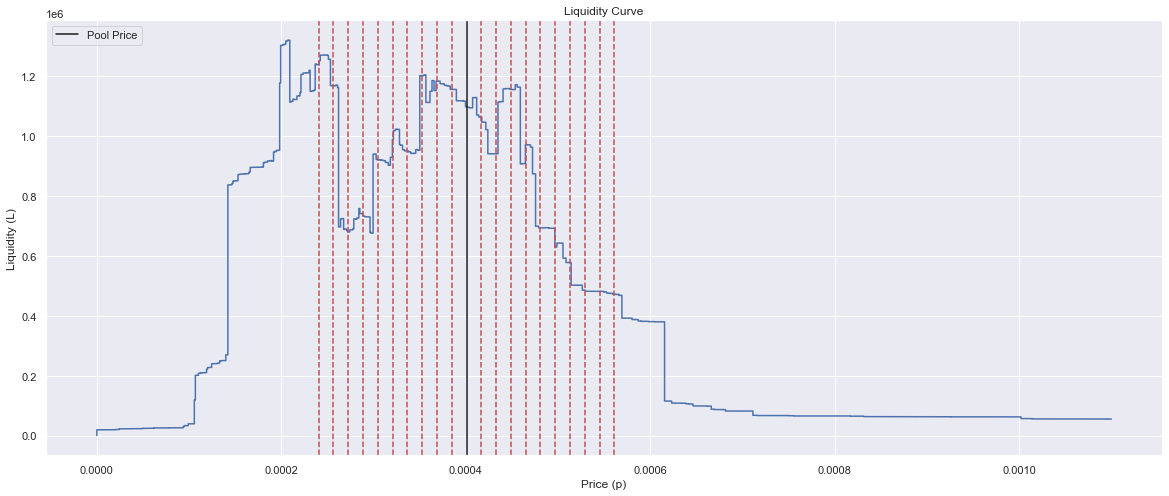

In [16]:
example_day = '2022-01-27 00:00:00'
sigma = 0.04
pool = pool_snapshots[example_day]
price_bins = np.array(
    [0]
    + [pool.price * (1 + i * sigma) for i in range(-10, 11)]
    + [np.inf]
)

fig, ax = plt.subplots(figsize=(20, 8))
pool.plot_liquidity_curve(interval=(0, 0.001), ax=ax)

for price in price_bins[1:-1]:
    if price == pool.price:
        ax.axvline(price, color='k', label='Pool Price')
    else:
        ax.axvline(price, color='r', linestyle='--')
ax.legend(loc='upper left')

plt.show()

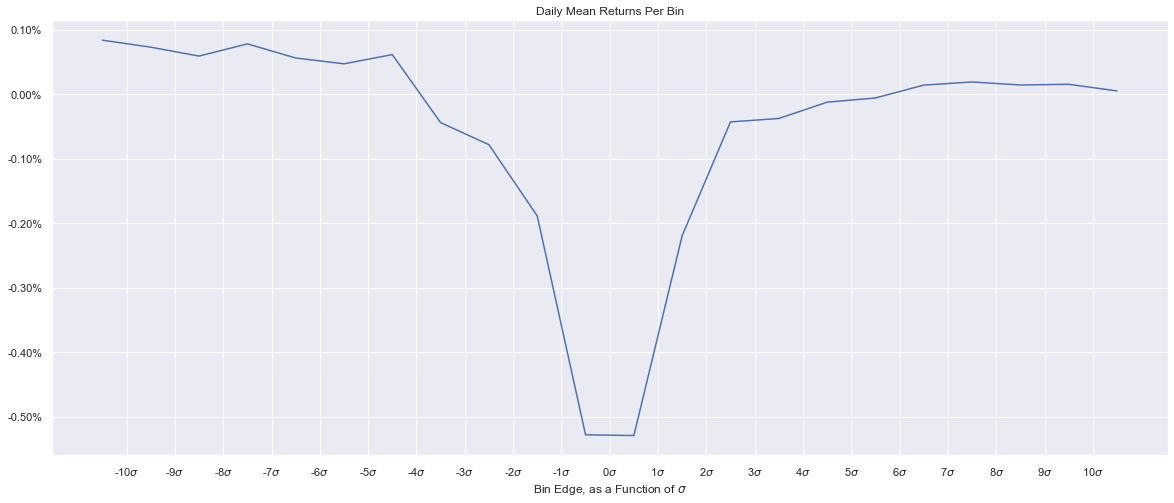

CPU times: user 3min 16s, sys: 4.14 s, total: 3min 20s
Wall time: 3min 22s


In [17]:
%%time
# daily returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='D',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_DAILY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

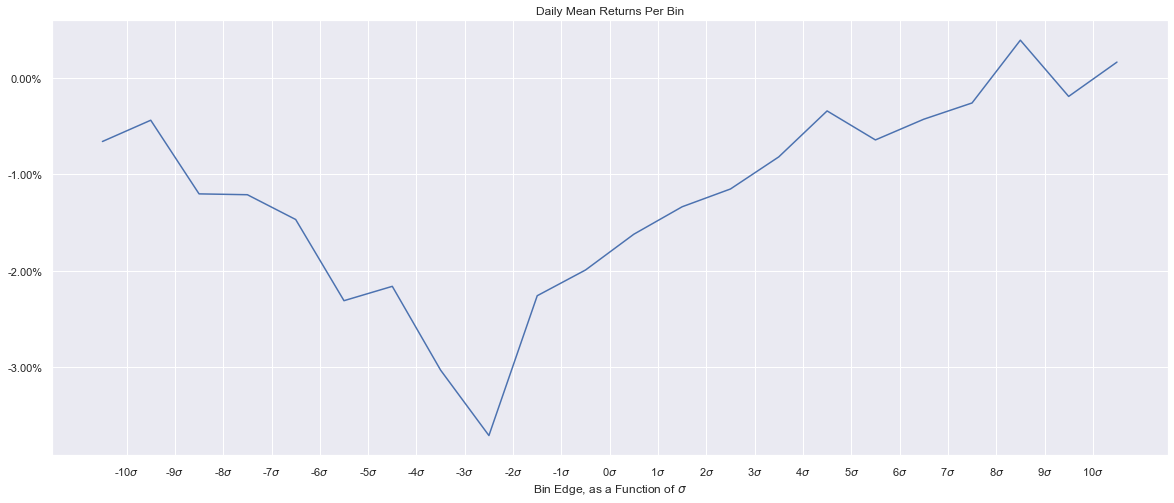

CPU times: user 51.3 s, sys: 1.55 s, total: 52.8 s
Wall time: 53.7 s


In [18]:
%%time
# weekly returns
all_returns = calc_all_returns_per_bin(
    pool_snapshots, 
    all_txn, 
    liquidity, 
    swaps,
    freq='W',  # pandas frequency codes (can also include anchor)
    sigma=0.04, 
    numeraire_token=NUMERAIRE_TOKEN
)
pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS)
   
bin_returns = defaultdict(list)
for day, irrs in all_returns.items():
    for bin_pos, irr in irrs.items():
        bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
        bin_returns[bin_no].append(irr)
        
fig, ax = plt.subplots(figsize=(20, 8))

x_pos, x_labels, y = [], [], []
for i in range(1, 23):
    x_pos.append(i)
    x_labels.append(f'{i - 11}$\sigma$')
    y.append(np.mean(bin_returns[i]))
ax.plot(x_pos, y)

ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
ax.set_title('Daily Mean Returns Per Bin')
ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

plt.show()

In [ ]:
# %%time
# # hourly returns
# all_returns = calc_all_returns_per_bin(
#     pool_snapshots, 
#     all_txn, 
#     liquidity, 
#     swaps,
#     freq='H',  # pandas frequency codes (can also include anchor)
#     sigma=0.005,  # reducing this for this test
#     numeraire_token=NUMERAIRE_TOKEN
# )
# # pd.to_pickle(all_returns, SAVED_WEEKLY_RETURNS) NOT SAVING THIS ONE FOR NOW!
   
# bin_returns = defaultdict(list)
# for day, irrs in all_returns.items():
#     for bin_pos, irr in irrs.items():
#         bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
#         bin_returns[bin_no].append(irr)
        
# fig, ax = plt.subplots(figsize=(20, 8))

# x_pos, x_labels, y = [], [], []
# for i in range(1, 23):
#     x_pos.append(i)
#     x_labels.append(f'{i - 11}$\sigma$')
#     y.append(np.mean(bin_returns[i]))
# ax.plot(x_pos, y)

# ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
# ax.set_title('Daily Mean Returns Per Bin')
# ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
# ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

# plt.show()